# Airfare Prediction - Submission by Shubhabrata Roy

# Data preprocessing and feature engineering

In [1]:
import numpy as np
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns
import re
from datetime import datetime, time
import math  
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
search_data = pd.read_csv("search_data (1).csv")
airport_data = pd.read_csv("airport_data.csv")

In [3]:
pd.set_option('display.max_columns', None)
search_data.head(10)

,search_id,search_time,currency,destination,search_user_id,language,origin,partner_id,passengers,pos,session_id,user_agent,num_requests,fare,supplier,cabin_class,carrier_1,carrier_2,flight_num_1,flight_num_2,departure_datetime_1,arrival_datetime_1,departure_datetime_2,arrival_datetime_2,itinerary_id
0,02c6c2ad-325b-4155-bb03-89badc92ea84,2017-02-01 00:00:07,USD,MIA,NBYNv9utORVjlf604rUgXL/eFz6Tmu2NyygDWTFsM5OOWH...,en,LAX,294,1,US,292c32ab-9744-490f-911a-d3536e86847e,Dalvik/2.1.0 (Linux; U; Android 6.0.1; SM-G920...,1,499.00,22,economy,AA,AA,AA1088,AA1147,2017-04-07T09:50:00-07:00,2017-04-07T17:56:00-04:00,2017-04-16T21:30:00-04:00,2017-04-17T00:33:00-07:00,294f363b-86f0-4e67-abe9-05221dadb8b8
1,0280e382-d24e-4138-bb20-8d236c0bb02f,2017-02-01 00:00:32,ISK,VCE,c2ea8bd4-40ff-4b8b-a42f-ada9b02ef963,en,REK,58,1,IS,d34dd58d-aec5-4d8f-abf7-090db2e011bd,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_2...,7,25895.00,103,Economy,FI; IB,NaN,FI540; IB5120,NaN,2017-06-10T01:05:00; 2017-06-10T14:50:00,2017-06-10T06:20:00; 2017-06-10T16:40:00,NaN,NaN,d9592a05-c850-4abd-9cf1-9fe8343d556c
2,c8903983-3eb9-4f0f-8f87-64b7e5dd0692,2017-02-01 00:00:39,USD,SJD,36195bda-ec40-4907-9428-c4fe11bd87fa,en,LAX,91,1,US,e0ae1ecd-8715-4577-bca4-604cf3a58d0e,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG-SM-...,1,286.79,91,economy,AA,AA,AA237,AA237,2017-05-30T08:35:00,2017-05-30T11:58:00,2017-06-03T13:00:00,2017-06-03T14:36:00,c53826cf-1fba-42a6-a765-941628e1901e
3,b1d666c8-d570-47ec-bc46-26ee5332620f,2017-02-01 00:00:48,USD,LHR,36ba8a8c-8c47-4dc6-bd70-0b3ae071c8cf,en,PHX,91,2,US,1eb74ec2-e6d7-4423-a1e3-de2a411a4aed,Mozilla/5.0 (Linux; Android 6.0.1; SAMSUNG SM-...,1,507.46,91,economy,DL; DL,DL; DL,DL5852; DL4414,DL11; DL1516,2017-05-10T13:13:00; 2017-05-10T18:30:00,2017-05-10T14:45:00; 2017-05-11T12:55:00,2017-05-28T12:55:00; 2017-05-28T17:50:00,2017-05-28T16:05:00; 2017-05-28T19:11:00,37a44686-8347-4c72-8690-c9432349f9a6
4,020521d7-ea85-49dd-97e2-1ae662f432a9,2017-02-01 00:00:48,ISK,BFS,cc24b343-7e53-48b4-9bdb-092a49381665,is,REK,58,2,IS,a3056056-6db5-44df-bca4-01a3bf8d9ff5,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,10,47717.49,103,Economy,FI; FR,FR; U2,FI470; FR1274,FR1138; U28507,2017-04-12T07:35:00; 2017-04-12T18:10:00,2017-04-12T11:35:00; 2017-04-12T19:35:00,2017-04-19T20:00:00; 2017-04-20T06:30:00,2017-04-19T21:20:00; 2017-04-20T08:45:00,52248983-0449-411f-9794-88c7bc098faa
5,0abbfe4c-b72d-42c7-ae8a-966643e14600,2017-02-01 00:00:54,USD,LAX,025ee32b-2a0b-4987-b275-893f148ab259,en,CMH,91,1,US,262b200e-b183-48ab-b737-72c251ca0ff3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1...,1,192.20,91,economy,AA,NaN,AA659,NaN,2017-03-29T16:35:00,2017-03-29T18:53:00,NaN,NaN,2e3afcd8-7d56-4b49-a71b-f85c23e1b807
6,198f2d0f-4f30-418c-bf78-ccf776a63501,2017-02-01 00:01:02,USD,MCO,f69465d7-cdb2-4dd0-98ad-6362423a8dc3,en,EGE,91,1,US,97d78806-2f65-48af-9d21-e7f9bb6a667c,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,1,615.60,91,economy,UA; UA,UA; UA,UA4475; UA564,UA1191; UA1252,2017-02-10T07:52:00; 2017-02-10T11:00:00,2017-02-10T09:03:00; 2017-02-10T16:31:00,2017-02-13T08:47:00; 2017-02-13T11:40:00,2017-02-13T10:30:00; 2017-02-13T13:41:00,619b0f7c-825f-47b1-a191-300862feff80
7,03224bb7-924c-4044-9f4b-033c3850447d,2017-02-01 00:01:06,USD,NYC,e68fb852-92c5-4ec4-8d6d-3c1549c749f2,en,YTO,58,1,RU,098bf286-4f80-4981-a723-e8c063cb5910,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,10,150.04,148,Economy,DL; DL,NaN,DL1822; DL5211,NaN,2017-02-16T06:10:00; 2017-02-16T08:37:00,2017-02-16T07:40:00; 2017-02-16T10:33:00,NaN,NaN,22b48ef5-4ff1-4356-86e8-4e37226d3bfb
8,bf0709c2-5775-48aa-952b-35f88430c431,2017-02-01 00:01:11,USD,PBI,7864485d-5c63-45ee-9e4d-a3c43e078b36,en,FLO,91,3,US,6619e1b4-7335-4ff3-9b9b-88bdc65ed715,Mozilla/5.0 (Linux; Android 6.0; RCT6513W87 Bu...,1,352.60,91,economy,AA; AA,AA; AA,AA4933; AA1846,AA539; AA4860,2017-05-26T05:25:00; 2017-05-26T07:40:00,2017-05-26T06:16:00; 2017-05-26T09:31:00,2017-05-28T08:25:00; 2017-05-28T13:00:00,2017-05-28T10:18:00; 2017-05-28T13

In [4]:
airport_data_ = airport_data.groupby(["iata_code", "country"]).first().reset_index()   
duplicate_iata = list(set(airport_data_[airport_data_['iata_code'].duplicated(keep=False)]))

In [5]:
search_data = search_data[(~search_data['origin'].isin(duplicate_iata)) | (~search_data['destination'].isin(duplicate_iata))]

In [6]:
def cleandatetime(dtstring):
    """
    Function to clean data and remove extra unwanted chanracters
    """
    if len(dtstring) > 19:
        chrmv = len(dtstring)-19
        mod_dtstring = dtstring[:len(dtstring)-chrmv]
    else:
        mod_dtstring = dtstring
    return mod_dtstring.strip()

def converttodtm(datetime_str):
    return datetime.strptime(datetime_str, '%Y-%m-%dT%H:%M:%S')

In [7]:
search_data["first_departure_datetime_1"] = [j.split(";")[0] for j in search_data["departure_datetime_1"]]
search_data["first_departure_datetime_1"] = [cleandatetime(j) for j in search_data["first_departure_datetime_1"]]
search_data["first_departure_datetime_1"] = pd.to_datetime(search_data["first_departure_datetime_1"], errors = 'coerce')
search_data=search_data[~search_data["first_departure_datetime_1"].isna()]
search_data[['search_time','first_departure_datetime_1']] = search_data[['search_time','first_departure_datetime_1']].apply(pd.to_datetime) #if conversion required
search_data['days_until_flights'] = (search_data['first_departure_datetime_1'] - search_data['search_time']).dt.days

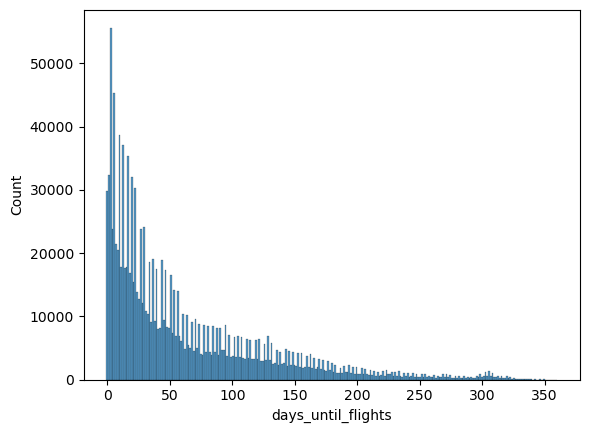

In [8]:
sns.histplot(data=search_data, x="days_until_flights")
plt.show()

In [9]:
departure_times_1 = [j.split(";") for j in search_data["departure_datetime_1"]]
arrival_times_1 = [j.split(";") for j in search_data["arrival_datetime_1"]]


search_data["departure_datetime_2"] = search_data["departure_datetime_2"].fillna(-1)
search_data["arrival_datetime_2"] = search_data["arrival_datetime_2"].fillna(-1)


departure_times_2 = [-1 if j == -1 else j.split(";") for j in search_data["departure_datetime_2"]]
arrival_times_2 = [-1 if j == -1 else j.split(";") for j in search_data["arrival_datetime_2"]]

In [10]:
search_data["n_connections_outbd"] = [(len(j.split(";")) - 1) for j in search_data["departure_datetime_1"]]
search_data["n_connections_inbd"] = [-1 if j == -1 else (len(j.split(";")) - 1) for j in search_data["departure_datetime_2"]]

In [11]:
def flightdur(dep, arr):
    durations = []
    for a, b in zip(dep, arr):
        dur_ = []
        if (a==-1 or b==-1):
            dur_.append(0)
        else:
            for aa, bb in zip(a, b):
                dur_.append((converttodtm(cleandatetime(bb)) - converttodtm(cleandatetime(aa))).seconds/60)
        durations.append(dur_)  
    return durations

In [12]:
durations_inbound = flightdur(departure_times_2, arrival_times_2)
durations_outbound = flightdur(departure_times_1, arrival_times_1)

In [13]:
search_data["mean_flight_time_outbound"] = [np.mean(j) for j in durations_outbound]
search_data["total_flight_time_outbound"] = [np.sum(j) for j in durations_outbound]
search_data["mean_flight_time_inbound"] = [np.mean(j) for j in durations_inbound]
search_data["total_flight_time_inbound"] = [np.sum(j) for j in durations_inbound]

In [14]:
def getwaittime(dep, arr, connections):
    wait = []
    for p, q, r in zip(dep, arr, connections):
        waits = []
        if (p==-1 or q==-1 or r == 0):
            waits.append(0)
        else:
            for pp, qq in enumerate(q):
                if pp+1<len(p):
                    waits.append((converttodtm(cleandatetime(q[pp+1])) - converttodtm(cleandatetime(p[pp]))).seconds/60)
        wait.append(np.nanmean(waits))
    return wait

In [15]:
search_data["wait_time_outbnd"] = getwaittime(departure_times_1, arrival_times_1, search_data["n_connections_outbd"])
search_data["wait_time_inbnd"] = getwaittime(departure_times_2, arrival_times_2, search_data["n_connections_inbd"])

In [16]:
def gettimeclass(times):
    if times == -1:
        timeclass = -1
    elif datetime.strptime("7:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("5:59", "%H:%M"):
        timeclass = "Early Morning"
    elif datetime.strptime("9:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("7:59", "%H:%M"):
        timeclass = "Mid Morning"
    elif datetime.strptime("11:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("9:59", "%H:%M"):
        timeclass = "Late Morning"
    elif datetime.strptime("16:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("11:59", "%H:%M"):
        timeclass = "Afternoon"
    elif datetime.strptime("20:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("16:59", "%H:%M"):
        timeclass = "Evening"
    elif datetime.strptime("23:59", "%H:%M") > datetime.strptime(cleandatetime(times[0]).split("T")[1], "%H:%M:%S") > datetime.strptime("20:59", "%H:%M"):
        timeclass = "Night"
    else:
        timeclass = "Late Night"
    return timeclass

In [17]:
search_data["outbounddeparturetimeclass"] = [gettimeclass(i) for i in departure_times_1]
search_data["inbounddeparturetimeclass"] = [gettimeclass(i) for i in departure_times_2]

In [18]:
search_data["carrier_2"] = search_data["carrier_2"].fillna("NA")

In [19]:
def checkmulticarrier(flightstring):
    """
    checking if more than one carrier type is involved
    """
    if flightstring == "NA":
        mult=-1
    else:
        flights = flightstring.split(";")
        flights = [i.strip() for i in flights]
        if len(flights)==1:
            mult = 1
        elif len(set(flights)) == 1:
            mult = 1
        else:
            mult = 2
    return mult

In [20]:
search_data["multicarrier_outbound"] = [checkmulticarrier(i) for i in search_data["carrier_1"]]
search_data["multicarrier_inbound"] = [checkmulticarrier(i) for i in search_data["carrier_2"]]

In [21]:
conversion = pd.read_csv("conversion.csv")
search_data_ = pd.merge(search_data, conversion, how="inner", on="currency")

In [22]:
search_data_["currency_usd"] = [i/j for i, j in zip(search_data_["fare"], search_data_["2022"])]

In [23]:
search_data_.cabin_class = ['economy' if j in ["ECONOMY", "Economy", "economy"] else 'premium economy' if j 
                            in ["Premium Economy", "premiumEconomy", "premium_economy"] else "business" if j in
                           ["Business", "business"] else "first" if j in ["First", "First Class", "first"] else
                           "coach" if j in ["COACH"] else "mixed" for j in search_data_.cabin_class]

In [24]:
le = preprocessing.LabelEncoder()

In [26]:
search_data_["carrier_1_code"] = le.fit_transform(search_data_.carrier_1)
search_data_["carrier_2_code"] = le.fit_transform(search_data_.carrier_2)
search_data_["cabin_class_code"] = le.fit_transform(search_data_.cabin_class)
search_data_["outbounddeparturetimeclass_code"] = le.fit_transform(search_data_.outbounddeparturetimeclass.astype(str))
search_data_["inbounddeparturetimeclass_code"] = le.fit_transform(search_data_.inbounddeparturetimeclass.astype(str))
search_data_["origin_code"] = le.fit_transform(search_data_.origin)
search_data_["destination_code"] = le.fit_transform(search_data_.destination)

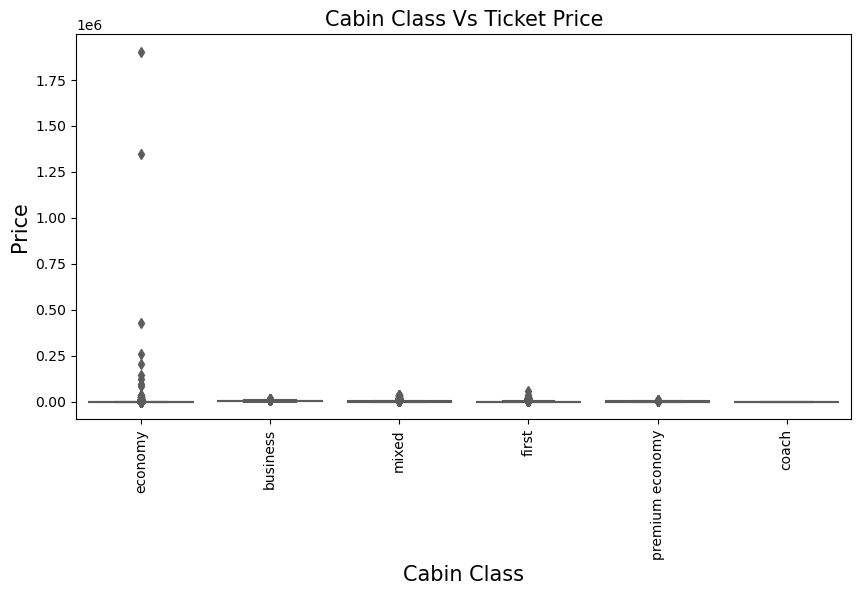

In [27]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='cabin_class',y='currency_usd',data=search_data_,palette='hls')
plt.title('Cabin Class Vs Ticket Price',fontsize=15)
plt.xlabel('Cabin Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [28]:
search_data__ = search_data_[search_data_.currency_usd < 50000]

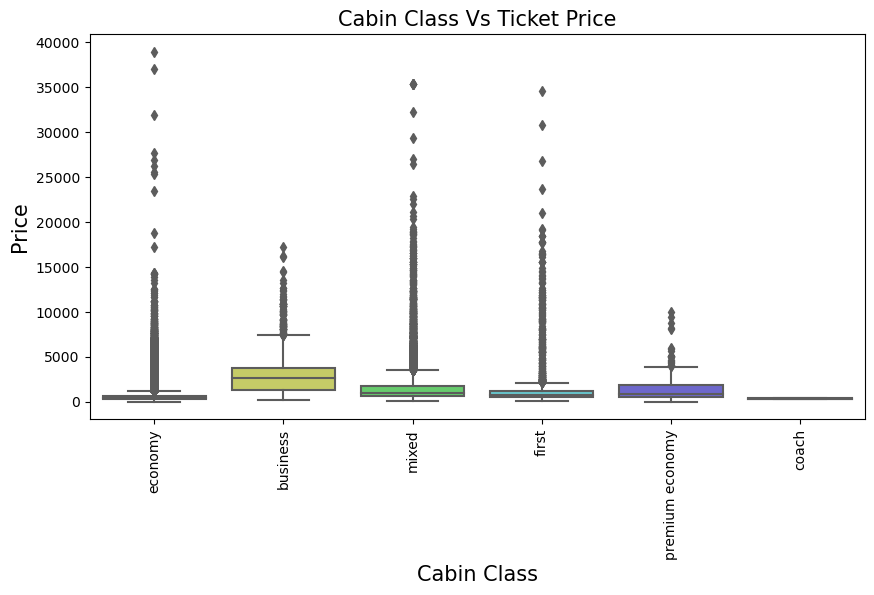

In [29]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='cabin_class',y='currency_usd',data=search_data__,palette='hls')
plt.title('Cabin Class Vs Ticket Price',fontsize=15)
plt.xlabel('Cabin Class',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

In [31]:
print("We discard " + str((len(search_data_) - len(search_data__))/len(search_data_) * 100) + "% of the data by outlier removal" )

We discard 0.0007830737052463588% of the data by outlier removal


In [32]:
columns_tobeused = ['days_until_flights', 'n_connections_outbd',
       'n_connections_inbd', 'mean_flight_time_outbound',
       'total_flight_time_outbound', 'mean_flight_time_inbound',
       'total_flight_time_inbound', 'wait_time_outbnd', 'wait_time_inbnd',
       'multicarrier_outbound', 'multicarrier_inbound', 'currency_usd',
       'carrier_1_code', 'carrier_2_code', 'cabin_class_code',
       'outbounddeparturetimeclass_code', 'inbounddeparturetimeclass_code',
       'origin_code', 'destination_code', "supplier", "partner_id", "passengers", "num_requests"]

In [33]:
final_data = search_data__[columns_tobeused]

In [35]:
final_data.shape

(1277009, 23)

In [34]:
final_data.head()

,days_until_flights,n_connections_outbd,n_connections_inbd,mean_flight_time_outbound,total_flight_time_outbound,mean_flight_time_inbound,total_flight_time_inbound,wait_time_outbnd,wait_time_inbnd,multicarrier_outbound,multicarrier_inbound,currency_usd,carrier_1_code,carrier_2_code,cabin_class_code,outbounddeparturetimeclass_code,inbounddeparturetimeclass_code,origin_code,destination_code,supplier,partner_id,passengers,num_requests
0,65,0,0,486.0,486.0,183.0,183.0,0.0,0.0,1,1,499.00,561,552,2,5,7,798,1105,22,294,1,1
1,118,0,0,203.0,203.0,96.0,96.0,0.0,0.0,1,1,286.79,561,552,2,5,1,798,1570,91,91,1,1
2,98,1,1,598.5,1197.0,135.5,271.0,1422.0,376.0,1,1,507.46,4023,2925,2,0,1,1126,980,91,91,2,1
3,56,0,-1,138.0,138.0,0.0,0.0,0.0,0.0,1,-1,192.20,561,5976,2,0,0,291,943,91,91,1,1
4,9,1,1,201.0,402.0,112.0,224.0,519.0,294.0,1,1,615.60,10959,8324,2,1,6,425,1067,91,91,1,1


In [36]:
final_data.isnull().sum()

days_until_flights                 0
n_connections_outbd                0
n_connections_inbd                 0
mean_flight_time_outbound          0
total_flight_time_outbound         0
mean_flight_time_inbound           0
total_flight_time_inbound          0
wait_time_outbnd                   0
wait_time_inbnd                    0
multicarrier_outbound              0
multicarrier_inbound               0
currency_usd                       0
carrier_1_code                     0
carrier_2_code                     0
cabin_class_code                   0
outbounddeparturetimeclass_code    0
inbounddeparturetimeclass_code     0
origin_code                        0
destination_code                   0
supplier                           0
partner_id                         0
passengers                         0
num_requests                       0
dtype: int64

# Visualization

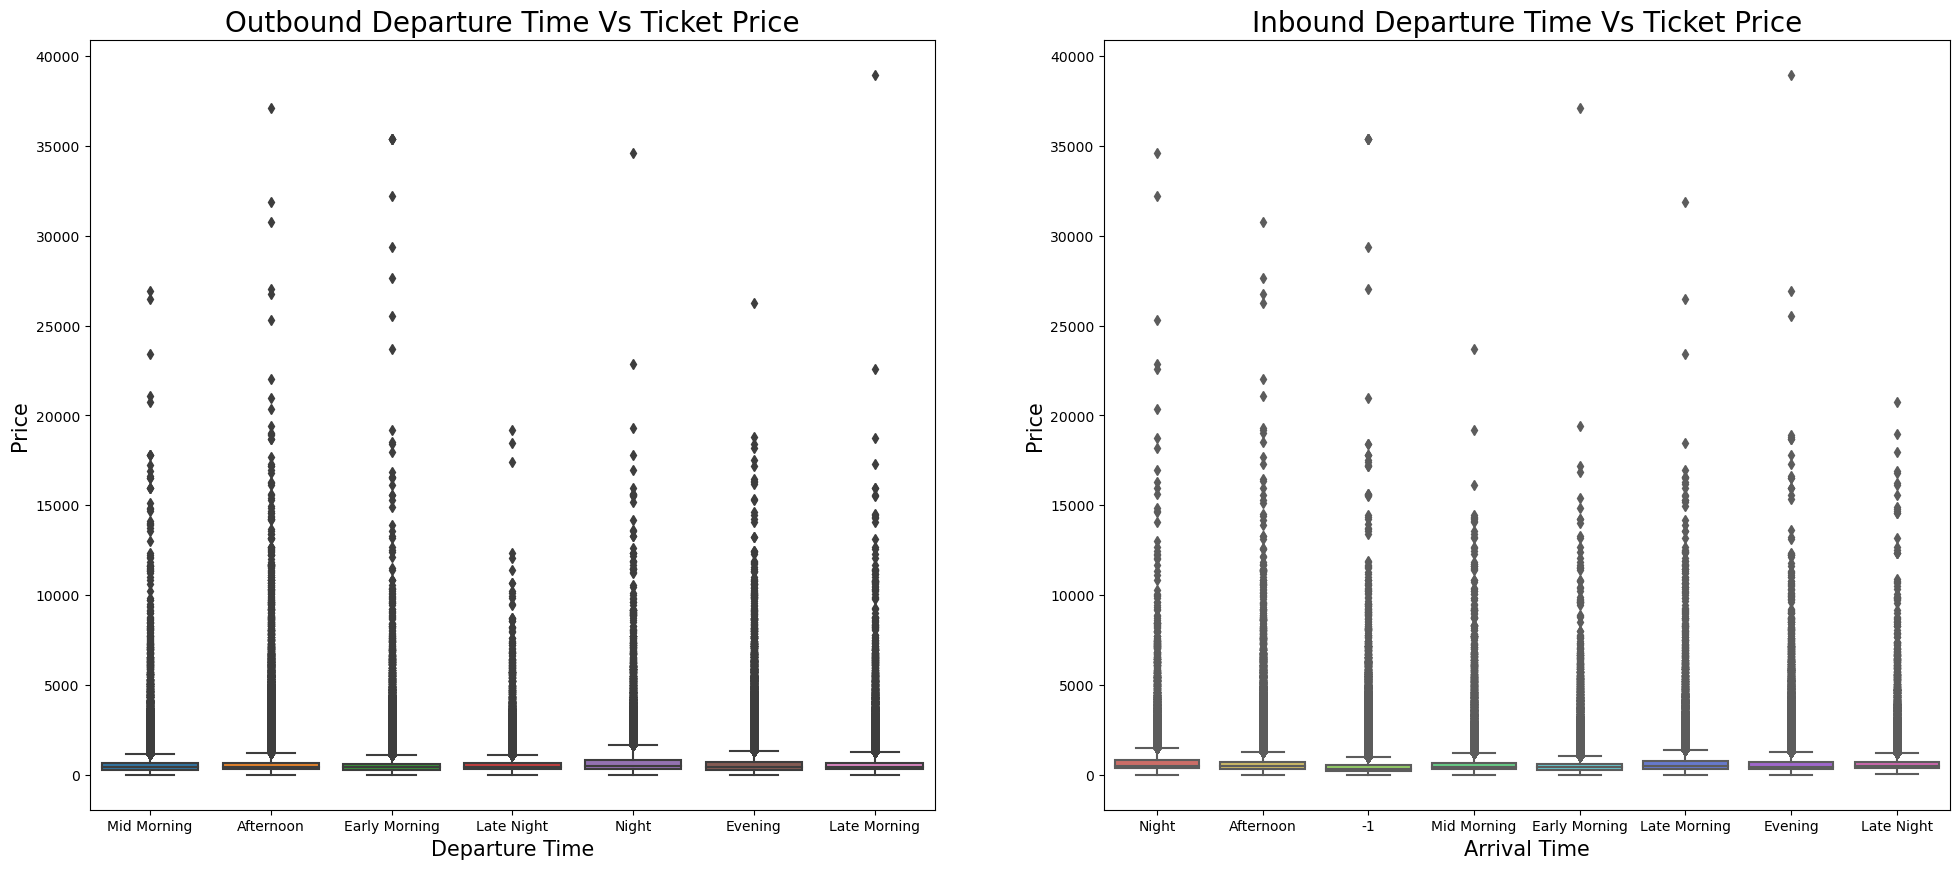

In [38]:
plt.figure(figsize=(24,10))
plt.subplot(1,2,1)
sns.boxplot(x='outbounddeparturetimeclass',y='currency_usd',data=search_data__)
plt.title('Outbound Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Departure Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(x='inbounddeparturetimeclass',y='currency_usd',data=search_data__,palette='hls')
plt.title('Inbound Departure Time Vs Ticket Price',fontsize=20)
plt.xlabel('Arrival Time',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

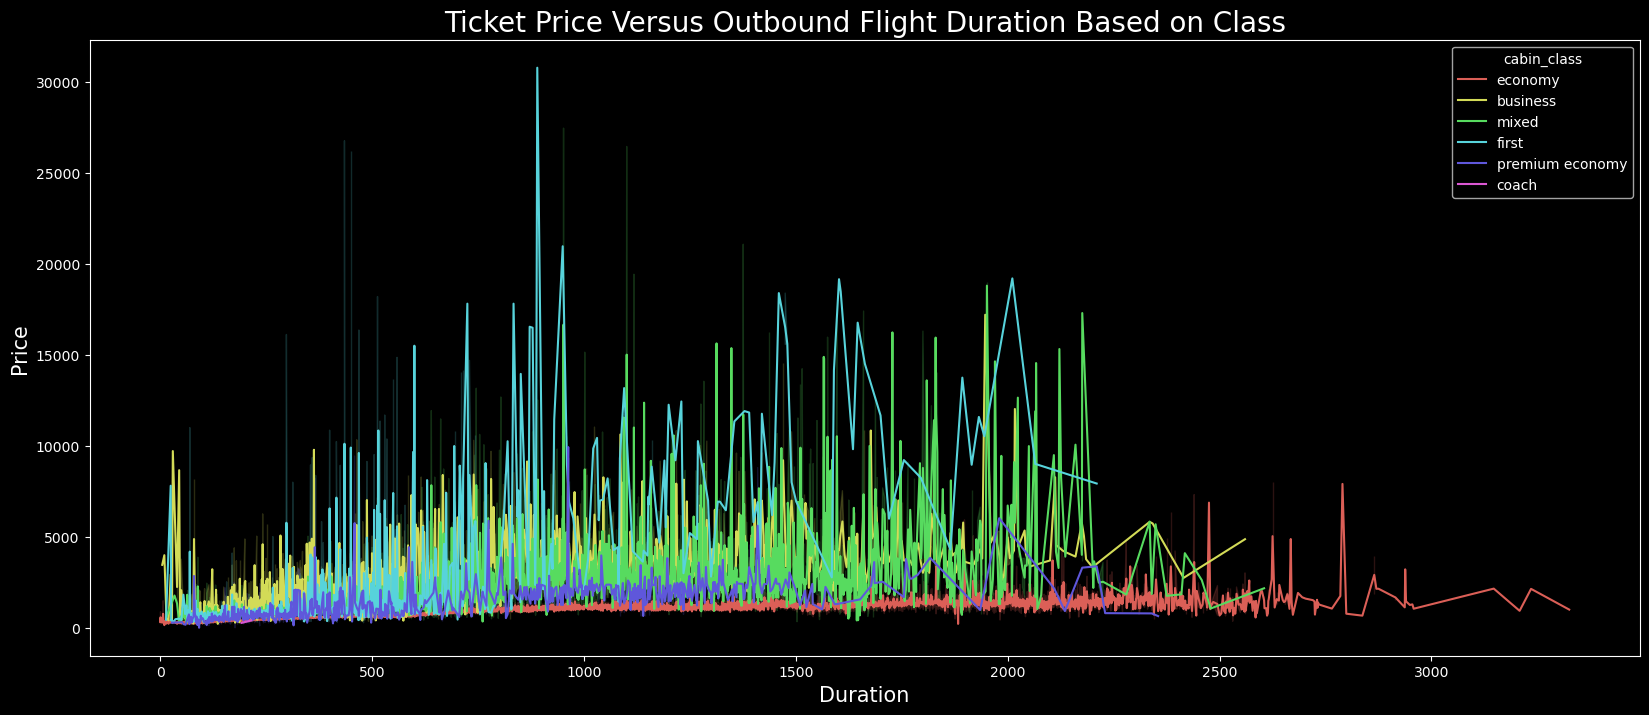

In [40]:
plt.style.use('dark_background')
plt.figure(figsize=(20,8))
sns.lineplot(data=search_data__,x='total_flight_time_outbound',y='currency_usd',hue='cabin_class',palette='hls')
plt.title('Ticket Price Versus Outbound Flight Duration Based on Class',fontsize=20)
plt.xlabel('Duration',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

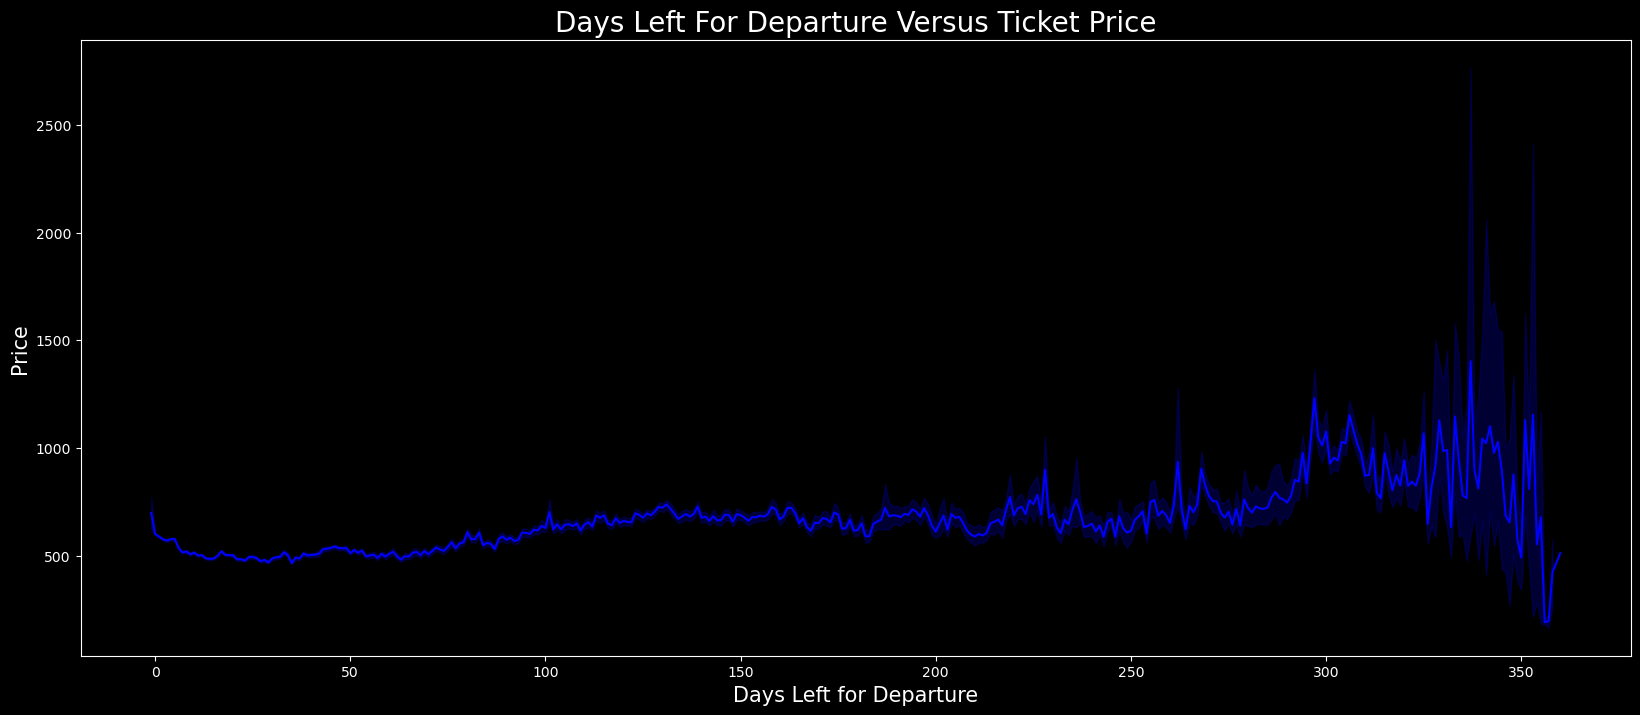

In [42]:
plt.figure(figsize=(20,8))
sns.lineplot(data=search_data__,x='days_until_flights',y='currency_usd',color='blue')
plt.title('Days Left For Departure Versus Ticket Price',fontsize=20)
plt.xlabel('Days Left for Departure',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

# Model fitting and performance evaluation

In [57]:
import catboost as cb
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler

In [47]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [48]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [72]:
y = final_data.currency_usd
X = final_data.loc[:, final_data.columns  != "currency_usd"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

In [53]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

In [54]:
model.grid_search(grid, train_dataset)

0:	learn: 775.9309062	test: 757.3442296	best: 757.3442296 (0)	total: 205ms	remaining: 20.3s
1:	learn: 761.8625932	test: 743.1052179	best: 743.1052179 (1)	total: 240ms	remaining: 11.8s
2:	learn: 748.3435425	test: 729.4344081	best: 729.4344081 (2)	total: 265ms	remaining: 8.58s
3:	learn: 735.4383297	test: 716.3716381	best: 716.3716381 (3)	total: 289ms	remaining: 6.93s
4:	learn: 723.0399903	test: 703.8037991	best: 703.8037991 (4)	total: 313ms	remaining: 5.94s
5:	learn: 711.1770515	test: 691.7731694	best: 691.7731694 (5)	total: 337ms	remaining: 5.27s
6:	learn: 699.9442441	test: 680.3516103	best: 680.3516103 (6)	total: 363ms	remaining: 4.82s
7:	learn: 689.0244340	test: 669.2606320	best: 669.2606320 (7)	total: 392ms	remaining: 4.5s
8:	learn: 678.5987489	test: 658.6778287	best: 658.6778287 (8)	total: 420ms	remaining: 4.25s
9:	learn: 668.6404841	test: 648.5310868	best: 648.5310868 (9)	total: 448ms	remaining: 4.03s
10:	learn: 659.0738668	test: 638.8100457	best: 638.8100457 (10)	total: 475ms	rema

88:	learn: 448.3259662	test: 422.9114119	best: 422.9114119 (88)	total: 2.46s	remaining: 304ms
89:	learn: 447.8592283	test: 422.4151562	best: 422.4151562 (89)	total: 2.49s	remaining: 276ms
90:	learn: 447.4226665	test: 421.9412631	best: 421.9412631 (90)	total: 2.52s	remaining: 249ms
91:	learn: 446.9756344	test: 421.5152531	best: 421.5152531 (91)	total: 2.54s	remaining: 221ms
92:	learn: 446.5441955	test: 421.1283937	best: 421.1283937 (92)	total: 2.58s	remaining: 194ms
93:	learn: 446.0959434	test: 420.6698333	best: 420.6698333 (93)	total: 2.6s	remaining: 166ms
94:	learn: 445.6208527	test: 420.2584648	best: 420.2584648 (94)	total: 2.63s	remaining: 138ms
95:	learn: 445.2229152	test: 419.8682679	best: 419.8682679 (95)	total: 2.66s	remaining: 111ms
96:	learn: 444.8444199	test: 419.4559904	best: 419.4559904 (96)	total: 2.69s	remaining: 83.1ms
97:	learn: 444.4788994	test: 419.0931823	best: 419.0931823 (97)	total: 2.71s	remaining: 55.4ms
98:	learn: 444.1259167	test: 418.7371289	best: 418.7371289 

79:	learn: 423.0110348	test: 398.9908483	best: 398.9908483 (79)	total: 2.04s	remaining: 509ms
80:	learn: 422.8653760	test: 398.8643557	best: 398.8643557 (80)	total: 2.06s	remaining: 483ms
81:	learn: 422.7034376	test: 398.7875359	best: 398.7875359 (81)	total: 2.08s	remaining: 457ms
82:	learn: 422.5901111	test: 398.6773988	best: 398.6773988 (82)	total: 2.11s	remaining: 431ms
83:	learn: 422.4787549	test: 398.5872941	best: 398.5872941 (83)	total: 2.13s	remaining: 406ms
84:	learn: 422.3581134	test: 398.4806210	best: 398.4806210 (84)	total: 2.16s	remaining: 381ms
85:	learn: 422.2595427	test: 398.3933825	best: 398.3933825 (85)	total: 2.18s	remaining: 355ms
86:	learn: 422.1719412	test: 398.3103959	best: 398.3103959 (86)	total: 2.21s	remaining: 330ms
87:	learn: 421.9306998	test: 398.0718467	best: 398.0718467 (87)	total: 2.23s	remaining: 304ms
88:	learn: 421.8414903	test: 397.9922413	best: 397.9922413 (88)	total: 2.25s	remaining: 279ms
89:	learn: 421.6894602	test: 397.9209229	best: 397.9209229 (

68:	learn: 461.2394770	test: 435.8835624	best: 435.8835624 (68)	total: 1.81s	remaining: 814ms
69:	learn: 460.4000291	test: 435.0276790	best: 435.0276790 (69)	total: 1.84s	remaining: 787ms
70:	learn: 459.6138787	test: 434.1825994	best: 434.1825994 (70)	total: 1.86s	remaining: 761ms
71:	learn: 458.8583477	test: 433.3874719	best: 433.3874719 (71)	total: 1.89s	remaining: 733ms
72:	learn: 458.0632545	test: 432.5720447	best: 432.5720447 (72)	total: 1.91s	remaining: 706ms
73:	learn: 457.2561783	test: 431.8323958	best: 431.8323958 (73)	total: 1.93s	remaining: 679ms
74:	learn: 456.5220064	test: 431.0795976	best: 431.0795976 (74)	total: 1.95s	remaining: 652ms
75:	learn: 455.8334498	test: 430.4054644	best: 430.4054644 (75)	total: 1.98s	remaining: 625ms
76:	learn: 455.1512838	test: 429.7269037	best: 429.7269037 (76)	total: 2s	remaining: 598ms
77:	learn: 454.5090041	test: 429.0468708	best: 429.0468708 (77)	total: 2.03s	remaining: 573ms
78:	learn: 453.8825335	test: 428.4252249	best: 428.4252249 (78)

59:	learn: 426.5619753	test: 402.1646459	best: 402.1646459 (59)	total: 1.59s	remaining: 1.06s
60:	learn: 426.3125339	test: 401.9225109	best: 401.9225109 (60)	total: 1.62s	remaining: 1.03s
61:	learn: 426.1208436	test: 401.7342273	best: 401.7342273 (61)	total: 1.64s	remaining: 1.01s
62:	learn: 425.9066315	test: 401.5377283	best: 401.5377283 (62)	total: 1.67s	remaining: 981ms
63:	learn: 425.7268782	test: 401.3470742	best: 401.3470742 (63)	total: 1.7s	remaining: 954ms
64:	learn: 425.5574794	test: 401.1721080	best: 401.1721080 (64)	total: 1.72s	remaining: 927ms
65:	learn: 425.3418439	test: 400.9571088	best: 400.9571088 (65)	total: 1.75s	remaining: 901ms
66:	learn: 425.1617760	test: 400.7962166	best: 400.7962166 (66)	total: 1.77s	remaining: 873ms
67:	learn: 424.9999881	test: 400.6386108	best: 400.6386108 (67)	total: 1.8s	remaining: 847ms
68:	learn: 424.7594474	test: 400.5325789	best: 400.5325789 (68)	total: 1.83s	remaining: 821ms
69:	learn: 424.6102742	test: 400.3824318	best: 400.3824318 (69

50:	learn: 482.9743388	test: 457.9785549	best: 457.9785549 (50)	total: 1.41s	remaining: 1.35s
51:	learn: 481.2970853	test: 456.2712769	best: 456.2712769 (51)	total: 1.43s	remaining: 1.32s
52:	learn: 479.6998205	test: 454.6659030	best: 454.6659030 (52)	total: 1.46s	remaining: 1.29s
53:	learn: 478.1879747	test: 453.1388776	best: 453.1388776 (53)	total: 1.48s	remaining: 1.26s
54:	learn: 476.7107298	test: 451.6256440	best: 451.6256440 (54)	total: 1.51s	remaining: 1.23s
55:	learn: 475.3390933	test: 450.2436991	best: 450.2436991 (55)	total: 1.53s	remaining: 1.2s
56:	learn: 473.9975392	test: 448.8761626	best: 448.8761626 (56)	total: 1.56s	remaining: 1.18s
57:	learn: 472.6560281	test: 447.5453515	best: 447.5453515 (57)	total: 1.58s	remaining: 1.15s
58:	learn: 471.3968111	test: 446.2888177	best: 446.2888177 (58)	total: 1.61s	remaining: 1.12s
59:	learn: 470.1840574	test: 445.0643283	best: 445.0643283 (59)	total: 1.63s	remaining: 1.09s
60:	learn: 469.0303394	test: 443.8497836	best: 443.8497836 (6

41:	learn: 433.5207394	test: 408.5412362	best: 408.5412362 (41)	total: 1.25s	remaining: 1.73s
42:	learn: 433.0681164	test: 408.0995712	best: 408.0995712 (42)	total: 1.3s	remaining: 1.72s
43:	learn: 432.4173969	test: 407.6624293	best: 407.6624293 (43)	total: 1.34s	remaining: 1.71s
44:	learn: 431.8354974	test: 407.0676871	best: 407.0676871 (44)	total: 1.38s	remaining: 1.69s
45:	learn: 431.4257999	test: 406.6333437	best: 406.6333437 (45)	total: 1.42s	remaining: 1.67s
46:	learn: 430.9901311	test: 406.2195847	best: 406.2195847 (46)	total: 1.46s	remaining: 1.65s
47:	learn: 430.5973833	test: 405.8947505	best: 405.8947505 (47)	total: 1.5s	remaining: 1.62s
48:	learn: 430.2294099	test: 405.5122733	best: 405.5122733 (48)	total: 1.53s	remaining: 1.6s
49:	learn: 429.7525649	test: 405.1550434	best: 405.1550434 (49)	total: 1.57s	remaining: 1.57s
50:	learn: 429.4537207	test: 404.8241625	best: 404.8241625 (50)	total: 1.61s	remaining: 1.54s
51:	learn: 429.0282729	test: 404.3998950	best: 404.3998950 (51)

28:	learn: 542.9969755	test: 519.8753964	best: 519.8753964 (28)	total: 1.19s	remaining: 2.9s
29:	learn: 538.8995763	test: 515.6906916	best: 515.6906916 (29)	total: 1.23s	remaining: 2.86s
30:	learn: 534.9102467	test: 511.6169909	best: 511.6169909 (30)	total: 1.26s	remaining: 2.8s
31:	learn: 531.1133385	test: 507.7522519	best: 507.7522519 (31)	total: 1.29s	remaining: 2.75s
32:	learn: 527.4771295	test: 503.9428826	best: 503.9428826 (32)	total: 1.33s	remaining: 2.7s
33:	learn: 524.0453818	test: 500.4051247	best: 500.4051247 (33)	total: 1.36s	remaining: 2.65s
34:	learn: 520.7323589	test: 496.9468125	best: 496.9468125 (34)	total: 1.4s	remaining: 2.6s
35:	learn: 517.5246976	test: 493.6926277	best: 493.6926277 (35)	total: 1.43s	remaining: 2.55s
36:	learn: 514.4858139	test: 490.5660781	best: 490.5660781 (36)	total: 1.48s	remaining: 2.52s
37:	learn: 511.5107682	test: 487.5468240	best: 487.5468240 (37)	total: 1.52s	remaining: 2.48s
38:	learn: 508.7281131	test: 484.6206363	best: 484.6206363 (38)	t

20:	learn: 459.2961085	test: 434.0706531	best: 434.0706531 (20)	total: 761ms	remaining: 2.86s
21:	learn: 456.6739577	test: 431.4257842	best: 431.4257842 (21)	total: 793ms	remaining: 2.81s
22:	learn: 454.2918906	test: 429.2366491	best: 429.2366491 (22)	total: 825ms	remaining: 2.76s
23:	learn: 452.2574715	test: 427.2055678	best: 427.2055678 (23)	total: 861ms	remaining: 2.72s
24:	learn: 450.4334434	test: 425.3701958	best: 425.3701958 (24)	total: 897ms	remaining: 2.69s
25:	learn: 448.6896975	test: 423.5089773	best: 423.5089773 (25)	total: 927ms	remaining: 2.64s
26:	learn: 446.9697830	test: 421.7472885	best: 421.7472885 (26)	total: 960ms	remaining: 2.6s
27:	learn: 445.5905521	test: 420.4389111	best: 420.4389111 (27)	total: 994ms	remaining: 2.56s
28:	learn: 444.2914039	test: 419.0930534	best: 419.0930534 (28)	total: 1.02s	remaining: 2.51s
29:	learn: 443.1966822	test: 417.8946586	best: 417.8946586 (29)	total: 1.06s	remaining: 2.48s
30:	learn: 442.1097515	test: 416.9536648	best: 416.9536648 (3

12:	learn: 641.1735536	test: 620.5861866	best: 620.5861866 (12)	total: 497ms	remaining: 5.24s
13:	learn: 632.8230664	test: 612.0172227	best: 612.0172227 (13)	total: 530ms	remaining: 5.15s
14:	learn: 624.8400011	test: 603.7898943	best: 603.7898943 (14)	total: 566ms	remaining: 5.1s
15:	learn: 617.1445668	test: 595.9696952	best: 595.9696952 (15)	total: 602ms	remaining: 5.04s
16:	learn: 609.8180462	test: 588.4663546	best: 588.4663546 (16)	total: 642ms	remaining: 5.02s
17:	learn: 602.8130877	test: 581.2819878	best: 581.2819878 (17)	total: 679ms	remaining: 4.98s
18:	learn: 596.0322498	test: 574.3882504	best: 574.3882504 (18)	total: 714ms	remaining: 4.92s
19:	learn: 589.6507855	test: 567.8427169	best: 567.8427169 (19)	total: 749ms	remaining: 4.87s
20:	learn: 583.5121634	test: 561.4871391	best: 561.4871391 (20)	total: 783ms	remaining: 4.81s
21:	learn: 577.5771825	test: 555.4561284	best: 555.4561284 (21)	total: 815ms	remaining: 4.74s
22:	learn: 571.8937993	test: 549.6515988	best: 549.6515988 (2

100:	learn: 443.4270485	test: 418.0332009	best: 418.0332009 (100)	total: 3.67s	remaining: 1.78s
101:	learn: 443.0849140	test: 417.7349642	best: 417.7349642 (101)	total: 3.71s	remaining: 1.74s
102:	learn: 442.6919810	test: 417.3585219	best: 417.3585219 (102)	total: 3.75s	remaining: 1.71s
103:	learn: 442.3744733	test: 417.0233167	best: 417.0233167 (103)	total: 3.78s	remaining: 1.67s
104:	learn: 442.0046104	test: 416.6806279	best: 416.6806279 (104)	total: 3.82s	remaining: 1.64s
105:	learn: 441.7023772	test: 416.4208641	best: 416.4208641 (105)	total: 3.86s	remaining: 1.6s
106:	learn: 441.4127365	test: 416.1129806	best: 416.1129806 (106)	total: 3.9s	remaining: 1.57s
107:	learn: 441.1210370	test: 415.8171336	best: 415.8171336 (107)	total: 3.94s	remaining: 1.53s
108:	learn: 440.7675634	test: 415.5102920	best: 415.5102920 (108)	total: 3.97s	remaining: 1.49s
109:	learn: 440.4852395	test: 415.2358791	best: 415.2358791 (109)	total: 4.01s	remaining: 1.46s
110:	learn: 440.1472065	test: 414.8914883	

40:	learn: 434.0378824	test: 409.0941425	best: 409.0941425 (40)	total: 1.48s	remaining: 3.93s
41:	learn: 433.5141184	test: 408.5348986	best: 408.5348986 (41)	total: 1.51s	remaining: 3.89s
42:	learn: 433.0615258	test: 408.0932651	best: 408.0932651 (42)	total: 1.56s	remaining: 3.88s
43:	learn: 432.4108216	test: 407.6562515	best: 407.6562515 (43)	total: 1.6s	remaining: 3.85s
44:	learn: 431.8289552	test: 407.0615430	best: 407.0615430 (44)	total: 1.64s	remaining: 3.83s
45:	learn: 431.4187252	test: 406.6265525	best: 406.6265525 (45)	total: 1.68s	remaining: 3.79s
46:	learn: 430.9830924	test: 406.2128322	best: 406.2128322 (46)	total: 1.72s	remaining: 3.76s
47:	learn: 430.5904833	test: 405.8881532	best: 405.8881532 (47)	total: 1.75s	remaining: 3.72s
48:	learn: 430.2225044	test: 405.5056707	best: 405.5056707 (48)	total: 1.79s	remaining: 3.69s
49:	learn: 429.7456562	test: 405.1485085	best: 405.1485085 (49)	total: 1.82s	remaining: 3.65s
50:	learn: 429.4471273	test: 404.8180219	best: 404.8180219 (5

130:	learn: 418.6479638	test: 394.9750475	best: 394.9750475 (130)	total: 4.64s	remaining: 673ms
131:	learn: 418.5879932	test: 394.9071884	best: 394.9071884 (131)	total: 4.68s	remaining: 638ms
132:	learn: 418.4736627	test: 394.8032697	best: 394.8032697 (132)	total: 4.72s	remaining: 603ms
133:	learn: 418.4126543	test: 394.7348846	best: 394.7348846 (133)	total: 4.75s	remaining: 568ms
134:	learn: 418.3795324	test: 394.7040032	best: 394.7040032 (134)	total: 4.79s	remaining: 532ms
135:	learn: 418.3304434	test: 394.6557944	best: 394.6557944 (135)	total: 4.83s	remaining: 498ms
136:	learn: 418.2629212	test: 394.6129888	best: 394.6129888 (136)	total: 4.88s	remaining: 463ms
137:	learn: 418.1583130	test: 394.5088233	best: 394.5088233 (137)	total: 4.92s	remaining: 428ms
138:	learn: 418.1180829	test: 394.4714133	best: 394.4714133 (138)	total: 4.95s	remaining: 392ms
139:	learn: 418.0866520	test: 394.4392672	best: 394.4392672 (139)	total: 4.99s	remaining: 357ms
140:	learn: 418.0198169	test: 394.413910

71:	learn: 458.8583477	test: 433.3874719	best: 433.3874719 (71)	total: 2.61s	remaining: 2.83s
72:	learn: 458.0632545	test: 432.5720447	best: 432.5720447 (72)	total: 2.65s	remaining: 2.79s
73:	learn: 457.2561783	test: 431.8323958	best: 431.8323958 (73)	total: 2.68s	remaining: 2.75s
74:	learn: 456.5220064	test: 431.0795976	best: 431.0795976 (74)	total: 2.71s	remaining: 2.71s
75:	learn: 455.8334498	test: 430.4054644	best: 430.4054644 (75)	total: 2.75s	remaining: 2.68s
76:	learn: 455.1512838	test: 429.7269037	best: 429.7269037 (76)	total: 2.79s	remaining: 2.64s
77:	learn: 454.5090041	test: 429.0468708	best: 429.0468708 (77)	total: 2.82s	remaining: 2.6s
78:	learn: 453.8825335	test: 428.4252249	best: 428.4252249 (78)	total: 2.86s	remaining: 2.57s
79:	learn: 453.2798286	test: 427.8656708	best: 427.8656708 (79)	total: 2.89s	remaining: 2.53s
80:	learn: 452.7070783	test: 427.2476171	best: 427.2476171 (80)	total: 2.92s	remaining: 2.49s
81:	learn: 452.0883534	test: 426.6233647	best: 426.6233647 (8

13:	learn: 488.3775169	test: 463.4472968	best: 463.4472968 (13)	total: 504ms	remaining: 4.89s
14:	learn: 482.4758873	test: 457.5956516	best: 457.5956516 (14)	total: 536ms	remaining: 4.83s
15:	learn: 477.1967307	test: 452.2328140	best: 452.2328140 (15)	total: 569ms	remaining: 4.77s
16:	learn: 472.8829852	test: 447.6916182	best: 447.6916182 (16)	total: 601ms	remaining: 4.7s
17:	learn: 468.8560399	test: 443.6548687	best: 443.6548687 (17)	total: 638ms	remaining: 4.68s
18:	learn: 465.3141667	test: 440.1247137	best: 440.1247137 (18)	total: 674ms	remaining: 4.64s
19:	learn: 462.0404081	test: 437.0276089	best: 437.0276089 (19)	total: 708ms	remaining: 4.6s
20:	learn: 459.2666671	test: 434.0396488	best: 434.0396488 (20)	total: 747ms	remaining: 4.59s
21:	learn: 456.6449105	test: 431.3951800	best: 431.3951800 (21)	total: 783ms	remaining: 4.55s
22:	learn: 454.2616417	test: 429.2053583	best: 429.2053583 (22)	total: 815ms	remaining: 4.5s
23:	learn: 452.2274719	test: 427.1745500	best: 427.1745500 (23)

101:	learn: 420.4940953	test: 396.7441172	best: 396.7441172 (101)	total: 3.7s	remaining: 1.74s
102:	learn: 420.4319183	test: 396.6865846	best: 396.6865846 (102)	total: 3.74s	remaining: 1.71s
103:	learn: 420.3622292	test: 396.6232260	best: 396.6232260 (103)	total: 3.77s	remaining: 1.67s
104:	learn: 420.3080895	test: 396.5692708	best: 396.5692708 (104)	total: 3.81s	remaining: 1.63s
105:	learn: 420.2367442	test: 396.5003041	best: 396.5003041 (105)	total: 3.84s	remaining: 1.59s
106:	learn: 420.0746490	test: 396.3443079	best: 396.3443079 (106)	total: 3.88s	remaining: 1.56s
107:	learn: 420.0240610	test: 396.3070672	best: 396.3070672 (107)	total: 3.91s	remaining: 1.52s
108:	learn: 419.9607537	test: 396.2358246	best: 396.2358246 (108)	total: 3.96s	remaining: 1.49s
109:	learn: 419.8984355	test: 396.1715857	best: 396.1715857 (109)	total: 3.99s	remaining: 1.45s
110:	learn: 419.8259831	test: 396.1425350	best: 396.1425350 (110)	total: 4.04s	remaining: 1.42s
111:	learn: 419.7721393	test: 396.0968119

42:	learn: 498.6793303	test: 474.1705761	best: 474.1705761 (42)	total: 1.61s	remaining: 4.02s
43:	learn: 496.4516834	test: 471.8324412	best: 471.8324412 (43)	total: 1.66s	remaining: 3.99s
44:	learn: 494.3230255	test: 469.5907315	best: 469.5907315 (44)	total: 1.7s	remaining: 3.96s
45:	learn: 492.1926739	test: 467.4324349	best: 467.4324349 (45)	total: 1.73s	remaining: 3.91s
46:	learn: 490.1139504	test: 465.3634013	best: 465.3634013 (46)	total: 1.77s	remaining: 3.87s
47:	learn: 488.2459892	test: 463.4002838	best: 463.4002838 (47)	total: 1.81s	remaining: 3.84s
48:	learn: 486.4577287	test: 461.5148962	best: 461.5148962 (48)	total: 1.84s	remaining: 3.8s
49:	learn: 484.6070454	test: 459.6628106	best: 459.6628106 (49)	total: 1.88s	remaining: 3.76s
50:	learn: 482.9743388	test: 457.9785549	best: 457.9785549 (50)	total: 1.92s	remaining: 3.72s
51:	learn: 481.2970853	test: 456.2712769	best: 456.2712769 (51)	total: 1.96s	remaining: 3.69s
52:	learn: 479.6998205	test: 454.6659030	best: 454.6659030 (52

129:	learn: 435.6822142	test: 410.5113332	best: 410.5113332 (129)	total: 4.82s	remaining: 742ms
130:	learn: 435.4886040	test: 410.3161056	best: 410.3161056 (130)	total: 4.86s	remaining: 705ms
131:	learn: 435.2577825	test: 410.0995417	best: 410.0995417 (131)	total: 4.9s	remaining: 668ms
132:	learn: 435.0732730	test: 409.9377282	best: 409.9377282 (132)	total: 4.93s	remaining: 631ms
133:	learn: 434.8424399	test: 409.7012553	best: 409.7012553 (133)	total: 4.98s	remaining: 595ms
134:	learn: 434.6268351	test: 409.4991940	best: 409.4991940 (134)	total: 5.03s	remaining: 559ms
135:	learn: 434.4400095	test: 409.3524459	best: 409.3524459 (135)	total: 5.08s	remaining: 523ms
136:	learn: 434.2649499	test: 409.1753700	best: 409.1753700 (136)	total: 5.12s	remaining: 486ms
137:	learn: 434.0972897	test: 409.0084777	best: 409.0084777 (137)	total: 5.16s	remaining: 449ms
138:	learn: 433.8848835	test: 408.8497227	best: 408.8497227 (138)	total: 5.2s	remaining: 412ms
139:	learn: 433.7204316	test: 408.6802150	

65:	learn: 425.3452601	test: 400.9600814	best: 400.9600814 (65)	total: 3.09s	remaining: 3.93s
66:	learn: 425.1650857	test: 400.7990461	best: 400.7990461 (66)	total: 3.13s	remaining: 3.88s
67:	learn: 425.0032892	test: 400.6414314	best: 400.6414314 (67)	total: 3.17s	remaining: 3.82s
68:	learn: 424.7626543	test: 400.5352909	best: 400.5352909 (68)	total: 3.22s	remaining: 3.78s
69:	learn: 424.6134808	test: 400.3851429	best: 400.3851429 (69)	total: 3.27s	remaining: 3.73s
70:	learn: 424.3566829	test: 400.1418299	best: 400.1418299 (70)	total: 3.32s	remaining: 3.7s
71:	learn: 424.1331505	test: 399.9362989	best: 399.9362989 (71)	total: 3.37s	remaining: 3.65s
72:	learn: 423.9321019	test: 399.8143752	best: 399.8143752 (72)	total: 3.42s	remaining: 3.6s
73:	learn: 423.7989900	test: 399.6906514	best: 399.6906514 (73)	total: 3.47s	remaining: 3.56s
74:	learn: 423.6803484	test: 399.5713240	best: 399.5713240 (74)	total: 3.52s	remaining: 3.52s
75:	learn: 423.5310334	test: 399.4162491	best: 399.4162491 (75

0:	learn: 775.9325195	test: 757.3457916	best: 757.3457916 (0)	total: 43.1ms	remaining: 6.43s
1:	learn: 761.8655292	test: 743.1080661	best: 743.1080661 (1)	total: 87.5ms	remaining: 6.48s
2:	learn: 748.3478084	test: 729.4385389	best: 729.4385389 (2)	total: 123ms	remaining: 6.02s
3:	learn: 735.4436675	test: 716.3768033	best: 716.3768033 (3)	total: 160ms	remaining: 5.84s
4:	learn: 723.0463908	test: 703.8100030	best: 703.8100030 (4)	total: 197ms	remaining: 5.72s
5:	learn: 711.1844106	test: 691.7803093	best: 691.7803093 (5)	total: 236ms	remaining: 5.67s
6:	learn: 699.9518246	test: 680.3589738	best: 680.3589738 (6)	total: 277ms	remaining: 5.66s
7:	learn: 689.0323215	test: 669.2683024	best: 669.2683024 (7)	total: 318ms	remaining: 5.65s
8:	learn: 678.6073950	test: 658.6862312	best: 658.6862312 (8)	total: 361ms	remaining: 5.66s
9:	learn: 668.6493606	test: 648.5397241	best: 648.5397241 (9)	total: 400ms	remaining: 5.6s
10:	learn: 659.0834459	test: 638.8193664	best: 638.8193664 (10)	total: 438ms	re

88:	learn: 448.5138278	test: 423.0024122	best: 423.0024122 (88)	total: 3.93s	remaining: 2.69s
89:	learn: 448.0103543	test: 422.5325062	best: 422.5325062 (89)	total: 3.97s	remaining: 2.65s
90:	learn: 447.5752863	test: 422.1006906	best: 422.1006906 (90)	total: 4.02s	remaining: 2.6s
91:	learn: 447.1395411	test: 421.6861532	best: 421.6861532 (91)	total: 4.06s	remaining: 2.56s
92:	learn: 446.6526203	test: 421.2694558	best: 421.2694558 (92)	total: 4.09s	remaining: 2.51s
93:	learn: 446.2461991	test: 420.8401536	best: 420.8401536 (93)	total: 4.13s	remaining: 2.46s
94:	learn: 445.8557900	test: 420.4715179	best: 420.4715179 (94)	total: 4.17s	remaining: 2.42s
95:	learn: 445.4017936	test: 420.0067504	best: 420.0067504 (95)	total: 4.21s	remaining: 2.37s
96:	learn: 444.9627689	test: 419.5775914	best: 419.5775914 (96)	total: 4.26s	remaining: 2.33s
97:	learn: 444.5705294	test: 419.1666153	best: 419.1666153 (97)	total: 4.29s	remaining: 2.28s
98:	learn: 444.2186034	test: 418.8170573	best: 418.8170573 (9

29:	learn: 443.1966822	test: 417.8946586	best: 417.8946586 (29)	total: 1.19s	remaining: 4.77s
30:	learn: 442.1097515	test: 416.9536648	best: 416.9536648 (30)	total: 1.23s	remaining: 4.71s
31:	learn: 440.9493479	test: 415.8087012	best: 415.8087012 (31)	total: 1.26s	remaining: 4.64s
32:	learn: 440.0855045	test: 414.8810945	best: 414.8810945 (32)	total: 1.29s	remaining: 4.59s
33:	learn: 439.2341023	test: 414.0652250	best: 414.0652250 (33)	total: 1.33s	remaining: 4.55s
34:	learn: 438.2239546	test: 413.1438388	best: 413.1438388 (34)	total: 1.37s	remaining: 4.51s
35:	learn: 437.4635824	test: 412.4032045	best: 412.4032045 (35)	total: 1.41s	remaining: 4.46s
36:	learn: 436.7221314	test: 411.6679023	best: 411.6679023 (36)	total: 1.45s	remaining: 4.41s
37:	learn: 436.0636408	test: 410.9952128	best: 410.9952128 (37)	total: 1.48s	remaining: 4.35s
38:	learn: 435.2184438	test: 410.3513402	best: 410.3513402 (38)	total: 1.51s	remaining: 4.3s
39:	learn: 434.6026189	test: 409.6930469	best: 409.6930469 (3

117:	learn: 419.5410904	test: 395.9647909	best: 395.9647909 (117)	total: 4.59s	remaining: 1.24s
118:	learn: 419.4909499	test: 395.9258745	best: 395.9258745 (118)	total: 4.63s	remaining: 1.21s
119:	learn: 419.4335336	test: 395.8728327	best: 395.8728327 (119)	total: 4.68s	remaining: 1.17s
120:	learn: 419.3873075	test: 395.8278859	best: 395.8278859 (120)	total: 4.71s	remaining: 1.13s
121:	learn: 419.3470925	test: 395.7906689	best: 395.7906689 (121)	total: 4.75s	remaining: 1.09s
122:	learn: 419.2883573	test: 395.7250686	best: 395.7250686 (122)	total: 4.78s	remaining: 1.05s
123:	learn: 419.2253157	test: 395.6627021	best: 395.6627021 (123)	total: 4.82s	remaining: 1.01s
124:	learn: 419.1542156	test: 395.5823991	best: 395.5823991 (124)	total: 4.85s	remaining: 971ms
125:	learn: 419.1114149	test: 395.5482125	best: 395.5482125 (125)	total: 4.89s	remaining: 931ms
126:	learn: 419.0557843	test: 395.4887075	best: 395.4887075 (126)	total: 4.93s	remaining: 893ms
127:	learn: 419.0041793	test: 395.433869

55:	learn: 475.3302260	test: 450.2341602	best: 450.2341602 (55)	total: 2.11s	remaining: 5.43s
56:	learn: 473.9886932	test: 448.8666467	best: 448.8666467 (56)	total: 2.16s	remaining: 5.41s
57:	learn: 472.6470626	test: 447.5357336	best: 447.5357336 (57)	total: 2.19s	remaining: 5.37s
58:	learn: 471.3878735	test: 446.2792340	best: 446.2792340 (58)	total: 2.23s	remaining: 5.33s
59:	learn: 470.1751559	test: 445.0547828	best: 445.0547828 (59)	total: 2.27s	remaining: 5.3s
60:	learn: 469.0213861	test: 443.8401770	best: 443.8401770 (60)	total: 2.31s	remaining: 5.26s
61:	learn: 467.9178356	test: 442.7158231	best: 442.7158231 (61)	total: 2.35s	remaining: 5.23s
62:	learn: 466.8513603	test: 441.5904399	best: 441.5904399 (62)	total: 2.39s	remaining: 5.2s
63:	learn: 465.8453919	test: 440.5222741	best: 440.5222741 (63)	total: 2.43s	remaining: 5.16s
64:	learn: 464.8339231	test: 439.5208001	best: 439.5208001 (64)	total: 2.46s	remaining: 5.11s
65:	learn: 463.8606810	test: 438.5376327	best: 438.5376327 (65

145:	learn: 432.6695736	test: 407.6244184	best: 407.6244184 (145)	total: 5.52s	remaining: 2.04s
146:	learn: 432.5320006	test: 407.4781881	best: 407.4781881 (146)	total: 5.55s	remaining: 2s
147:	learn: 432.3421654	test: 407.3269687	best: 407.3269687 (147)	total: 5.59s	remaining: 1.97s
148:	learn: 432.1958496	test: 407.1865318	best: 407.1865318 (148)	total: 5.64s	remaining: 1.93s
149:	learn: 432.0552981	test: 407.0426427	best: 407.0426427 (149)	total: 5.69s	remaining: 1.9s
150:	learn: 431.9259176	test: 406.9170019	best: 406.9170019 (150)	total: 5.75s	remaining: 1.86s
151:	learn: 431.7928059	test: 406.7867087	best: 406.7867087 (151)	total: 5.8s	remaining: 1.83s
152:	learn: 431.6173135	test: 406.6490225	best: 406.6490225 (152)	total: 5.85s	remaining: 1.8s
153:	learn: 431.4521253	test: 406.5205068	best: 406.5205068 (153)	total: 5.89s	remaining: 1.76s
154:	learn: 431.3257524	test: 406.3860637	best: 406.3860637 (154)	total: 5.93s	remaining: 1.72s
155:	learn: 431.2002685	test: 406.2652361	best

36:	learn: 436.6683879	test: 411.6364572	best: 411.6364572 (36)	total: 1.53s	remaining: 6.73s
37:	learn: 435.8177304	test: 410.8356016	best: 410.8356016 (37)	total: 1.58s	remaining: 6.73s
38:	learn: 435.1893786	test: 410.2815458	best: 410.2815458 (38)	total: 1.63s	remaining: 6.72s
39:	learn: 434.5770481	test: 409.6266416	best: 409.6266416 (39)	total: 1.67s	remaining: 6.7s
40:	learn: 434.0378824	test: 409.0941425	best: 409.0941425 (40)	total: 1.72s	remaining: 6.69s
41:	learn: 433.5141184	test: 408.5348986	best: 408.5348986 (41)	total: 1.77s	remaining: 6.66s
42:	learn: 433.0615258	test: 408.0932651	best: 408.0932651 (42)	total: 1.81s	remaining: 6.62s
43:	learn: 432.4108216	test: 407.6562515	best: 407.6562515 (43)	total: 1.85s	remaining: 6.57s
44:	learn: 431.8289552	test: 407.0615430	best: 407.0615430 (44)	total: 1.89s	remaining: 6.51s
45:	learn: 431.4187252	test: 406.6265525	best: 406.6265525 (45)	total: 1.93s	remaining: 6.45s
46:	learn: 430.9830924	test: 406.2128322	best: 406.2128322 (4

128:	learn: 418.7402787	test: 395.0630096	best: 395.0630096 (128)	total: 5.26s	remaining: 2.9s
129:	learn: 418.6945821	test: 395.0193875	best: 395.0193875 (129)	total: 5.3s	remaining: 2.85s
130:	learn: 418.6479638	test: 394.9750475	best: 394.9750475 (130)	total: 5.34s	remaining: 2.81s
131:	learn: 418.5879932	test: 394.9071884	best: 394.9071884 (131)	total: 5.38s	remaining: 2.77s
132:	learn: 418.4736627	test: 394.8032697	best: 394.8032697 (132)	total: 5.42s	remaining: 2.73s
133:	learn: 418.4126543	test: 394.7348846	best: 394.7348846 (133)	total: 5.46s	remaining: 2.69s
134:	learn: 418.3795324	test: 394.7040032	best: 394.7040032 (134)	total: 5.5s	remaining: 2.65s
135:	learn: 418.3304434	test: 394.6557944	best: 394.6557944 (135)	total: 5.53s	remaining: 2.6s
136:	learn: 418.2629212	test: 394.6129888	best: 394.6129888 (136)	total: 5.58s	remaining: 2.56s
137:	learn: 418.1583130	test: 394.5088233	best: 394.5088233 (137)	total: 5.61s	remaining: 2.52s
138:	learn: 418.1180829	test: 394.4714133	be

16:	learn: 609.8196059	test: 588.4679243	best: 588.4679243 (16)	total: 720ms	remaining: 7.75s
17:	learn: 602.8146498	test: 581.2835606	best: 581.2835606 (17)	total: 761ms	remaining: 7.69s
18:	learn: 596.0338698	test: 574.3898784	best: 574.3898784 (18)	total: 797ms	remaining: 7.6s
19:	learn: 589.6524108	test: 567.8443509	best: 567.8443509 (19)	total: 840ms	remaining: 7.56s
20:	learn: 583.5139353	test: 561.4889372	best: 561.4889372 (20)	total: 882ms	remaining: 7.52s
21:	learn: 577.5789992	test: 555.4579689	best: 555.4579689 (21)	total: 926ms	remaining: 7.49s
22:	learn: 571.8956228	test: 549.6534467	best: 549.6534467 (22)	total: 970ms	remaining: 7.46s
23:	learn: 566.5307499	test: 544.1504737	best: 544.1504737 (23)	total: 1.01s	remaining: 7.43s
24:	learn: 561.4126798	test: 538.8864207	best: 538.8864207 (24)	total: 1.06s	remaining: 7.42s
25:	learn: 556.5137405	test: 533.8644960	best: 533.8644960 (25)	total: 1.1s	remaining: 7.39s
26:	learn: 551.8122487	test: 528.9753225	best: 528.9753225 (26

105:	learn: 441.7052863	test: 416.4238628	best: 416.4238628 (105)	total: 4.74s	remaining: 4.2s
106:	learn: 441.4156157	test: 416.1159601	best: 416.1159601 (106)	total: 4.78s	remaining: 4.15s
107:	learn: 441.1239118	test: 415.8201084	best: 415.8201084 (107)	total: 4.81s	remaining: 4.1s
108:	learn: 440.7704784	test: 415.5132914	best: 415.5132914 (108)	total: 4.84s	remaining: 4.04s
109:	learn: 440.4881480	test: 415.2388714	best: 415.2388714 (109)	total: 4.88s	remaining: 4s
110:	learn: 440.1501070	test: 414.8944724	best: 414.8944724 (110)	total: 4.92s	remaining: 3.95s
111:	learn: 439.8536034	test: 414.5911972	best: 414.5911972 (111)	total: 4.96s	remaining: 3.9s
112:	learn: 439.5990037	test: 414.3414442	best: 414.3414442 (112)	total: 5.01s	remaining: 3.85s
113:	learn: 439.3425991	test: 414.1081653	best: 414.1081653 (113)	total: 5.04s	remaining: 3.8s
114:	learn: 439.0685659	test: 413.8283107	best: 413.8283107 (114)	total: 5.08s	remaining: 3.75s
115:	learn: 438.8188241	test: 413.5798053	best:

192:	learn: 427.3551921	test: 402.6828383	best: 402.6828383 (192)	total: 9.24s	remaining: 335ms
193:	learn: 427.2360249	test: 402.5687416	best: 402.5687416 (193)	total: 9.29s	remaining: 287ms
194:	learn: 427.1684384	test: 402.4981503	best: 402.4981503 (194)	total: 9.34s	remaining: 240ms
195:	learn: 427.0731931	test: 402.4155863	best: 402.4155863 (195)	total: 9.39s	remaining: 192ms
196:	learn: 426.9761940	test: 402.3650868	best: 402.3650868 (196)	total: 9.43s	remaining: 144ms
197:	learn: 426.8872575	test: 402.2758841	best: 402.2758841 (197)	total: 9.48s	remaining: 95.8ms
198:	learn: 426.8158121	test: 402.2003171	best: 402.2003171 (198)	total: 9.53s	remaining: 47.9ms
199:	learn: 426.7432058	test: 402.1295358	best: 402.1295358 (199)	total: 9.56s	remaining: 0us

bestTest = 402.1295358
bestIteration = 199

18:	loss: 402.1295358	best: 391.6768218 (17)	total: 1m 39s	remaining: 6m 42s
0:	learn: 742.3868134	test: 723.4150259	best: 723.4150259 (0)	total: 44.5ms	remaining: 8.86s
1:	learn: 701.153

79:	learn: 423.0133353	test: 398.9927255	best: 398.9927255 (79)	total: 3.59s	remaining: 5.38s
80:	learn: 422.8676234	test: 398.8661617	best: 398.8661617 (80)	total: 3.64s	remaining: 5.35s
81:	learn: 422.7056399	test: 398.7893035	best: 398.7893035 (81)	total: 3.69s	remaining: 5.31s
82:	learn: 422.5923098	test: 398.6791627	best: 398.6791627 (82)	total: 3.73s	remaining: 5.26s
83:	learn: 422.4809044	test: 398.5890130	best: 398.5890130 (83)	total: 3.77s	remaining: 5.2s
84:	learn: 422.3602007	test: 398.4822687	best: 398.4822687 (84)	total: 3.81s	remaining: 5.15s
85:	learn: 422.2616276	test: 398.3950277	best: 398.3950277 (85)	total: 3.85s	remaining: 5.1s
86:	learn: 422.1740259	test: 398.3120407	best: 398.3120407 (86)	total: 3.89s	remaining: 5.05s
87:	learn: 421.9327862	test: 398.0734929	best: 398.0734929 (87)	total: 3.94s	remaining: 5.01s
88:	learn: 421.8435722	test: 397.9938829	best: 397.9938829 (88)	total: 3.98s	remaining: 4.96s
89:	learn: 421.6916375	test: 397.9225736	best: 397.9225736 (89

170:	learn: 416.7291898	test: 393.2963330	best: 393.2963330 (170)	total: 7.19s	remaining: 1.22s
171:	learn: 416.6987551	test: 393.2417438	best: 393.2417438 (171)	total: 7.22s	remaining: 1.18s
172:	learn: 416.6570016	test: 393.2021760	best: 393.2021760 (172)	total: 7.26s	remaining: 1.13s
173:	learn: 416.6123226	test: 393.1578820	best: 393.1578820 (173)	total: 7.3s	remaining: 1.09s
174:	learn: 416.5695544	test: 393.1147886	best: 393.1147886 (174)	total: 7.35s	remaining: 1.05s
175:	learn: 416.3082116	test: 392.8921966	best: 392.8921966 (175)	total: 7.38s	remaining: 1.01s
176:	learn: 416.2809832	test: 392.8652470	best: 392.8652470 (176)	total: 7.42s	remaining: 965ms
177:	learn: 416.2525460	test: 392.8433028	best: 392.8433028 (177)	total: 7.46s	remaining: 921ms
178:	learn: 416.0942201	test: 392.6963132	best: 392.6963132 (178)	total: 7.49s	remaining: 879ms
179:	learn: 416.0649251	test: 392.6587844	best: 392.6587844 (179)	total: 7.53s	remaining: 837ms
180:	learn: 416.0340772	test: 392.6311832

58:	learn: 471.3968111	test: 446.2888177	best: 446.2888177 (58)	total: 2.28s	remaining: 5.44s
59:	learn: 470.1840574	test: 445.0643283	best: 445.0643283 (59)	total: 2.31s	remaining: 5.4s
60:	learn: 469.0303394	test: 443.8497836	best: 443.8497836 (60)	total: 2.35s	remaining: 5.37s
61:	learn: 467.9267679	test: 442.7254074	best: 442.7254074 (61)	total: 2.39s	remaining: 5.32s
62:	learn: 466.8747758	test: 441.6175492	best: 441.6175492 (62)	total: 2.43s	remaining: 5.28s
63:	learn: 465.8653088	test: 440.5508741	best: 440.5508741 (63)	total: 2.46s	remaining: 5.23s
64:	learn: 464.8529503	test: 439.5483984	best: 439.5483984 (64)	total: 2.5s	remaining: 5.19s
65:	learn: 463.9105181	test: 438.6113540	best: 438.6113540 (65)	total: 2.53s	remaining: 5.14s
66:	learn: 463.0056025	test: 437.6495100	best: 437.6495100 (66)	total: 2.57s	remaining: 5.1s
67:	learn: 462.1189864	test: 436.7550404	best: 436.7550404 (67)	total: 2.61s	remaining: 5.06s
68:	learn: 461.2449615	test: 435.8690230	best: 435.8690230 (68)

147:	learn: 432.4837879	test: 407.4957191	best: 407.4957191 (147)	total: 5.7s	remaining: 2s
148:	learn: 432.3319971	test: 407.3817468	best: 407.3817468 (148)	total: 5.74s	remaining: 1.96s
149:	learn: 432.1966872	test: 407.2503286	best: 407.2503286 (149)	total: 5.78s	remaining: 1.93s
150:	learn: 432.0522938	test: 407.1063383	best: 407.1063383 (150)	total: 5.82s	remaining: 1.89s
151:	learn: 431.8754623	test: 406.9670423	best: 406.9670423 (151)	total: 5.85s	remaining: 1.85s
152:	learn: 431.6984079	test: 406.7873450	best: 406.7873450 (152)	total: 5.89s	remaining: 1.81s
153:	learn: 431.5753673	test: 406.6526043	best: 406.6526043 (153)	total: 5.93s	remaining: 1.77s
154:	learn: 431.4081876	test: 406.4846865	best: 406.4846865 (154)	total: 5.97s	remaining: 1.73s
155:	learn: 431.2844304	test: 406.3654632	best: 406.3654632 (155)	total: 6.02s	remaining: 1.7s
156:	learn: 431.1570361	test: 406.2455746	best: 406.2455746 (156)	total: 6.05s	remaining: 1.66s
157:	learn: 431.0480832	test: 406.1258260	bes

36:	learn: 436.6760315	test: 411.6439795	best: 411.6439795 (36)	total: 1.45s	remaining: 6.37s
37:	learn: 435.8253208	test: 410.8430700	best: 410.8430700 (37)	total: 1.48s	remaining: 6.33s
38:	learn: 435.1968488	test: 410.2888665	best: 410.2888665 (38)	total: 1.52s	remaining: 6.26s
39:	learn: 434.5840553	test: 409.6334188	best: 409.6334188 (39)	total: 1.55s	remaining: 6.2s
40:	learn: 434.0448505	test: 409.1008788	best: 409.1008788 (40)	total: 1.59s	remaining: 6.16s
41:	learn: 433.5207394	test: 408.5412362	best: 408.5412362 (41)	total: 1.62s	remaining: 6.09s
42:	learn: 433.0681164	test: 408.0995712	best: 408.0995712 (42)	total: 1.66s	remaining: 6.07s
43:	learn: 432.4173969	test: 407.6624293	best: 407.6624293 (43)	total: 1.7s	remaining: 6.01s
44:	learn: 431.8354974	test: 407.0676871	best: 407.0676871 (44)	total: 1.73s	remaining: 5.97s
45:	learn: 431.4257999	test: 406.6333437	best: 406.6333437 (45)	total: 1.76s	remaining: 5.91s
46:	learn: 430.9901311	test: 406.2195847	best: 406.2195847 (46

127:	learn: 418.7869954	test: 395.1347187	best: 395.1347187 (127)	total: 4.91s	remaining: 2.76s
128:	learn: 418.7518843	test: 395.1029013	best: 395.1029013 (128)	total: 4.95s	remaining: 2.73s
129:	learn: 418.6799908	test: 395.0734516	best: 395.0734516 (129)	total: 4.99s	remaining: 2.68s
130:	learn: 418.6167175	test: 395.0020725	best: 395.0020725 (130)	total: 5.02s	remaining: 2.65s
131:	learn: 418.5568331	test: 394.9338259	best: 394.9338259 (131)	total: 5.06s	remaining: 2.6s
132:	learn: 418.5098557	test: 394.8907647	best: 394.8907647 (132)	total: 5.09s	remaining: 2.56s
133:	learn: 418.3962762	test: 394.7875579	best: 394.7875579 (133)	total: 5.13s	remaining: 2.53s
134:	learn: 418.3615795	test: 394.7552252	best: 394.7552252 (134)	total: 5.17s	remaining: 2.49s
135:	learn: 418.3138392	test: 394.7081307	best: 394.7081307 (135)	total: 5.2s	remaining: 2.45s
136:	learn: 418.2467010	test: 394.6654047	best: 394.6654047 (136)	total: 5.24s	remaining: 2.41s
137:	learn: 418.2085327	test: 394.6301742	

13:	learn: 632.8355274	test: 612.0296160	best: 612.0296160 (13)	total: 567ms	remaining: 7.53s
14:	learn: 624.8540247	test: 603.8040205	best: 603.8040205 (14)	total: 606ms	remaining: 7.47s
15:	learn: 617.1590221	test: 595.9842348	best: 595.9842348 (15)	total: 642ms	remaining: 7.39s
16:	learn: 609.8325894	test: 588.4809900	best: 588.4809900 (16)	total: 680ms	remaining: 7.32s
17:	learn: 602.8276531	test: 581.2966517	best: 581.2966517 (17)	total: 722ms	remaining: 7.3s
18:	learn: 596.0473552	test: 574.4034300	best: 574.4034300 (18)	total: 757ms	remaining: 7.21s
19:	learn: 589.6659406	test: 567.8579531	best: 567.8579531 (19)	total: 794ms	remaining: 7.15s
20:	learn: 583.5286843	test: 561.5039033	best: 561.5039033 (20)	total: 835ms	remaining: 7.12s
21:	learn: 577.5941222	test: 555.4732888	best: 555.4732888 (21)	total: 868ms	remaining: 7.02s
22:	learn: 571.9108018	test: 549.6688275	best: 549.6688275 (22)	total: 900ms	remaining: 6.93s
23:	learn: 566.5459733	test: 544.1659064	best: 544.1659064 (2

101:	learn: 443.1802418	test: 417.7997258	best: 417.7997258 (101)	total: 3.99s	remaining: 3.83s
102:	learn: 442.8451234	test: 417.4435272	best: 417.4435272 (102)	total: 4.03s	remaining: 3.79s
103:	learn: 442.5347159	test: 417.1313597	best: 417.1313597 (103)	total: 4.07s	remaining: 3.76s
104:	learn: 442.1578620	test: 416.8126563	best: 416.8126563 (104)	total: 4.11s	remaining: 3.72s
105:	learn: 441.8524285	test: 416.5505395	best: 416.5505395 (105)	total: 4.14s	remaining: 3.67s
106:	learn: 441.5555860	test: 416.2458367	best: 416.2458367 (106)	total: 4.18s	remaining: 3.63s
107:	learn: 441.1943013	test: 415.8759201	best: 415.8759201 (107)	total: 4.22s	remaining: 3.59s
108:	learn: 440.8463109	test: 415.5740850	best: 415.5740850 (108)	total: 4.26s	remaining: 3.55s
109:	learn: 440.5494001	test: 415.2666017	best: 415.2666017 (109)	total: 4.29s	remaining: 3.51s
110:	learn: 440.2720739	test: 414.9796850	best: 414.9796850 (110)	total: 4.33s	remaining: 3.47s
111:	learn: 439.9871224	test: 414.687827

188:	learn: 427.6554416	test: 402.9910058	best: 402.9910058 (188)	total: 7.39s	remaining: 430ms
189:	learn: 427.5450243	test: 402.8878891	best: 402.8878891 (189)	total: 7.43s	remaining: 391ms
190:	learn: 427.4731135	test: 402.8134128	best: 402.8134128 (190)	total: 7.48s	remaining: 352ms
191:	learn: 427.3802517	test: 402.7258134	best: 402.7258134 (191)	total: 7.52s	remaining: 314ms
192:	learn: 427.2974425	test: 402.6486625	best: 402.6486625 (192)	total: 7.57s	remaining: 275ms
193:	learn: 427.2188192	test: 402.5655576	best: 402.5655576 (193)	total: 7.62s	remaining: 236ms
194:	learn: 427.1507116	test: 402.4944689	best: 402.4944689 (194)	total: 7.66s	remaining: 196ms
195:	learn: 427.0727729	test: 402.4179515	best: 402.4179515 (195)	total: 7.7s	remaining: 157ms
196:	learn: 426.9738890	test: 402.3496520	best: 402.3496520 (196)	total: 7.74s	remaining: 118ms
197:	learn: 426.9003570	test: 402.2719170	best: 402.2719170 (197)	total: 7.78s	remaining: 78.6ms
198:	learn: 426.8340883	test: 402.202223

78:	learn: 423.0846060	test: 399.1861980	best: 399.1861980 (78)	total: 3.03s	remaining: 4.63s
79:	learn: 422.9370337	test: 399.0497827	best: 399.0497827 (79)	total: 3.07s	remaining: 4.61s
80:	learn: 422.7974945	test: 398.9060666	best: 398.9060666 (80)	total: 3.11s	remaining: 4.57s
81:	learn: 422.6728652	test: 398.8042959	best: 398.8042959 (81)	total: 3.15s	remaining: 4.53s
82:	learn: 422.5519666	test: 398.6872208	best: 398.6872208 (82)	total: 3.18s	remaining: 4.48s
83:	learn: 422.3473388	test: 398.4853984	best: 398.4853984 (83)	total: 3.22s	remaining: 4.45s
84:	learn: 422.2280315	test: 398.3793669	best: 398.3793669 (84)	total: 3.25s	remaining: 4.4s
85:	learn: 422.1304288	test: 398.2857185	best: 398.2857185 (85)	total: 3.3s	remaining: 4.37s
86:	learn: 422.0453107	test: 398.2051111	best: 398.2051111 (86)	total: 3.35s	remaining: 4.34s
87:	learn: 421.9582826	test: 398.1124171	best: 398.1124171 (87)	total: 3.39s	remaining: 4.32s
88:	learn: 421.8659197	test: 398.0195813	best: 398.0195813 (88

167:	learn: 417.1699148	test: 393.8348177	best: 393.8348177 (167)	total: 6.47s	remaining: 1.23s
168:	learn: 417.1395739	test: 393.8077267	best: 393.8077267 (168)	total: 6.51s	remaining: 1.19s
169:	learn: 417.1161266	test: 393.7864489	best: 393.7864489 (169)	total: 6.55s	remaining: 1.16s
170:	learn: 417.0868883	test: 393.7605762	best: 393.7605762 (170)	total: 6.58s	remaining: 1.11s
171:	learn: 416.9076473	test: 393.6018746	best: 393.6018746 (171)	total: 6.62s	remaining: 1.08s
172:	learn: 416.8745081	test: 393.5673931	best: 393.5673931 (172)	total: 6.66s	remaining: 1.04s
173:	learn: 416.6303848	test: 393.3581177	best: 393.3581177 (173)	total: 6.7s	remaining: 1s
174:	learn: 416.5938211	test: 393.3263667	best: 393.3263667 (174)	total: 6.75s	remaining: 964ms
175:	learn: 416.5536845	test: 393.3205269	best: 393.3205269 (175)	total: 6.79s	remaining: 925ms
176:	learn: 416.5152107	test: 393.2831345	best: 393.2831345 (176)	total: 6.83s	remaining: 888ms
177:	learn: 416.4659579	test: 393.2468229	be

54:	learn: 452.2604039	test: 427.8257463	best: 427.8257463 (54)	total: 2.9s	remaining: 2.37s
55:	learn: 450.9740713	test: 426.4806131	best: 426.4806131 (55)	total: 2.96s	remaining: 2.33s
56:	learn: 449.7165552	test: 425.1861065	best: 425.1861065 (56)	total: 3.02s	remaining: 2.28s
57:	learn: 448.5221879	test: 423.9712030	best: 423.9712030 (57)	total: 3.09s	remaining: 2.24s
58:	learn: 447.2850166	test: 422.7685536	best: 422.7685536 (58)	total: 3.15s	remaining: 2.19s
59:	learn: 446.1714002	test: 421.7774512	best: 421.7774512 (59)	total: 3.2s	remaining: 2.14s
60:	learn: 445.0583573	test: 420.6551718	best: 420.6551718 (60)	total: 3.26s	remaining: 2.09s
61:	learn: 444.0487659	test: 419.6221383	best: 419.6221383 (61)	total: 3.32s	remaining: 2.04s
62:	learn: 442.9523684	test: 418.7332704	best: 418.7332704 (62)	total: 3.38s	remaining: 1.99s
63:	learn: 442.0756547	test: 417.8299723	best: 417.8299723 (63)	total: 3.44s	remaining: 1.93s
64:	learn: 441.1193919	test: 416.8703074	best: 416.8703074 (64

42:	learn: 415.7843741	test: 393.9009068	best: 393.9009068 (42)	total: 2.16s	remaining: 2.87s
43:	learn: 415.4838661	test: 393.6099142	best: 393.6099142 (43)	total: 2.21s	remaining: 2.81s
44:	learn: 415.2704295	test: 393.4036944	best: 393.4036944 (44)	total: 2.26s	remaining: 2.76s
45:	learn: 415.0529725	test: 393.1774966	best: 393.1774966 (45)	total: 2.31s	remaining: 2.71s
46:	learn: 414.6651035	test: 392.8974623	best: 392.8974623 (46)	total: 2.35s	remaining: 2.65s
47:	learn: 414.4083746	test: 392.6698398	best: 392.6698398 (47)	total: 2.41s	remaining: 2.61s
48:	learn: 414.1420185	test: 392.4174710	best: 392.4174710 (48)	total: 2.46s	remaining: 2.56s
49:	learn: 413.9552333	test: 392.2333639	best: 392.2333639 (49)	total: 2.51s	remaining: 2.51s
50:	learn: 413.5397443	test: 391.8423301	best: 391.8423301 (50)	total: 2.55s	remaining: 2.45s
51:	learn: 413.1377329	test: 391.7127225	best: 391.7127225 (51)	total: 2.6s	remaining: 2.4s
52:	learn: 412.7377417	test: 391.3883717	best: 391.3883717 (52

30:	learn: 512.8188396	test: 489.7190997	best: 489.7190997 (30)	total: 1.54s	remaining: 3.42s
31:	learn: 508.6869358	test: 485.5180169	best: 485.5180169 (31)	total: 1.6s	remaining: 3.39s
32:	learn: 504.8342503	test: 481.5502929	best: 481.5502929 (32)	total: 1.65s	remaining: 3.35s
33:	learn: 501.0907483	test: 477.6935140	best: 477.6935140 (33)	total: 1.7s	remaining: 3.3s
34:	learn: 497.5868526	test: 474.0997773	best: 474.0997773 (34)	total: 1.75s	remaining: 3.26s
35:	learn: 494.2803583	test: 470.6702710	best: 470.6702710 (35)	total: 1.8s	remaining: 3.21s
36:	learn: 491.0507533	test: 467.3407170	best: 467.3407170 (36)	total: 1.86s	remaining: 3.16s
37:	learn: 487.9011519	test: 464.1653574	best: 464.1653574 (37)	total: 1.91s	remaining: 3.12s
38:	learn: 484.9853577	test: 461.1735782	best: 461.1735782 (38)	total: 1.98s	remaining: 3.1s
39:	learn: 482.1077681	test: 458.2279841	best: 458.2279841 (39)	total: 2.04s	remaining: 3.06s
40:	learn: 479.4754014	test: 455.5027363	best: 455.5027363 (40)	t

19:	learn: 438.0023132	test: 413.4379325	best: 413.4379325 (19)	total: 1.13s	remaining: 4.54s
20:	learn: 435.5424730	test: 411.0734447	best: 411.0734447 (20)	total: 1.19s	remaining: 4.46s
21:	learn: 433.1146392	test: 408.7062539	best: 408.7062539 (21)	total: 1.24s	remaining: 4.4s
22:	learn: 431.3053099	test: 406.8667889	best: 406.8667889 (22)	total: 1.29s	remaining: 4.32s
23:	learn: 429.7610664	test: 405.4250509	best: 405.4250509 (23)	total: 1.34s	remaining: 4.25s
24:	learn: 428.3900105	test: 404.1562970	best: 404.1562970 (24)	total: 1.4s	remaining: 4.21s
25:	learn: 427.2184256	test: 402.9671203	best: 402.9671203 (25)	total: 1.45s	remaining: 4.13s
26:	learn: 425.8275425	test: 401.7595401	best: 401.7595401 (26)	total: 1.5s	remaining: 4.05s
27:	learn: 424.8241247	test: 400.7647917	best: 400.7647917 (27)	total: 1.56s	remaining: 4s
28:	learn: 423.8556801	test: 399.9524615	best: 399.9524615 (28)	total: 1.62s	remaining: 3.96s
29:	learn: 423.1557800	test: 399.2528380	best: 399.2528380 (29)	to

10:	learn: 648.1746419	test: 627.9400846	best: 627.9400846 (10)	total: 497ms	remaining: 4.02s
11:	learn: 638.1671524	test: 617.7378023	best: 617.7378023 (11)	total: 548ms	remaining: 4.01s
12:	learn: 628.6299802	test: 608.0812035	best: 608.0812035 (12)	total: 602ms	remaining: 4.03s
13:	learn: 619.4486440	test: 598.7071931	best: 598.7071931 (13)	total: 651ms	remaining: 4s
14:	learn: 610.7199658	test: 589.7753134	best: 589.7753134 (14)	total: 708ms	remaining: 4.01s
15:	learn: 602.2559681	test: 581.2060700	best: 581.2060700 (15)	total: 766ms	remaining: 4.02s
16:	learn: 594.2734769	test: 573.0295224	best: 573.0295224 (16)	total: 824ms	remaining: 4.02s
17:	learn: 586.5655157	test: 565.1737259	best: 565.1737259 (17)	total: 893ms	remaining: 4.07s
18:	learn: 579.2509267	test: 557.6993043	best: 557.6993043 (18)	total: 954ms	remaining: 4.07s
19:	learn: 572.1553057	test: 550.5272269	best: 550.5272269 (19)	total: 1.01s	remaining: 4.06s
20:	learn: 565.4462531	test: 543.6261157	best: 543.6261157 (20)

0:	learn: 738.5671950	test: 719.6359124	best: 719.6359124 (0)	total: 49.5ms	remaining: 4.9s
1:	learn: 693.4501957	test: 673.8837927	best: 673.8837927 (1)	total: 94ms	remaining: 4.6s
2:	learn: 654.5594605	test: 634.2631648	best: 634.2631648 (2)	total: 140ms	remaining: 4.53s
3:	learn: 620.9322331	test: 600.2050488	best: 600.2050488 (3)	total: 185ms	remaining: 4.45s
4:	learn: 592.1234920	test: 570.7800302	best: 570.7800302 (4)	total: 234ms	remaining: 4.44s
5:	learn: 567.4391651	test: 545.6514406	best: 545.6514406 (5)	total: 285ms	remaining: 4.47s
6:	learn: 546.2834787	test: 524.2341934	best: 524.2341934 (6)	total: 331ms	remaining: 4.4s
7:	learn: 528.2847549	test: 505.7536356	best: 505.7536356 (7)	total: 379ms	remaining: 4.36s
8:	learn: 512.9465407	test: 489.9279505	best: 489.9279505 (8)	total: 428ms	remaining: 4.33s
9:	learn: 499.6725621	test: 476.3104950	best: 476.3104950 (9)	total: 482ms	remaining: 4.34s
10:	learn: 488.6168131	test: 464.9064092	best: 464.9064092 (10)	total: 534ms	remain

89:	learn: 405.8580566	test: 386.0560951	best: 386.0560951 (89)	total: 4.71s	remaining: 524ms
90:	learn: 405.7513813	test: 385.9604161	best: 385.9604161 (90)	total: 4.76s	remaining: 471ms
91:	learn: 405.6891881	test: 385.9064983	best: 385.9064983 (91)	total: 4.81s	remaining: 418ms
92:	learn: 405.5283483	test: 385.8072314	best: 385.8072314 (92)	total: 4.86s	remaining: 365ms
93:	learn: 405.4018744	test: 385.6817792	best: 385.6817792 (93)	total: 4.91s	remaining: 313ms
94:	learn: 405.0609518	test: 385.3381433	best: 385.3381433 (94)	total: 4.96s	remaining: 261ms
95:	learn: 404.8874812	test: 385.1697829	best: 385.1697829 (95)	total: 5.02s	remaining: 209ms
96:	learn: 404.8055445	test: 385.0903556	best: 385.0903556 (96)	total: 5.08s	remaining: 157ms
97:	learn: 404.7060423	test: 384.9967337	best: 384.9967337 (97)	total: 5.13s	remaining: 105ms
98:	learn: 404.5496729	test: 384.9505071	best: 384.9505071 (98)	total: 5.18s	remaining: 52.3ms
99:	learn: 404.4207708	test: 384.8040959	best: 384.8040959 

78:	learn: 431.4171031	test: 407.1720182	best: 407.1720182 (78)	total: 4.18s	remaining: 1.11s
79:	learn: 430.9364658	test: 406.6994084	best: 406.6994084 (79)	total: 4.23s	remaining: 1.06s
80:	learn: 430.4459214	test: 406.2720776	best: 406.2720776 (80)	total: 4.29s	remaining: 1s
81:	learn: 429.8715993	test: 405.8865678	best: 405.8865678 (81)	total: 4.34s	remaining: 954ms
82:	learn: 429.4458004	test: 405.4526911	best: 405.4526911 (82)	total: 4.4s	remaining: 901ms
83:	learn: 429.0115276	test: 405.0136787	best: 405.0136787 (83)	total: 4.45s	remaining: 847ms
84:	learn: 428.6067886	test: 404.6091381	best: 404.6091381 (84)	total: 4.5s	remaining: 794ms
85:	learn: 428.2168625	test: 404.2278271	best: 404.2278271 (85)	total: 4.55s	remaining: 740ms
86:	learn: 427.8482513	test: 403.8900975	best: 403.8900975 (86)	total: 4.59s	remaining: 687ms
87:	learn: 427.4914606	test: 403.5434897	best: 403.5434897 (87)	total: 4.65s	remaining: 634ms
88:	learn: 427.1505761	test: 403.1962159	best: 403.1962159 (88)	t

67:	learn: 409.7678040	test: 388.9144321	best: 388.9144321 (67)	total: 3.46s	remaining: 1.63s
68:	learn: 409.5367575	test: 388.6995098	best: 388.6995098 (68)	total: 3.52s	remaining: 1.58s
69:	learn: 409.4458278	test: 388.6295634	best: 388.6295634 (69)	total: 3.56s	remaining: 1.53s
70:	learn: 409.2856221	test: 388.4914459	best: 388.4914459 (70)	total: 3.62s	remaining: 1.48s
71:	learn: 409.1503918	test: 388.3911707	best: 388.3911707 (71)	total: 3.71s	remaining: 1.44s
72:	learn: 409.0547397	test: 388.3075432	best: 388.3075432 (72)	total: 3.77s	remaining: 1.39s
73:	learn: 408.9414317	test: 388.1916631	best: 388.1916631 (73)	total: 3.82s	remaining: 1.34s
74:	learn: 408.7843058	test: 388.0773441	best: 388.0773441 (74)	total: 3.88s	remaining: 1.29s
75:	learn: 408.5540583	test: 388.0229740	best: 388.0229740 (75)	total: 3.93s	remaining: 1.24s
76:	learn: 408.4354671	test: 387.9141909	best: 387.9141909 (76)	total: 3.99s	remaining: 1.19s
77:	learn: 408.2665090	test: 387.8133747	best: 387.8133747 (

54:	learn: 452.2604039	test: 427.8257463	best: 427.8257463 (54)	total: 2.92s	remaining: 5.04s
55:	learn: 450.9740713	test: 426.4806131	best: 426.4806131 (55)	total: 2.99s	remaining: 5.02s
56:	learn: 449.7165552	test: 425.1861065	best: 425.1861065 (56)	total: 3.05s	remaining: 4.98s
57:	learn: 448.5221879	test: 423.9712030	best: 423.9712030 (57)	total: 3.11s	remaining: 4.93s
58:	learn: 447.2850166	test: 422.7685536	best: 422.7685536 (58)	total: 3.17s	remaining: 4.88s
59:	learn: 446.1714002	test: 421.7774512	best: 421.7774512 (59)	total: 3.23s	remaining: 4.85s
60:	learn: 445.0583573	test: 420.6551718	best: 420.6551718 (60)	total: 3.29s	remaining: 4.8s
61:	learn: 444.0487659	test: 419.6221383	best: 419.6221383 (61)	total: 3.35s	remaining: 4.75s
62:	learn: 442.9523684	test: 418.7332704	best: 418.7332704 (62)	total: 3.41s	remaining: 4.71s
63:	learn: 442.0756547	test: 417.8299723	best: 417.8299723 (63)	total: 3.48s	remaining: 4.67s
64:	learn: 441.1193919	test: 416.8703074	best: 416.8703074 (6

142:	learn: 416.0862416	test: 394.1203021	best: 394.1203021 (142)	total: 7.7s	remaining: 377ms
143:	learn: 415.9253174	test: 393.9750787	best: 393.9750787 (143)	total: 7.75s	remaining: 323ms
144:	learn: 415.8478066	test: 393.8975304	best: 393.8975304 (144)	total: 7.8s	remaining: 269ms
145:	learn: 415.7590921	test: 393.8141416	best: 393.8141416 (145)	total: 7.86s	remaining: 215ms
146:	learn: 415.6737564	test: 393.7284111	best: 393.7284111 (146)	total: 7.91s	remaining: 162ms
147:	learn: 415.6031135	test: 393.6644528	best: 393.6644528 (147)	total: 7.97s	remaining: 108ms
148:	learn: 415.5173757	test: 393.5892669	best: 393.5892669 (148)	total: 8.03s	remaining: 53.9ms
149:	learn: 415.4272530	test: 393.5030535	best: 393.5030535 (149)	total: 8.08s	remaining: 0us

bestTest = 393.5030535
bestIteration = 149

32:	loss: 393.5030535	best: 384.7150562 (25)	total: 3m 11s	remaining: 6m 5s
0:	learn: 738.5559637	test: 719.6249021	best: 719.6249021 (0)	total: 45.5ms	remaining: 6.77s
1:	learn: 693.4317470

80:	learn: 407.4547621	test: 387.0649462	best: 387.0649462 (80)	total: 4.23s	remaining: 3.6s
81:	learn: 407.3157557	test: 386.9278233	best: 386.9278233 (81)	total: 4.28s	remaining: 3.55s
82:	learn: 407.2638176	test: 386.8762040	best: 386.8762040 (82)	total: 4.32s	remaining: 3.49s
83:	learn: 406.9542664	test: 386.4017856	best: 386.4017856 (83)	total: 4.37s	remaining: 3.44s
84:	learn: 406.8858440	test: 386.3378288	best: 386.3378288 (84)	total: 4.42s	remaining: 3.38s
85:	learn: 406.7085600	test: 386.2196658	best: 386.2196658 (85)	total: 4.48s	remaining: 3.33s
86:	learn: 406.5324634	test: 386.0394730	best: 386.0394730 (86)	total: 4.52s	remaining: 3.28s
87:	learn: 406.4449912	test: 385.9626672	best: 385.9626672 (87)	total: 4.58s	remaining: 3.23s
88:	learn: 406.1625877	test: 385.8916416	best: 385.8916416 (88)	total: 4.64s	remaining: 3.18s
89:	learn: 406.0383835	test: 385.7714864	best: 385.7714864 (89)	total: 4.69s	remaining: 3.13s
90:	learn: 405.8418654	test: 385.5901184	best: 385.5901184 (9

16:	learn: 594.2533279	test: 573.0099443	best: 573.0099443 (16)	total: 862ms	remaining: 6.74s
17:	learn: 586.5450777	test: 565.1538782	best: 565.1538782 (17)	total: 915ms	remaining: 6.71s
18:	learn: 579.2302411	test: 557.6790751	best: 557.6790751 (18)	total: 966ms	remaining: 6.66s
19:	learn: 572.1338901	test: 550.5065167	best: 550.5065167 (19)	total: 1.01s	remaining: 6.59s
20:	learn: 565.4240295	test: 543.6046033	best: 543.6046033 (20)	total: 1.07s	remaining: 6.56s
21:	learn: 559.0228636	test: 537.0870220	best: 537.0870220 (21)	total: 1.12s	remaining: 6.51s
22:	learn: 552.8856305	test: 530.8362987	best: 530.8362987 (22)	total: 1.18s	remaining: 6.5s
23:	learn: 547.0126722	test: 524.7912596	best: 524.7912596 (23)	total: 1.23s	remaining: 6.46s
24:	learn: 541.4326481	test: 519.0542369	best: 519.0542369 (24)	total: 1.28s	remaining: 6.41s
25:	learn: 536.0939179	test: 513.5847992	best: 513.5847992 (25)	total: 1.34s	remaining: 6.39s
26:	learn: 531.0219427	test: 508.3603368	best: 508.3603368 (2

107:	learn: 420.9895846	test: 398.3537386	best: 398.3537386 (107)	total: 5.79s	remaining: 2.25s
108:	learn: 420.8105952	test: 398.1705951	best: 398.1705951 (108)	total: 5.83s	remaining: 2.19s
109:	learn: 420.5825911	test: 397.9489926	best: 397.9489926 (109)	total: 5.88s	remaining: 2.14s
110:	learn: 420.3549997	test: 397.7440066	best: 397.7440066 (110)	total: 5.94s	remaining: 2.08s
111:	learn: 420.1822172	test: 397.5971851	best: 397.5971851 (111)	total: 5.98s	remaining: 2.03s
112:	learn: 419.9894023	test: 397.4378512	best: 397.4378512 (112)	total: 6.04s	remaining: 1.98s
113:	learn: 419.8093086	test: 397.2659099	best: 397.2659099 (113)	total: 6.1s	remaining: 1.93s
114:	learn: 419.6448286	test: 397.1071851	best: 397.1071851 (114)	total: 6.16s	remaining: 1.88s
115:	learn: 419.4836397	test: 396.9581627	best: 396.9581627 (115)	total: 6.21s	remaining: 1.82s
116:	learn: 419.3323307	test: 396.8221003	best: 396.8221003 (116)	total: 6.27s	remaining: 1.77s
117:	learn: 419.1927664	test: 396.6898779

43:	learn: 415.5062069	test: 393.6276640	best: 393.6276640 (43)	total: 2.3s	remaining: 5.54s
44:	learn: 415.2927497	test: 393.4214183	best: 393.4214183 (44)	total: 2.36s	remaining: 5.5s
45:	learn: 415.0751992	test: 393.1950849	best: 393.1950849 (45)	total: 2.41s	remaining: 5.44s
46:	learn: 414.6880793	test: 392.9151642	best: 392.9151642 (46)	total: 2.46s	remaining: 5.39s
47:	learn: 414.4311821	test: 392.6874239	best: 392.6874239 (47)	total: 2.52s	remaining: 5.36s
48:	learn: 414.1648145	test: 392.4350441	best: 392.4350441 (48)	total: 2.58s	remaining: 5.31s
49:	learn: 413.9780316	test: 392.2509280	best: 392.2509280 (49)	total: 2.62s	remaining: 5.24s
50:	learn: 413.5623095	test: 391.8594786	best: 391.8594786 (50)	total: 2.67s	remaining: 5.18s
51:	learn: 413.1613837	test: 391.7285038	best: 391.7285038 (51)	total: 2.72s	remaining: 5.13s
52:	learn: 412.7614311	test: 391.4038214	best: 391.4038214 (52)	total: 2.78s	remaining: 5.08s
53:	learn: 412.5549569	test: 391.2329099	best: 391.2329099 (53

132:	learn: 400.5005544	test: 381.6574017	best: 381.6574017 (132)	total: 7.01s	remaining: 897ms
133:	learn: 400.3918615	test: 381.6243269	best: 381.6243269 (133)	total: 7.06s	remaining: 843ms
134:	learn: 400.3379927	test: 381.5709176	best: 381.5709176 (134)	total: 7.11s	remaining: 790ms
135:	learn: 400.2197362	test: 381.4951040	best: 381.4951040 (135)	total: 7.16s	remaining: 737ms
136:	learn: 400.1197881	test: 381.4389986	best: 381.4389986 (136)	total: 7.21s	remaining: 684ms
137:	learn: 400.0150027	test: 381.3378709	best: 381.3378709 (137)	total: 7.26s	remaining: 631ms
138:	learn: 399.9127380	test: 381.2668636	best: 381.2668636 (138)	total: 7.31s	remaining: 579ms
139:	learn: 399.6879336	test: 381.2186337	best: 381.2186337 (139)	total: 7.37s	remaining: 526ms
140:	learn: 399.6349655	test: 381.1595583	best: 381.1595583 (140)	total: 7.42s	remaining: 474ms
141:	learn: 399.5450539	test: 381.0934040	best: 381.0934040 (141)	total: 7.47s	remaining: 421ms
142:	learn: 399.4633355	test: 381.019426

70:	learn: 436.3514812	test: 411.9160727	best: 411.9160727 (70)	total: 3.91s	remaining: 4.35s
71:	learn: 435.6943164	test: 411.2488693	best: 411.2488693 (71)	total: 3.96s	remaining: 4.29s
72:	learn: 435.0750630	test: 410.6191275	best: 410.6191275 (72)	total: 4.02s	remaining: 4.24s
73:	learn: 434.4729202	test: 409.9990313	best: 409.9990313 (73)	total: 4.07s	remaining: 4.18s
74:	learn: 433.7346376	test: 409.2757398	best: 409.2757398 (74)	total: 4.12s	remaining: 4.12s
75:	learn: 433.1746469	test: 408.7112312	best: 408.7112312 (75)	total: 4.2s	remaining: 4.09s
76:	learn: 432.5031153	test: 408.0635751	best: 408.0635751 (76)	total: 4.27s	remaining: 4.05s
77:	learn: 431.9819481	test: 407.5459123	best: 407.5459123 (77)	total: 4.35s	remaining: 4.02s
78:	learn: 431.3412828	test: 407.1105454	best: 407.1105454 (78)	total: 4.41s	remaining: 3.96s
79:	learn: 430.8588834	test: 406.6358115	best: 406.6358115 (79)	total: 4.46s	remaining: 3.91s
80:	learn: 430.3925607	test: 406.1671299	best: 406.1671299 (8

10:	learn: 488.6168131	test: 464.9064092	best: 464.9064092 (10)	total: 604ms	remaining: 7.64s
11:	learn: 478.6625634	test: 454.9140189	best: 454.9140189 (11)	total: 654ms	remaining: 7.52s
12:	learn: 470.0864352	test: 446.1755343	best: 446.1755343 (12)	total: 703ms	remaining: 7.41s
13:	learn: 463.3103129	test: 439.1332922	best: 439.1332922 (13)	total: 754ms	remaining: 7.32s
14:	learn: 457.3817669	test: 433.0961943	best: 433.0961943 (14)	total: 805ms	remaining: 7.25s
15:	learn: 451.8910827	test: 427.6171516	best: 427.6171516 (15)	total: 856ms	remaining: 7.17s
16:	learn: 447.7350107	test: 423.3111174	best: 423.3111174 (16)	total: 910ms	remaining: 7.12s
17:	learn: 443.7898461	test: 419.2893758	best: 419.2893758 (17)	total: 970ms	remaining: 7.11s
18:	learn: 440.5651745	test: 416.0539696	best: 416.0539696 (18)	total: 1.04s	remaining: 7.14s
19:	learn: 438.0228346	test: 413.4577293	best: 413.4577293 (19)	total: 1.1s	remaining: 7.18s
20:	learn: 435.5623313	test: 411.0927835	best: 411.0927835 (2

101:	learn: 404.2045382	test: 384.6098205	best: 384.6098205 (101)	total: 5.51s	remaining: 2.59s
102:	learn: 404.0962186	test: 384.5105470	best: 384.5105470 (102)	total: 5.57s	remaining: 2.54s
103:	learn: 404.0171573	test: 384.4703364	best: 384.4703364 (103)	total: 5.62s	remaining: 2.48s
104:	learn: 403.9541157	test: 384.4091462	best: 384.4091462 (104)	total: 5.68s	remaining: 2.44s
105:	learn: 403.8927826	test: 384.3430624	best: 384.3430624 (105)	total: 5.73s	remaining: 2.38s
106:	learn: 403.7999140	test: 384.2766572	best: 384.2766572 (106)	total: 5.78s	remaining: 2.32s
107:	learn: 403.6493757	test: 384.2216960	best: 384.2216960 (107)	total: 5.83s	remaining: 2.27s
108:	learn: 403.5270446	test: 384.1353806	best: 384.1353806 (108)	total: 5.89s	remaining: 2.21s
109:	learn: 403.4687653	test: 384.0817147	best: 384.0817147 (109)	total: 5.93s	remaining: 2.16s
110:	learn: 403.3724430	test: 383.9950410	best: 383.9950410 (110)	total: 5.99s	remaining: 2.1s
111:	learn: 403.3065706	test: 383.9372363

41:	learn: 476.9392472	test: 452.9294234	best: 452.9294234 (41)	total: 2.27s	remaining: 5.84s
42:	learn: 474.5136411	test: 450.4322929	best: 450.4322929 (42)	total: 2.32s	remaining: 5.77s
43:	learn: 472.2595185	test: 448.0992961	best: 448.0992961 (43)	total: 2.37s	remaining: 5.71s
44:	learn: 469.9883939	test: 445.7673571	best: 445.7673571 (44)	total: 2.42s	remaining: 5.65s
45:	learn: 467.8066932	test: 443.5447534	best: 443.5447534 (45)	total: 2.48s	remaining: 5.6s
46:	learn: 465.7786362	test: 441.4690557	best: 441.4690557 (46)	total: 2.53s	remaining: 5.55s
47:	learn: 463.7979458	test: 439.5894252	best: 439.5894252 (47)	total: 2.58s	remaining: 5.48s
48:	learn: 461.9571545	test: 437.6991739	best: 437.6991739 (48)	total: 2.63s	remaining: 5.42s
49:	learn: 460.2257567	test: 435.8946578	best: 435.8946578 (49)	total: 2.69s	remaining: 5.38s
50:	learn: 458.5365384	test: 434.1609540	best: 434.1609540 (50)	total: 2.74s	remaining: 5.32s
51:	learn: 456.9623248	test: 432.5660062	best: 432.5660062 (5

131:	learn: 417.5495262	test: 395.0361020	best: 395.0361020 (131)	total: 7.16s	remaining: 977ms
132:	learn: 417.4205371	test: 394.9382747	best: 394.9382747 (132)	total: 7.23s	remaining: 924ms
133:	learn: 417.3273774	test: 394.8529369	best: 394.8529369 (133)	total: 7.29s	remaining: 870ms
134:	learn: 417.2305526	test: 394.7628492	best: 394.7628492 (134)	total: 7.34s	remaining: 815ms
135:	learn: 417.1347611	test: 394.6682773	best: 394.6682773 (135)	total: 7.4s	remaining: 762ms
136:	learn: 416.9407459	test: 394.4853507	best: 394.4853507 (136)	total: 7.45s	remaining: 707ms
137:	learn: 416.8171695	test: 394.3766225	best: 394.3766225 (137)	total: 7.5s	remaining: 652ms
138:	learn: 416.7185701	test: 394.2838526	best: 394.2838526 (138)	total: 7.55s	remaining: 598ms
139:	learn: 416.6245881	test: 394.2037347	best: 394.2037347 (139)	total: 7.6s	remaining: 543ms
140:	learn: 416.5304097	test: 394.1137745	best: 394.1137745 (140)	total: 7.67s	remaining: 489ms
141:	learn: 416.4136550	test: 394.0473067	b

68:	learn: 409.5367575	test: 388.6995098	best: 388.6995098 (68)	total: 3.8s	remaining: 4.46s
69:	learn: 409.4458278	test: 388.6295634	best: 388.6295634 (69)	total: 3.86s	remaining: 4.41s
70:	learn: 409.2856221	test: 388.4914459	best: 388.4914459 (70)	total: 3.91s	remaining: 4.35s
71:	learn: 409.1503918	test: 388.3911707	best: 388.3911707 (71)	total: 3.96s	remaining: 4.3s
72:	learn: 409.0547397	test: 388.3075432	best: 388.3075432 (72)	total: 4.02s	remaining: 4.24s
73:	learn: 408.9414317	test: 388.1916631	best: 388.1916631 (73)	total: 4.07s	remaining: 4.18s
74:	learn: 408.7843058	test: 388.0773441	best: 388.0773441 (74)	total: 4.12s	remaining: 4.12s
75:	learn: 408.5540583	test: 388.0229740	best: 388.0229740 (75)	total: 4.17s	remaining: 4.06s
76:	learn: 408.4354671	test: 387.9141909	best: 387.9141909 (76)	total: 4.22s	remaining: 4s
77:	learn: 408.2665090	test: 387.8133747	best: 387.8133747 (77)	total: 4.27s	remaining: 3.94s
78:	learn: 408.1500266	test: 387.7051966	best: 387.7051966 (78)	t

6:	learn: 692.4735011	test: 672.8597726	best: 672.8597726 (6)	total: 387ms	remaining: 10.7s
7:	learn: 680.7171563	test: 660.9672083	best: 660.9672083 (7)	total: 441ms	remaining: 10.6s
8:	learn: 669.3823043	test: 649.4644799	best: 649.4644799 (8)	total: 487ms	remaining: 10.3s
9:	learn: 658.5293998	test: 638.4948494	best: 638.4948494 (9)	total: 535ms	remaining: 10.2s
10:	learn: 648.1480102	test: 627.9145383	best: 627.9145383 (10)	total: 586ms	remaining: 10.1s
11:	learn: 638.1394494	test: 617.7109068	best: 617.7109068 (11)	total: 638ms	remaining: 9.99s
12:	learn: 628.6005557	test: 608.0529804	best: 608.0529804 (12)	total: 686ms	remaining: 9.87s
13:	learn: 619.4182717	test: 598.6777916	best: 598.6777916 (13)	total: 742ms	remaining: 9.85s
14:	learn: 610.6891447	test: 589.7453084	best: 589.7453084 (14)	total: 795ms	remaining: 9.8s
15:	learn: 602.2239205	test: 581.1750855	best: 581.1750855 (15)	total: 855ms	remaining: 9.83s
16:	learn: 594.2411142	test: 572.9980750	best: 572.9980750 (16)	total

96:	learn: 423.9739670	test: 400.9824878	best: 400.9824878 (96)	total: 6.01s	remaining: 6.38s
97:	learn: 423.6580350	test: 400.6764473	best: 400.6764473 (97)	total: 6.07s	remaining: 6.32s
98:	learn: 423.4187256	test: 400.4286811	best: 400.4286811 (98)	total: 6.12s	remaining: 6.25s
99:	learn: 423.1673331	test: 400.2067173	best: 400.2067173 (99)	total: 6.17s	remaining: 6.17s
100:	learn: 422.9102989	test: 400.0041762	best: 400.0041762 (100)	total: 6.23s	remaining: 6.11s
101:	learn: 422.5256983	test: 399.7122154	best: 399.7122154 (101)	total: 6.28s	remaining: 6.04s
102:	learn: 422.2806212	test: 399.4717380	best: 399.4717380 (102)	total: 6.34s	remaining: 5.97s
103:	learn: 422.0453494	test: 399.2354609	best: 399.2354609 (103)	total: 6.4s	remaining: 5.91s
104:	learn: 421.8336374	test: 399.0298804	best: 399.0298804 (104)	total: 6.46s	remaining: 5.84s
105:	learn: 421.5428431	test: 398.7939103	best: 398.7939103 (105)	total: 6.51s	remaining: 5.77s
106:	learn: 421.3368192	test: 398.6021191	best: 3

185:	learn: 412.0823259	test: 390.7990056	best: 390.7990056 (185)	total: 11.3s	remaining: 854ms
186:	learn: 412.0165985	test: 390.7268745	best: 390.7268745 (186)	total: 11.4s	remaining: 792ms
187:	learn: 411.9262876	test: 390.6454929	best: 390.6454929 (187)	total: 11.4s	remaining: 731ms
188:	learn: 411.8762502	test: 390.5990883	best: 390.5990883 (188)	total: 11.5s	remaining: 669ms
189:	learn: 411.8138580	test: 390.5473333	best: 390.5473333 (189)	total: 11.6s	remaining: 608ms
190:	learn: 411.7548586	test: 390.4926930	best: 390.4926930 (190)	total: 11.6s	remaining: 547ms
191:	learn: 411.6967502	test: 390.4353863	best: 390.4353863 (191)	total: 11.7s	remaining: 486ms
192:	learn: 411.6304452	test: 390.3676384	best: 390.3676384 (192)	total: 11.7s	remaining: 425ms
193:	learn: 411.5848950	test: 390.3237383	best: 390.3237383 (193)	total: 11.8s	remaining: 365ms
194:	learn: 411.5340639	test: 390.2810146	best: 390.2810146 (194)	total: 11.9s	remaining: 304ms
195:	learn: 411.4784059	test: 390.237647

73:	learn: 408.7422471	test: 387.9809174	best: 387.9809174 (73)	total: 4.2s	remaining: 7.14s
74:	learn: 408.5584583	test: 387.8347053	best: 387.8347053 (74)	total: 4.25s	remaining: 7.08s
75:	learn: 408.4444314	test: 387.7570273	best: 387.7570273 (75)	total: 4.3s	remaining: 7.02s
76:	learn: 408.3038948	test: 387.6229338	best: 387.6229338 (76)	total: 4.36s	remaining: 6.96s
77:	learn: 407.9527253	test: 387.4904606	best: 387.4904606 (77)	total: 4.42s	remaining: 6.91s
78:	learn: 407.8606031	test: 387.4246948	best: 387.4246948 (78)	total: 4.48s	remaining: 6.86s
79:	learn: 407.7821408	test: 387.3680058	best: 387.3680058 (79)	total: 4.53s	remaining: 6.8s
80:	learn: 407.4547621	test: 387.0649462	best: 387.0649462 (80)	total: 4.58s	remaining: 6.73s
81:	learn: 407.3157557	test: 386.9278233	best: 386.9278233 (81)	total: 4.63s	remaining: 6.67s
82:	learn: 407.2638176	test: 386.8762040	best: 386.8762040 (82)	total: 4.68s	remaining: 6.6s
83:	learn: 406.9542664	test: 386.4017856	best: 386.4017856 (83)	

161:	learn: 397.9529533	test: 379.6843075	best: 379.6843075 (161)	total: 9.33s	remaining: 2.19s
162:	learn: 397.9022235	test: 379.6339362	best: 379.6339362 (162)	total: 9.39s	remaining: 2.13s
163:	learn: 397.6120739	test: 379.5452678	best: 379.5452678 (163)	total: 9.44s	remaining: 2.07s
164:	learn: 397.5535759	test: 379.4842450	best: 379.4842450 (164)	total: 9.51s	remaining: 2.02s
165:	learn: 397.5020115	test: 379.4419107	best: 379.4419107 (165)	total: 9.56s	remaining: 1.96s
166:	learn: 397.2656196	test: 379.4048373	best: 379.4048373 (166)	total: 9.61s	remaining: 1.9s
167:	learn: 397.1450481	test: 379.3674345	best: 379.3674345 (167)	total: 9.66s	remaining: 1.84s
168:	learn: 397.0973332	test: 379.3266707	best: 379.3266707 (168)	total: 9.71s	remaining: 1.78s
169:	learn: 397.0297602	test: 379.2704860	best: 379.2704860 (169)	total: 9.76s	remaining: 1.72s
170:	learn: 396.9553114	test: 379.2113268	best: 379.2113268 (170)	total: 9.81s	remaining: 1.66s
171:	learn: 396.9029471	test: 379.1666745

51:	learn: 456.7735779	test: 432.4238740	best: 432.4238740 (51)	total: 2.75s	remaining: 7.83s
52:	learn: 455.1639498	test: 430.7906971	best: 430.7906971 (52)	total: 2.81s	remaining: 7.79s
53:	learn: 453.7108993	test: 429.3263275	best: 429.3263275 (53)	total: 2.86s	remaining: 7.74s
54:	learn: 452.3446194	test: 427.9237957	best: 427.9237957 (54)	total: 2.91s	remaining: 7.68s
55:	learn: 450.9150520	test: 426.6836998	best: 426.6836998 (55)	total: 2.97s	remaining: 7.63s
56:	learn: 449.6543647	test: 425.3858566	best: 425.3858566 (56)	total: 3.03s	remaining: 7.59s
57:	learn: 448.4985302	test: 424.1956129	best: 424.1956129 (57)	total: 3.08s	remaining: 7.54s
58:	learn: 447.1545495	test: 422.8904478	best: 422.8904478 (58)	total: 3.13s	remaining: 7.48s
59:	learn: 446.0483613	test: 421.8945110	best: 421.8945110 (59)	total: 3.18s	remaining: 7.42s
60:	learn: 444.8231393	test: 420.6864509	best: 420.6864509 (60)	total: 3.24s	remaining: 7.38s
61:	learn: 443.8364223	test: 419.6755152	best: 419.6755152 (

138:	learn: 416.2211599	test: 394.1871035	best: 394.1871035 (138)	total: 7.37s	remaining: 3.23s
139:	learn: 416.1225264	test: 394.0877972	best: 394.0877972 (139)	total: 7.43s	remaining: 3.18s
140:	learn: 415.9912666	test: 393.9756790	best: 393.9756790 (140)	total: 7.48s	remaining: 3.13s
141:	learn: 415.8697224	test: 393.9083442	best: 393.9083442 (141)	total: 7.52s	remaining: 3.07s
142:	learn: 415.7945216	test: 393.8375398	best: 393.8375398 (142)	total: 7.57s	remaining: 3.02s
143:	learn: 415.6344522	test: 393.6926247	best: 393.6926247 (143)	total: 7.62s	remaining: 2.96s
144:	learn: 415.5571645	test: 393.6155009	best: 393.6155009 (144)	total: 7.67s	remaining: 2.91s
145:	learn: 415.4684960	test: 393.5319756	best: 393.5319756 (145)	total: 7.72s	remaining: 2.86s
146:	learn: 415.3021260	test: 393.4804884	best: 393.4804884 (146)	total: 7.77s	remaining: 2.8s
147:	learn: 415.2161556	test: 393.4027409	best: 393.4027409 (147)	total: 7.83s	remaining: 2.75s
148:	learn: 415.1442845	test: 393.3345832

24:	learn: 428.3900105	test: 404.1562970	best: 404.1562970 (24)	total: 1.31s	remaining: 9.16s
25:	learn: 427.2184256	test: 402.9671203	best: 402.9671203 (25)	total: 1.37s	remaining: 9.18s
26:	learn: 425.8275425	test: 401.7595401	best: 401.7595401 (26)	total: 1.43s	remaining: 9.15s
27:	learn: 424.8241247	test: 400.7647917	best: 400.7647917 (27)	total: 1.49s	remaining: 9.12s
28:	learn: 423.8556801	test: 399.9524615	best: 399.9524615 (28)	total: 1.54s	remaining: 9.12s
29:	learn: 423.1557800	test: 399.2528380	best: 399.2528380 (29)	total: 1.6s	remaining: 9.05s
30:	learn: 422.3285665	test: 398.4534763	best: 398.4534763 (30)	total: 1.65s	remaining: 9.01s
31:	learn: 421.6878507	test: 397.8605717	best: 397.8605717 (31)	total: 1.7s	remaining: 8.93s
32:	learn: 421.1386484	test: 397.3264126	best: 397.3264126 (32)	total: 1.76s	remaining: 8.9s
33:	learn: 420.6013920	test: 396.8828433	best: 396.8828433 (33)	total: 1.81s	remaining: 8.86s
34:	learn: 420.1313174	test: 396.4413314	best: 396.4413314 (34)

112:	learn: 403.0811591	test: 383.3256897	best: 383.3256897 (112)	total: 6.01s	remaining: 4.63s
113:	learn: 402.9845167	test: 383.2400760	best: 383.2400760 (113)	total: 6.07s	remaining: 4.58s
114:	learn: 402.9130637	test: 383.1665213	best: 383.1665213 (114)	total: 6.13s	remaining: 4.53s
115:	learn: 402.7661022	test: 383.1188446	best: 383.1188446 (115)	total: 6.17s	remaining: 4.47s
116:	learn: 402.6924183	test: 383.0440904	best: 383.0440904 (116)	total: 6.22s	remaining: 4.41s
117:	learn: 402.6267622	test: 382.9876972	best: 382.9876972 (117)	total: 6.27s	remaining: 4.36s
118:	learn: 402.5281427	test: 382.8945029	best: 382.8945029 (118)	total: 6.32s	remaining: 4.3s
119:	learn: 402.3087749	test: 382.7708483	best: 382.7708483 (119)	total: 6.37s	remaining: 4.25s
120:	learn: 402.2092615	test: 382.6897116	best: 382.6897116 (120)	total: 6.42s	remaining: 4.19s
121:	learn: 402.1301095	test: 382.6174342	best: 382.6174342 (121)	total: 6.47s	remaining: 4.14s
122:	learn: 401.8217318	test: 382.5232410

0:	learn: 774.7965873	test: 756.2217842	best: 756.2217842 (0)	total: 51.7ms	remaining: 10.3s
1:	learn: 759.6024122	test: 740.8393657	best: 740.8393657 (1)	total: 97.1ms	remaining: 9.62s
2:	learn: 745.0378908	test: 726.1014998	best: 726.1014998 (2)	total: 147ms	remaining: 9.64s
3:	learn: 731.0565897	test: 711.9247698	best: 711.9247698 (3)	total: 191ms	remaining: 9.35s
4:	learn: 717.7094058	test: 698.3661410	best: 698.3661410 (4)	total: 239ms	remaining: 9.3s
5:	learn: 704.8582141	test: 685.4196814	best: 685.4196814 (5)	total: 291ms	remaining: 9.42s
6:	learn: 692.4914321	test: 672.8770680	best: 672.8770680 (6)	total: 337ms	remaining: 9.3s
7:	learn: 680.7384763	test: 660.9877298	best: 660.9877298 (7)	total: 392ms	remaining: 9.4s
8:	learn: 669.4052186	test: 649.4866167	best: 649.4866167 (8)	total: 449ms	remaining: 9.52s
9:	learn: 658.5552465	test: 638.5195868	best: 638.5195868 (9)	total: 504ms	remaining: 9.57s
10:	learn: 648.1746419	test: 627.9400846	best: 627.9400846 (10)	total: 565ms	rema

91:	learn: 425.8927836	test: 402.2437026	best: 402.2437026 (91)	total: 4.91s	remaining: 5.76s
92:	learn: 425.5912875	test: 401.9557811	best: 401.9557811 (92)	total: 4.96s	remaining: 5.7s
93:	learn: 425.2828839	test: 401.6463341	best: 401.6463341 (93)	total: 5.01s	remaining: 5.65s
94:	learn: 424.8429952	test: 401.4160752	best: 401.4160752 (94)	total: 5.05s	remaining: 5.59s
95:	learn: 424.5821562	test: 401.1428602	best: 401.1428602 (95)	total: 5.11s	remaining: 5.53s
96:	learn: 424.2771323	test: 400.8947695	best: 400.8947695 (96)	total: 5.16s	remaining: 5.48s
97:	learn: 424.0286877	test: 400.6440188	best: 400.6440188 (97)	total: 5.21s	remaining: 5.43s
98:	learn: 423.7900765	test: 400.4072195	best: 400.4072195 (98)	total: 5.28s	remaining: 5.39s
99:	learn: 423.5399781	test: 400.1920696	best: 400.1920696 (99)	total: 5.34s	remaining: 5.34s
100:	learn: 423.1636004	test: 399.9691613	best: 399.9691613 (100)	total: 5.4s	remaining: 5.29s
101:	learn: 422.9062240	test: 399.7154122	best: 399.7154122 

180:	learn: 412.7295645	test: 391.1705729	best: 391.1705729 (180)	total: 9.63s	remaining: 1.01s
181:	learn: 412.6157170	test: 391.0444646	best: 391.0444646 (181)	total: 9.68s	remaining: 957ms
182:	learn: 412.4793131	test: 390.9386359	best: 390.9386359 (182)	total: 9.73s	remaining: 904ms
183:	learn: 412.4138698	test: 390.8820355	best: 390.8820355 (183)	total: 9.78s	remaining: 851ms
184:	learn: 412.3444994	test: 390.8161731	best: 390.8161731 (184)	total: 9.83s	remaining: 797ms
185:	learn: 412.2374931	test: 390.7021672	best: 390.7021672 (185)	total: 9.88s	remaining: 744ms
186:	learn: 412.1780523	test: 390.6539857	best: 390.6539857 (186)	total: 9.94s	remaining: 691ms
187:	learn: 412.1257612	test: 390.6038001	best: 390.6038001 (187)	total: 10s	remaining: 638ms
188:	learn: 412.0682076	test: 390.5564431	best: 390.5564431 (188)	total: 10s	remaining: 585ms
189:	learn: 412.0136431	test: 390.4987906	best: 390.4987906 (189)	total: 10.1s	remaining: 531ms
190:	learn: 411.9494727	test: 390.4414557	be

68:	learn: 409.7557708	test: 388.9344974	best: 388.9344974 (68)	total: 3.62s	remaining: 6.87s
69:	learn: 409.6523348	test: 388.8360378	best: 388.8360378 (69)	total: 3.67s	remaining: 6.83s
70:	learn: 409.5405564	test: 388.7267376	best: 388.7267376 (70)	total: 3.72s	remaining: 6.76s
71:	learn: 409.3957582	test: 388.5917910	best: 388.5917910 (71)	total: 3.77s	remaining: 6.7s
72:	learn: 409.1534209	test: 388.4284118	best: 388.4284118 (72)	total: 3.81s	remaining: 6.64s
73:	learn: 409.0715306	test: 388.3485594	best: 388.3485594 (73)	total: 3.87s	remaining: 6.59s
74:	learn: 408.5596045	test: 387.9059788	best: 387.9059788 (74)	total: 3.92s	remaining: 6.54s
75:	learn: 408.1963596	test: 387.7659443	best: 387.7659443 (75)	total: 3.98s	remaining: 6.49s
76:	learn: 407.8325066	test: 387.6275216	best: 387.6275216 (76)	total: 4.02s	remaining: 6.43s
77:	learn: 407.6789126	test: 387.4739220	best: 387.4739220 (77)	total: 4.08s	remaining: 6.38s
78:	learn: 407.5540836	test: 387.3570549	best: 387.3570549 (7

155:	learn: 397.8413697	test: 380.4687375	best: 380.4687375 (155)	total: 8.38s	remaining: 2.36s
156:	learn: 397.7836228	test: 380.4007409	best: 380.4007409 (156)	total: 8.43s	remaining: 2.31s
157:	learn: 397.7124822	test: 380.3478321	best: 380.3478321 (157)	total: 8.5s	remaining: 2.26s
158:	learn: 397.6363332	test: 380.3258394	best: 380.3258394 (158)	total: 8.54s	remaining: 2.2s
159:	learn: 397.5202493	test: 380.2089331	best: 380.2089331 (159)	total: 8.59s	remaining: 2.15s
160:	learn: 397.1670626	test: 379.9190969	best: 379.9190969 (160)	total: 8.65s	remaining: 2.09s
161:	learn: 397.0788607	test: 379.8306778	best: 379.8306778 (161)	total: 8.7s	remaining: 2.04s
162:	learn: 396.7947531	test: 379.6049235	best: 379.6049235 (162)	total: 8.75s	remaining: 1.99s
163:	learn: 396.7086905	test: 379.5525164	best: 379.5525164 (163)	total: 8.8s	remaining: 1.93s
164:	learn: 396.6516895	test: 379.5121368	best: 379.5121368 (164)	total: 8.85s	remaining: 1.88s
165:	learn: 396.5780042	test: 379.4170364	be

44:	learn: 469.9883939	test: 445.7673571	best: 445.7673571 (44)	total: 2.37s	remaining: 8.17s
45:	learn: 467.8066932	test: 443.5447534	best: 443.5447534 (45)	total: 2.43s	remaining: 8.14s
46:	learn: 465.7786362	test: 441.4690557	best: 441.4690557 (46)	total: 2.49s	remaining: 8.1s
47:	learn: 463.7979458	test: 439.5894252	best: 439.5894252 (47)	total: 2.54s	remaining: 8.04s
48:	learn: 461.9571545	test: 437.6991739	best: 437.6991739 (48)	total: 2.6s	remaining: 8s
49:	learn: 460.2257567	test: 435.8946578	best: 435.8946578 (49)	total: 2.65s	remaining: 7.95s
50:	learn: 458.5365384	test: 434.1609540	best: 434.1609540 (50)	total: 2.7s	remaining: 7.9s
51:	learn: 456.9623248	test: 432.5660062	best: 432.5660062 (51)	total: 2.75s	remaining: 7.84s
52:	learn: 455.4974830	test: 431.0482249	best: 431.0482249 (52)	total: 2.81s	remaining: 7.79s
53:	learn: 454.0256868	test: 429.5676062	best: 429.5676062 (53)	total: 2.87s	remaining: 7.75s
54:	learn: 452.4586431	test: 428.0046456	best: 428.0046456 (54)	tot

131:	learn: 417.5495262	test: 395.0361020	best: 395.0361020 (131)	total: 7.03s	remaining: 3.62s
132:	learn: 417.4205371	test: 394.9382747	best: 394.9382747 (132)	total: 7.08s	remaining: 3.57s
133:	learn: 417.3273774	test: 394.8529369	best: 394.8529369 (133)	total: 7.13s	remaining: 3.51s
134:	learn: 417.2305526	test: 394.7628492	best: 394.7628492 (134)	total: 7.18s	remaining: 3.46s
135:	learn: 417.1347611	test: 394.6682773	best: 394.6682773 (135)	total: 7.23s	remaining: 3.4s
136:	learn: 416.9407459	test: 394.4853507	best: 394.4853507 (136)	total: 7.29s	remaining: 3.35s
137:	learn: 416.8171695	test: 394.3766225	best: 394.3766225 (137)	total: 7.34s	remaining: 3.3s
138:	learn: 416.7185701	test: 394.2838526	best: 394.2838526 (138)	total: 7.4s	remaining: 3.25s
139:	learn: 416.6245881	test: 394.2037347	best: 394.2037347 (139)	total: 7.45s	remaining: 3.19s
140:	learn: 416.5304097	test: 394.1137745	best: 394.1137745 (140)	total: 7.5s	remaining: 3.14s
141:	learn: 416.4136550	test: 394.0473067	be

19:	learn: 438.1020095	test: 413.5313308	best: 413.5313308 (19)	total: 1.01s	remaining: 9.07s
20:	learn: 435.6392169	test: 411.1647899	best: 411.1647899 (20)	total: 1.06s	remaining: 9.06s
21:	learn: 433.2119242	test: 408.7977567	best: 408.7977567 (21)	total: 1.12s	remaining: 9.06s
22:	learn: 431.4088270	test: 406.9639975	best: 406.9639975 (22)	total: 1.17s	remaining: 8.99s
23:	learn: 429.8629891	test: 405.5205558	best: 405.5205558 (23)	total: 1.22s	remaining: 8.98s
24:	learn: 428.4854714	test: 404.2453478	best: 404.2453478 (24)	total: 1.28s	remaining: 8.99s
25:	learn: 427.3104366	test: 403.0518922	best: 403.0518922 (25)	total: 1.34s	remaining: 8.98s
26:	learn: 425.9321811	test: 401.8535260	best: 401.8535260 (26)	total: 1.39s	remaining: 8.92s
27:	learn: 424.9284939	test: 400.8584510	best: 400.8584510 (27)	total: 1.45s	remaining: 8.9s
28:	learn: 423.9612156	test: 400.0487449	best: 400.0487449 (28)	total: 1.5s	remaining: 8.86s
29:	learn: 423.2588745	test: 399.3460295	best: 399.3460295 (29

107:	learn: 403.6680939	test: 384.2486783	best: 384.2486783 (107)	total: 5.66s	remaining: 4.82s
108:	learn: 403.5435330	test: 384.1712660	best: 384.1712660 (108)	total: 5.71s	remaining: 4.77s
109:	learn: 403.4787922	test: 384.1112065	best: 384.1112065 (109)	total: 5.76s	remaining: 4.71s
110:	learn: 403.3983359	test: 384.0326365	best: 384.0326365 (110)	total: 5.82s	remaining: 4.67s
111:	learn: 403.2485337	test: 383.9210528	best: 383.9210528 (111)	total: 5.88s	remaining: 4.62s
112:	learn: 403.1852271	test: 383.8367192	best: 383.8367192 (112)	total: 5.93s	remaining: 4.56s
113:	learn: 403.0091453	test: 383.8032109	best: 383.8032109 (113)	total: 5.98s	remaining: 4.51s
114:	learn: 402.9402743	test: 383.7402103	best: 383.7402103 (114)	total: 6.02s	remaining: 4.45s
115:	learn: 402.8656373	test: 383.6655837	best: 383.6655837 (115)	total: 6.08s	remaining: 4.4s
116:	learn: 402.7534743	test: 383.6327658	best: 383.6327658 (116)	total: 6.13s	remaining: 4.35s
117:	learn: 402.6826568	test: 383.5629408

196:	learn: 394.1672409	test: 378.2608543	best: 378.2466829 (194)	total: 10.5s	remaining: 160ms
197:	learn: 394.0832191	test: 378.2012685	best: 378.2012685 (197)	total: 10.5s	remaining: 106ms
198:	learn: 393.9403487	test: 378.0667408	best: 378.0667408 (198)	total: 10.6s	remaining: 53.3ms
199:	learn: 393.9025542	test: 378.0309839	best: 378.0309839 (199)	total: 10.7s	remaining: 0us

bestTest = 378.0309839
bestIteration = 199

47:	loss: 378.0309839	best: 377.3848717 (43)	total: 5m 37s	remaining: 5m 37s
0:	learn: 774.2136473	test: 755.6302216	best: 755.6302216 (0)	total: 72.9ms	remaining: 7.21s
1:	learn: 758.6282696	test: 739.8919496	best: 739.8919496 (1)	total: 142ms	remaining: 6.95s
2:	learn: 743.5506794	test: 724.6828539	best: 724.6828539 (2)	total: 206ms	remaining: 6.67s
3:	learn: 729.0227075	test: 710.0203962	best: 710.0203962 (3)	total: 265ms	remaining: 6.36s
4:	learn: 715.1275698	test: 695.9300300	best: 695.9300300 (4)	total: 333ms	remaining: 6.32s
5:	learn: 701.7869064	test: 682.41

84:	learn: 415.9866015	test: 395.8721933	best: 395.8721933 (84)	total: 5.74s	remaining: 1.01s
85:	learn: 415.4611495	test: 395.5534229	best: 395.5534229 (85)	total: 5.8s	remaining: 944ms
86:	learn: 415.0238920	test: 395.1470209	best: 395.1470209 (86)	total: 5.86s	remaining: 876ms
87:	learn: 414.5978595	test: 394.8679360	best: 394.8679360 (87)	total: 5.93s	remaining: 809ms
88:	learn: 414.2531751	test: 394.5624829	best: 394.5624829 (88)	total: 6s	remaining: 742ms
89:	learn: 413.8329483	test: 394.2881635	best: 394.2881635 (89)	total: 6.07s	remaining: 675ms
90:	learn: 413.4170026	test: 393.9359268	best: 393.9359268 (90)	total: 6.13s	remaining: 607ms
91:	learn: 413.1483214	test: 393.6583540	best: 393.6583540 (91)	total: 6.19s	remaining: 539ms
92:	learn: 412.7189379	test: 393.3933342	best: 393.3933342 (92)	total: 6.26s	remaining: 471ms
93:	learn: 412.3953026	test: 393.1211352	best: 393.1211352 (93)	total: 6.32s	remaining: 404ms
94:	learn: 411.9830360	test: 392.7352933	best: 392.7352933 (94)	

74:	learn: 391.8565875	test: 377.7125457	best: 377.7125457 (74)	total: 5.02s	remaining: 1.67s
75:	learn: 391.7239095	test: 377.6077810	best: 377.6077810 (75)	total: 5.09s	remaining: 1.61s
76:	learn: 390.5855075	test: 377.5202753	best: 377.5202753 (76)	total: 5.15s	remaining: 1.54s
77:	learn: 390.3663001	test: 377.4550238	best: 377.4550238 (77)	total: 5.21s	remaining: 1.47s
78:	learn: 389.9197074	test: 377.3899230	best: 377.3899230 (78)	total: 5.28s	remaining: 1.4s
79:	learn: 389.7388954	test: 377.2976886	best: 377.2976886 (79)	total: 5.34s	remaining: 1.34s
80:	learn: 389.4792475	test: 377.0770059	best: 377.0770059 (80)	total: 5.41s	remaining: 1.27s
81:	learn: 389.2981778	test: 376.9621757	best: 376.9621757 (81)	total: 5.47s	remaining: 1.2s
82:	learn: 389.0680357	test: 376.8530555	best: 376.8530555 (82)	total: 5.55s	remaining: 1.14s
83:	learn: 388.9517686	test: 376.7625915	best: 376.7625915 (83)	total: 5.61s	remaining: 1.07s
84:	learn: 388.8414225	test: 376.6622852	best: 376.6622852 (84

61:	learn: 431.4109077	test: 409.7066546	best: 409.7066546 (61)	total: 4.2s	remaining: 2.57s
62:	learn: 430.4477468	test: 408.8828314	best: 408.8828314 (62)	total: 4.28s	remaining: 2.51s
63:	learn: 429.5166555	test: 407.9447779	best: 407.9447779 (63)	total: 4.34s	remaining: 2.44s
64:	learn: 428.5803936	test: 407.0409624	best: 407.0409624 (64)	total: 4.4s	remaining: 2.37s
65:	learn: 427.6225423	test: 406.1115432	best: 406.1115432 (65)	total: 4.48s	remaining: 2.31s
66:	learn: 426.6389959	test: 405.2834615	best: 405.2834615 (66)	total: 4.56s	remaining: 2.25s
67:	learn: 425.7472243	test: 404.4895643	best: 404.4895643 (67)	total: 4.64s	remaining: 2.18s
68:	learn: 425.0348651	test: 403.8378792	best: 403.8378792 (68)	total: 4.7s	remaining: 2.11s
69:	learn: 424.3178681	test: 403.1343059	best: 403.1343059 (69)	total: 4.77s	remaining: 2.04s
70:	learn: 423.6743563	test: 402.5082456	best: 402.5082456 (70)	total: 4.83s	remaining: 1.97s
71:	learn: 422.9172477	test: 401.7819161	best: 401.7819161 (71)

49:	learn: 399.6554929	test: 383.5089802	best: 383.5089802 (49)	total: 3.46s	remaining: 3.46s
50:	learn: 399.3960062	test: 383.2545887	best: 383.2545887 (50)	total: 3.53s	remaining: 3.39s
51:	learn: 398.8900965	test: 382.8041765	best: 382.8041765 (51)	total: 3.58s	remaining: 3.31s
52:	learn: 398.4584546	test: 382.4531517	best: 382.4531517 (52)	total: 3.65s	remaining: 3.24s
53:	learn: 398.2483998	test: 382.3452921	best: 382.3452921 (53)	total: 3.71s	remaining: 3.16s
54:	learn: 397.9147979	test: 382.1107441	best: 382.1107441 (54)	total: 3.8s	remaining: 3.11s
55:	learn: 397.6982465	test: 381.9503005	best: 381.9503005 (55)	total: 3.87s	remaining: 3.04s
56:	learn: 396.7549335	test: 381.6015274	best: 381.6015274 (56)	total: 3.94s	remaining: 2.97s
57:	learn: 396.5500905	test: 381.4152104	best: 381.4152104 (57)	total: 4.03s	remaining: 2.92s
58:	learn: 396.2091727	test: 381.2588768	best: 381.2588768 (58)	total: 4.11s	remaining: 2.85s
59:	learn: 395.8344678	test: 381.1701764	best: 381.1701764 (5

38:	learn: 472.5241854	test: 450.7227541	best: 450.7227541 (38)	total: 2.75s	remaining: 4.31s
39:	learn: 469.6852101	test: 447.9269236	best: 447.9269236 (39)	total: 2.83s	remaining: 4.25s
40:	learn: 466.9534399	test: 445.1838907	best: 445.1838907 (40)	total: 2.9s	remaining: 4.17s
41:	learn: 464.4299685	test: 442.6174545	best: 442.6174545 (41)	total: 2.97s	remaining: 4.1s
42:	learn: 461.9968805	test: 440.1420676	best: 440.1420676 (42)	total: 3.04s	remaining: 4.02s
43:	learn: 459.6562725	test: 437.8026951	best: 437.8026951 (43)	total: 3.1s	remaining: 3.95s
44:	learn: 457.4601836	test: 435.5425885	best: 435.5425885 (44)	total: 3.17s	remaining: 3.87s
45:	learn: 455.2936721	test: 433.3407689	best: 433.3407689 (45)	total: 3.24s	remaining: 3.8s
46:	learn: 453.2867511	test: 431.2869308	best: 431.2869308 (46)	total: 3.31s	remaining: 3.74s
47:	learn: 451.2432104	test: 429.2217587	best: 429.2217587 (47)	total: 3.39s	remaining: 3.67s
48:	learn: 449.2524818	test: 427.2296512	best: 427.2296512 (48)	

26:	learn: 413.8797158	test: 394.1048427	best: 394.1048427 (26)	total: 1.82s	remaining: 4.94s
27:	learn: 413.0049780	test: 393.2681683	best: 393.2681683 (27)	total: 1.9s	remaining: 4.89s
28:	learn: 412.0302640	test: 392.4573661	best: 392.4573661 (28)	total: 1.98s	remaining: 4.84s
29:	learn: 411.2556893	test: 391.7438143	best: 391.7438143 (29)	total: 2.06s	remaining: 4.8s
30:	learn: 410.4934431	test: 391.0610564	best: 391.0610564 (30)	total: 2.13s	remaining: 4.73s
31:	learn: 409.8903939	test: 390.4864810	best: 390.4864810 (31)	total: 2.19s	remaining: 4.65s
32:	learn: 409.0133496	test: 389.9090394	best: 389.9090394 (32)	total: 2.25s	remaining: 4.57s
33:	learn: 408.5043821	test: 389.4261639	best: 389.4261639 (33)	total: 2.32s	remaining: 4.5s
34:	learn: 407.8161585	test: 389.1157063	best: 389.1157063 (34)	total: 2.38s	remaining: 4.42s
35:	learn: 407.3459261	test: 388.6543489	best: 388.6543489 (35)	total: 2.46s	remaining: 4.37s
36:	learn: 406.7520493	test: 388.2843997	best: 388.2843997 (36)

13:	learn: 612.8508778	test: 592.2171256	best: 592.2171256 (13)	total: 870ms	remaining: 5.34s
14:	learn: 603.6263711	test: 582.8760977	best: 582.8760977 (14)	total: 930ms	remaining: 5.27s
15:	learn: 594.8381376	test: 573.9279240	best: 573.9279240 (15)	total: 996ms	remaining: 5.23s
16:	learn: 586.4833322	test: 565.4475573	best: 565.4475573 (16)	total: 1.05s	remaining: 5.14s
17:	learn: 578.4690022	test: 557.4237089	best: 557.4237089 (17)	total: 1.12s	remaining: 5.12s
18:	learn: 570.7295105	test: 549.5521856	best: 549.5521856 (18)	total: 1.19s	remaining: 5.07s
19:	learn: 563.4538101	test: 542.1260942	best: 542.1260942 (19)	total: 1.25s	remaining: 4.99s
20:	learn: 556.4426306	test: 534.9562108	best: 534.9562108 (20)	total: 1.31s	remaining: 4.92s
21:	learn: 549.8351849	test: 528.3600831	best: 528.3600831 (21)	total: 1.38s	remaining: 4.88s
22:	learn: 543.3951979	test: 521.7924823	best: 521.7924823 (22)	total: 1.44s	remaining: 4.82s
23:	learn: 537.2353794	test: 515.4928255	best: 515.4928255 (

0:	learn: 736.7458688	test: 717.7831914	best: 717.7831914 (0)	total: 59.9ms	remaining: 5.92s
1:	learn: 690.4011371	test: 670.8442005	best: 670.8442005 (1)	total: 117ms	remaining: 5.73s
2:	learn: 650.0893537	test: 629.9475931	best: 629.9475931 (2)	total: 177ms	remaining: 5.74s
3:	learn: 614.7854485	test: 594.1910804	best: 594.1910804 (3)	total: 233ms	remaining: 5.58s
4:	learn: 584.6632978	test: 563.5852438	best: 563.5852438 (4)	total: 293ms	remaining: 5.57s
5:	learn: 558.8632630	test: 537.3233717	best: 537.3233717 (5)	total: 350ms	remaining: 5.48s
6:	learn: 536.6694182	test: 515.3197099	best: 515.3197099 (6)	total: 412ms	remaining: 5.47s
7:	learn: 517.6124254	test: 496.2102354	best: 496.2102354 (7)	total: 476ms	remaining: 5.48s
8:	learn: 501.6157934	test: 480.0155515	best: 480.0155515 (8)	total: 543ms	remaining: 5.49s
9:	learn: 487.9618030	test: 466.4266681	best: 466.4266681 (9)	total: 600ms	remaining: 5.4s
10:	learn: 476.2588204	test: 454.4302376	best: 454.4302376 (10)	total: 668ms	rem

89:	learn: 389.5371050	test: 377.8289740	best: 377.8289740 (89)	total: 5.92s	remaining: 658ms
90:	learn: 389.3637859	test: 377.6981322	best: 377.6981322 (90)	total: 5.99s	remaining: 592ms
91:	learn: 389.2663550	test: 377.6080441	best: 377.6080441 (91)	total: 6.06s	remaining: 527ms
92:	learn: 389.1510841	test: 377.5169893	best: 377.5169893 (92)	total: 6.14s	remaining: 462ms
93:	learn: 388.9613585	test: 377.3578701	best: 377.3578701 (93)	total: 6.21s	remaining: 397ms
94:	learn: 388.7053709	test: 377.2202821	best: 377.2202821 (94)	total: 6.29s	remaining: 331ms
95:	learn: 388.4069144	test: 377.1275320	best: 377.1275320 (95)	total: 6.37s	remaining: 265ms
96:	learn: 388.2853514	test: 377.0283133	best: 377.0283133 (96)	total: 6.42s	remaining: 199ms
97:	learn: 388.1130342	test: 376.9501280	best: 376.9501280 (97)	total: 6.49s	remaining: 132ms
98:	learn: 387.9972072	test: 376.8665535	best: 376.8665535 (98)	total: 6.55s	remaining: 66.2ms
99:	learn: 387.8638525	test: 376.7553118	best: 376.7553118 

78:	learn: 418.7310153	test: 398.4537314	best: 398.4537314 (78)	total: 5.24s	remaining: 4.71s
79:	learn: 418.2896601	test: 398.0143693	best: 398.0143693 (79)	total: 5.31s	remaining: 4.65s
80:	learn: 417.8716197	test: 397.6113191	best: 397.6113191 (80)	total: 5.38s	remaining: 4.58s
81:	learn: 417.4707111	test: 397.2193506	best: 397.2193506 (81)	total: 5.44s	remaining: 4.51s
82:	learn: 416.8645697	test: 396.6602985	best: 396.6602985 (82)	total: 5.51s	remaining: 4.45s
83:	learn: 416.3292173	test: 396.2092052	best: 396.2092052 (83)	total: 5.58s	remaining: 4.38s
84:	learn: 415.9866015	test: 395.8721933	best: 395.8721933 (84)	total: 5.65s	remaining: 4.32s
85:	learn: 415.4611495	test: 395.5534229	best: 395.5534229 (85)	total: 5.71s	remaining: 4.25s
86:	learn: 415.0238920	test: 395.1470209	best: 395.1470209 (86)	total: 5.79s	remaining: 4.19s
87:	learn: 414.5978595	test: 394.8679360	best: 394.8679360 (87)	total: 5.87s	remaining: 4.13s
88:	learn: 414.2531751	test: 394.5624829	best: 394.5624829 (

16:	learn: 434.3019843	test: 413.5497818	best: 413.5497818 (16)	total: 1.09s	remaining: 8.54s
17:	learn: 430.1835789	test: 409.5492246	best: 409.5492246 (17)	total: 1.17s	remaining: 8.57s
18:	learn: 427.2173706	test: 406.5040655	best: 406.5040655 (18)	total: 1.24s	remaining: 8.53s
19:	learn: 424.6331405	test: 403.9261371	best: 403.9261371 (19)	total: 1.31s	remaining: 8.52s
20:	learn: 422.3318946	test: 401.7273491	best: 401.7273491 (20)	total: 1.39s	remaining: 8.54s
21:	learn: 419.8539082	test: 399.0643748	best: 399.0643748 (21)	total: 1.46s	remaining: 8.48s
22:	learn: 418.0755936	test: 397.3181762	best: 397.3181762 (22)	total: 1.53s	remaining: 8.44s
23:	learn: 416.3939732	test: 395.7434052	best: 395.7434052 (23)	total: 1.62s	remaining: 8.48s
24:	learn: 415.0824045	test: 394.5289639	best: 394.5289639 (24)	total: 1.68s	remaining: 8.42s
25:	learn: 413.6797625	test: 393.2715385	best: 393.2715385 (25)	total: 1.76s	remaining: 8.39s
26:	learn: 412.6691552	test: 392.3009093	best: 392.3009093 (

104:	learn: 383.1897848	test: 374.5872399	best: 374.5872399 (104)	total: 7.12s	remaining: 3.05s
105:	learn: 383.0584823	test: 374.4869715	best: 374.4869715 (105)	total: 7.19s	remaining: 2.99s
106:	learn: 382.7963022	test: 374.2673704	best: 374.2673704 (106)	total: 7.25s	remaining: 2.92s
107:	learn: 382.6405331	test: 374.1585896	best: 374.1585896 (107)	total: 7.33s	remaining: 2.85s
108:	learn: 382.5009340	test: 374.0695558	best: 374.0695558 (108)	total: 7.39s	remaining: 2.78s
109:	learn: 382.3032299	test: 373.9731245	best: 373.9731245 (109)	total: 7.46s	remaining: 2.71s
110:	learn: 382.0913004	test: 373.9210914	best: 373.9210914 (110)	total: 7.52s	remaining: 2.64s
111:	learn: 382.0084202	test: 373.8579264	best: 373.8579264 (111)	total: 7.58s	remaining: 2.57s
112:	learn: 381.7020972	test: 373.8429055	best: 373.8429055 (112)	total: 7.65s	remaining: 2.5s
113:	learn: 381.5900565	test: 373.7392524	best: 373.7392524 (113)	total: 7.71s	remaining: 2.44s
114:	learn: 381.3770538	test: 373.5660655

42:	learn: 461.6596093	test: 439.8236470	best: 439.8236470 (42)	total: 2.88s	remaining: 7.16s
43:	learn: 459.2756673	test: 437.5479528	best: 437.5479528 (43)	total: 2.94s	remaining: 7.1s
44:	learn: 456.9769774	test: 435.2058374	best: 435.2058374 (44)	total: 3.02s	remaining: 7.04s
45:	learn: 454.8668845	test: 433.0473853	best: 433.0473853 (45)	total: 3.08s	remaining: 6.96s
46:	learn: 452.7846082	test: 431.1026991	best: 431.1026991 (46)	total: 3.15s	remaining: 6.89s
47:	learn: 450.9149448	test: 429.1856549	best: 429.1856549 (47)	total: 3.21s	remaining: 6.82s
48:	learn: 448.9240928	test: 427.1949614	best: 427.1949614 (48)	total: 3.28s	remaining: 6.76s
49:	learn: 447.0662329	test: 425.3464997	best: 425.3464997 (49)	total: 3.35s	remaining: 6.7s
50:	learn: 445.4159128	test: 423.6562912	best: 423.6562912 (50)	total: 3.42s	remaining: 6.64s
51:	learn: 443.8448410	test: 422.0611108	best: 422.0611108 (51)	total: 3.48s	remaining: 6.57s
52:	learn: 442.3513635	test: 420.5358794	best: 420.5358794 (52

132:	learn: 404.9651776	test: 386.7599501	best: 386.7599501 (132)	total: 8.89s	remaining: 1.14s
133:	learn: 404.8720433	test: 386.6700920	best: 386.6700920 (133)	total: 8.95s	remaining: 1.07s
134:	learn: 404.7238918	test: 386.5320884	best: 386.5320884 (134)	total: 9.01s	remaining: 1s
135:	learn: 404.6160730	test: 386.4363452	best: 386.4363452 (135)	total: 9.09s	remaining: 936ms
136:	learn: 404.5156128	test: 386.3425799	best: 386.3425799 (136)	total: 9.17s	remaining: 870ms
137:	learn: 404.4073294	test: 386.2388139	best: 386.2388139 (137)	total: 9.23s	remaining: 803ms
138:	learn: 404.2963718	test: 386.1470255	best: 386.1470255 (138)	total: 9.29s	remaining: 735ms
139:	learn: 404.1091657	test: 386.0426375	best: 386.0426375 (139)	total: 9.35s	remaining: 668ms
140:	learn: 403.9875064	test: 385.9459032	best: 385.9459032 (140)	total: 9.42s	remaining: 601ms
141:	learn: 403.7650365	test: 385.8345261	best: 385.8345261 (141)	total: 9.48s	remaining: 534ms
142:	learn: 403.5559679	test: 385.7823543	b

69:	learn: 393.2968370	test: 379.4428072	best: 379.4428072 (69)	total: 4.59s	remaining: 5.25s
70:	learn: 393.1646387	test: 379.3327948	best: 379.3327948 (70)	total: 4.66s	remaining: 5.18s
71:	learn: 392.9593090	test: 379.2357773	best: 379.2357773 (71)	total: 4.71s	remaining: 5.11s
72:	learn: 392.8030094	test: 379.0850370	best: 379.0850370 (72)	total: 4.78s	remaining: 5.04s
73:	learn: 392.6453938	test: 378.9605169	best: 378.9605169 (73)	total: 4.85s	remaining: 4.98s
74:	learn: 392.3023898	test: 378.7016186	best: 378.7016186 (74)	total: 4.91s	remaining: 4.91s
75:	learn: 392.1634851	test: 378.5903765	best: 378.5903765 (75)	total: 4.97s	remaining: 4.84s
76:	learn: 391.9794212	test: 378.4302380	best: 378.4302380 (76)	total: 5.06s	remaining: 4.8s
77:	learn: 391.8536518	test: 378.3268750	best: 378.3268750 (77)	total: 5.13s	remaining: 4.74s
78:	learn: 390.9374239	test: 378.1364834	best: 378.1364834 (78)	total: 5.2s	remaining: 4.67s
79:	learn: 390.7131863	test: 377.9170639	best: 377.9170639 (79

8:	learn: 664.8323912	test: 644.9426634	best: 644.9426634 (8)	total: 551ms	remaining: 8.63s
9:	learn: 653.4276993	test: 633.3889074	best: 633.3889074 (9)	total: 619ms	remaining: 8.66s
10:	learn: 642.5755966	test: 622.3986923	best: 622.3986923 (10)	total: 686ms	remaining: 8.67s
11:	learn: 632.0942324	test: 611.8027517	best: 611.8027517 (11)	total: 754ms	remaining: 8.67s
12:	learn: 622.1110761	test: 601.6763314	best: 601.6763314 (12)	total: 817ms	remaining: 8.61s
13:	learn: 612.5649455	test: 591.9738940	best: 591.9738940 (13)	total: 875ms	remaining: 8.5s
14:	learn: 603.3747690	test: 582.6513546	best: 582.6513546 (14)	total: 936ms	remaining: 8.42s
15:	learn: 594.6934084	test: 573.8484711	best: 573.8484711 (15)	total: 1s	remaining: 8.4s
16:	learn: 586.3456634	test: 565.3576987	best: 565.3576987 (16)	total: 1.06s	remaining: 8.3s
17:	learn: 578.3458594	test: 557.2129168	best: 557.2129168 (17)	total: 1.12s	remaining: 8.24s
18:	learn: 570.5795084	test: 549.3304309	best: 549.3304309 (18)	total:

99:	learn: 411.3957985	test: 391.7322016	best: 391.7322016 (99)	total: 6.71s	remaining: 3.36s
100:	learn: 411.1569337	test: 391.5018884	best: 391.5018884 (100)	total: 6.79s	remaining: 3.3s
101:	learn: 410.8910702	test: 391.3329767	best: 391.3329767 (101)	total: 6.86s	remaining: 3.23s
102:	learn: 410.5213642	test: 391.1322482	best: 391.1322482 (102)	total: 6.92s	remaining: 3.16s
103:	learn: 410.3116916	test: 390.9589728	best: 390.9589728 (103)	total: 7s	remaining: 3.1s
104:	learn: 409.9725892	test: 390.6433561	best: 390.6433561 (104)	total: 7.07s	remaining: 3.03s
105:	learn: 409.7878097	test: 390.4667368	best: 390.4667368 (105)	total: 7.13s	remaining: 2.96s
106:	learn: 409.5537470	test: 390.2618714	best: 390.2618714 (106)	total: 7.21s	remaining: 2.9s
107:	learn: 409.3497892	test: 390.1346657	best: 390.1346657 (107)	total: 7.27s	remaining: 2.83s
108:	learn: 409.0889451	test: 389.9845913	best: 389.9845913 (108)	total: 7.33s	remaining: 2.76s
109:	learn: 408.8520260	test: 389.7852676	best: 

35:	learn: 407.3459261	test: 388.6543489	best: 388.6543489 (35)	total: 2.47s	remaining: 7.83s
36:	learn: 406.7520493	test: 388.2843997	best: 388.2843997 (36)	total: 2.54s	remaining: 7.75s
37:	learn: 406.4312661	test: 387.9694197	best: 387.9694197 (37)	total: 2.61s	remaining: 7.69s
38:	learn: 405.7919108	test: 387.2724290	best: 387.2724290 (38)	total: 2.67s	remaining: 7.59s
39:	learn: 405.2384488	test: 386.7740651	best: 386.7740651 (39)	total: 2.73s	remaining: 7.51s
40:	learn: 404.9034863	test: 386.5114062	best: 386.5114062 (40)	total: 2.8s	remaining: 7.44s
41:	learn: 404.4040822	test: 386.3535582	best: 386.3535582 (41)	total: 2.86s	remaining: 7.36s
42:	learn: 403.9927273	test: 386.1527937	best: 386.1527937 (42)	total: 2.93s	remaining: 7.3s
43:	learn: 403.2289582	test: 385.4930847	best: 385.4930847 (43)	total: 3.01s	remaining: 7.24s
44:	learn: 402.9581733	test: 385.2775503	best: 385.2775503 (44)	total: 3.08s	remaining: 7.19s
45:	learn: 402.7178055	test: 385.0720888	best: 385.0720888 (45

124:	learn: 383.3219229	test: 373.6029988	best: 373.6029988 (124)	total: 8.52s	remaining: 1.7s
125:	learn: 383.1860463	test: 373.5097233	best: 373.5097233 (125)	total: 8.59s	remaining: 1.64s
126:	learn: 382.9683713	test: 373.4713186	best: 373.4713186 (126)	total: 8.65s	remaining: 1.56s
127:	learn: 382.5556788	test: 373.3082824	best: 373.3082824 (127)	total: 8.74s	remaining: 1.5s
128:	learn: 382.4076639	test: 373.2267062	best: 373.2267062 (128)	total: 8.81s	remaining: 1.43s
129:	learn: 382.2203953	test: 373.0868688	best: 373.0868688 (129)	total: 8.88s	remaining: 1.37s
130:	learn: 382.0841614	test: 372.9414849	best: 372.9414849 (130)	total: 8.95s	remaining: 1.3s
131:	learn: 381.9619870	test: 372.8169250	best: 372.8169250 (131)	total: 9.01s	remaining: 1.23s
132:	learn: 381.7542479	test: 372.6884330	best: 372.6884330 (132)	total: 9.07s	remaining: 1.16s
133:	learn: 381.5256402	test: 372.7012301	best: 372.6884330 (132)	total: 9.13s	remaining: 1.09s
134:	learn: 381.3976562	test: 372.6504172	b

61:	learn: 432.0692349	test: 409.8911848	best: 409.8911848 (61)	total: 4.29s	remaining: 6.09s
62:	learn: 431.0419466	test: 409.0355235	best: 409.0355235 (62)	total: 4.36s	remaining: 6.01s
63:	learn: 430.1122531	test: 408.0946152	best: 408.0946152 (63)	total: 4.42s	remaining: 5.94s
64:	learn: 429.1925106	test: 407.1999741	best: 407.1999741 (64)	total: 4.49s	remaining: 5.87s
65:	learn: 428.2326243	test: 406.2635616	best: 406.2635616 (65)	total: 4.57s	remaining: 5.82s
66:	learn: 427.2936405	test: 405.5724730	best: 405.5724730 (66)	total: 4.65s	remaining: 5.75s
67:	learn: 426.5494091	test: 404.8979734	best: 404.8979734 (67)	total: 4.72s	remaining: 5.69s
68:	learn: 425.7143345	test: 404.1817070	best: 404.1817070 (68)	total: 4.78s	remaining: 5.62s
69:	learn: 425.0092249	test: 403.5155816	best: 403.5155816 (69)	total: 4.86s	remaining: 5.55s
70:	learn: 424.3607906	test: 402.8708606	best: 402.8708606 (70)	total: 4.92s	remaining: 5.47s
71:	learn: 423.7475514	test: 402.2495670	best: 402.2495670 (

149:	learn: 402.8187977	test: 385.4580797	best: 385.4580797 (149)	total: 10.2s	remaining: 0us

bestTest = 385.4580797
bestIteration = 149

62:	loss: 385.4580797	best: 370.5918000 (59)	total: 7m 45s	remaining: 4m 3s
0:	learn: 736.7458688	test: 717.7831914	best: 717.7831914 (0)	total: 71.8ms	remaining: 10.7s
1:	learn: 690.4011371	test: 670.8442005	best: 670.8442005 (1)	total: 132ms	remaining: 9.79s
2:	learn: 650.0893537	test: 629.9475931	best: 629.9475931 (2)	total: 194ms	remaining: 9.51s
3:	learn: 614.7854485	test: 594.1910804	best: 594.1910804 (3)	total: 251ms	remaining: 9.14s
4:	learn: 584.6632978	test: 563.5852438	best: 563.5852438 (4)	total: 311ms	remaining: 9.02s
5:	learn: 558.8632630	test: 537.3233717	best: 537.3233717 (5)	total: 364ms	remaining: 8.73s
6:	learn: 536.6694182	test: 515.3197099	best: 515.3197099 (6)	total: 422ms	remaining: 8.62s
7:	learn: 517.6124254	test: 496.2102354	best: 496.2102354 (7)	total: 484ms	remaining: 8.6s
8:	learn: 501.6157934	test: 480.0155515	best: 480

89:	learn: 389.5371050	test: 377.8289740	best: 377.8289740 (89)	total: 5.89s	remaining: 3.93s
90:	learn: 389.3637859	test: 377.6981322	best: 377.6981322 (90)	total: 5.96s	remaining: 3.87s
91:	learn: 389.2663550	test: 377.6080441	best: 377.6080441 (91)	total: 6.04s	remaining: 3.81s
92:	learn: 389.1510841	test: 377.5169893	best: 377.5169893 (92)	total: 6.13s	remaining: 3.75s
93:	learn: 388.9613585	test: 377.3578701	best: 377.3578701 (93)	total: 6.21s	remaining: 3.7s
94:	learn: 388.7053709	test: 377.2202821	best: 377.2202821 (94)	total: 6.27s	remaining: 3.63s
95:	learn: 388.4069144	test: 377.1275320	best: 377.1275320 (95)	total: 6.34s	remaining: 3.57s
96:	learn: 388.2853514	test: 377.0283133	best: 377.0283133 (96)	total: 6.4s	remaining: 3.5s
97:	learn: 388.1130342	test: 376.9501280	best: 376.9501280 (97)	total: 6.46s	remaining: 3.43s
98:	learn: 387.9972072	test: 376.8665535	best: 376.8665535 (98)	total: 6.52s	remaining: 3.36s
99:	learn: 387.8638525	test: 376.7553118	best: 376.7553118 (99)

27:	learn: 514.8754106	test: 493.2753548	best: 493.2753548 (27)	total: 1.77s	remaining: 10.9s
28:	learn: 510.0039169	test: 488.2866044	best: 488.2866044 (28)	total: 1.84s	remaining: 10.9s
29:	learn: 505.3413027	test: 483.8536342	best: 483.8536342 (29)	total: 1.92s	remaining: 10.9s
30:	learn: 500.7982256	test: 479.2344964	best: 479.2344964 (30)	total: 1.98s	remaining: 10.8s
31:	learn: 496.5082099	test: 474.8762948	best: 474.8762948 (31)	total: 2.05s	remaining: 10.8s
32:	learn: 492.5043872	test: 470.7953680	best: 470.7953680 (32)	total: 2.12s	remaining: 10.7s
33:	learn: 488.7064010	test: 466.9788488	best: 466.9788488 (33)	total: 2.19s	remaining: 10.7s
34:	learn: 485.0713662	test: 463.2775634	best: 463.2775634 (34)	total: 2.25s	remaining: 10.6s
35:	learn: 481.5891695	test: 459.8321250	best: 459.8321250 (35)	total: 2.32s	remaining: 10.6s
36:	learn: 478.2542827	test: 456.5333925	best: 456.5333925 (36)	total: 2.38s	remaining: 10.5s
37:	learn: 475.0716241	test: 453.4136957	best: 453.4136957 (

118:	learn: 406.4185408	test: 388.1960895	best: 388.1960895 (118)	total: 7.93s	remaining: 5.4s
119:	learn: 406.2059683	test: 388.0705794	best: 388.0705794 (119)	total: 8s	remaining: 5.33s
120:	learn: 406.0751855	test: 387.9406367	best: 387.9406367 (120)	total: 8.07s	remaining: 5.27s
121:	learn: 405.8833552	test: 387.7648137	best: 387.7648137 (121)	total: 8.13s	remaining: 5.19s
122:	learn: 405.7538058	test: 387.6082291	best: 387.6082291 (122)	total: 8.19s	remaining: 5.13s
123:	learn: 405.5881655	test: 387.4926892	best: 387.4926892 (123)	total: 8.27s	remaining: 5.07s
124:	learn: 405.4777863	test: 387.3854027	best: 387.3854027 (124)	total: 8.33s	remaining: 5s
125:	learn: 405.3104331	test: 387.2903754	best: 387.2903754 (125)	total: 8.4s	remaining: 4.93s
126:	learn: 405.1228224	test: 387.2111842	best: 387.2111842 (126)	total: 8.46s	remaining: 4.86s
127:	learn: 405.0002869	test: 387.0985696	best: 387.0985696 (127)	total: 8.52s	remaining: 4.79s
128:	learn: 404.8344125	test: 386.9724334	best: 

4:	learn: 584.2009704	test: 563.1327267	best: 563.1327267 (4)	total: 286ms	remaining: 11.2s
5:	learn: 558.3753200	test: 536.8449146	best: 536.8449146 (5)	total: 342ms	remaining: 11.1s
6:	learn: 535.9499096	test: 514.7807463	best: 514.7807463 (6)	total: 403ms	remaining: 11.1s
7:	learn: 516.8765064	test: 495.7066718	best: 495.7066718 (7)	total: 470ms	remaining: 11.3s
8:	learn: 500.8108281	test: 479.4523594	best: 479.4523594 (8)	total: 542ms	remaining: 11.5s
9:	learn: 487.1336652	test: 465.6956363	best: 465.6956363 (9)	total: 609ms	remaining: 11.6s
10:	learn: 475.5700656	test: 453.9262884	best: 453.9262884 (10)	total: 682ms	remaining: 11.7s
11:	learn: 465.7503844	test: 444.1356225	best: 444.1356225 (11)	total: 751ms	remaining: 11.8s
12:	learn: 457.5934003	test: 435.7336201	best: 435.7336201 (12)	total: 824ms	remaining: 11.9s
13:	learn: 450.2269364	test: 428.2503943	best: 428.2503943 (13)	total: 900ms	remaining: 12s
14:	learn: 443.8739707	test: 422.6622003	best: 422.6622003 (14)	total: 981

93:	learn: 385.9509542	test: 375.7172324	best: 375.7172324 (93)	total: 6.38s	remaining: 7.2s
94:	learn: 385.7807663	test: 375.6465471	best: 375.6465471 (94)	total: 6.45s	remaining: 7.13s
95:	learn: 385.6165746	test: 375.5005488	best: 375.5005488 (95)	total: 6.52s	remaining: 7.06s
96:	learn: 385.4376701	test: 375.3284990	best: 375.3284990 (96)	total: 6.59s	remaining: 7s
97:	learn: 384.8985112	test: 375.2222790	best: 375.2222790 (97)	total: 6.67s	remaining: 6.94s
98:	learn: 384.7529048	test: 375.0725641	best: 375.0725641 (98)	total: 6.73s	remaining: 6.87s
99:	learn: 384.1040499	test: 375.0275514	best: 375.0275514 (99)	total: 6.79s	remaining: 6.79s
100:	learn: 383.9886036	test: 374.9376637	best: 374.9376637 (100)	total: 6.86s	remaining: 6.73s
101:	learn: 383.8251531	test: 374.8816934	best: 374.8816934 (101)	total: 6.93s	remaining: 6.66s
102:	learn: 383.6043960	test: 374.7132084	best: 374.7132084 (102)	total: 7s	remaining: 6.59s
103:	learn: 383.2964035	test: 374.6761898	best: 374.6761898 (

179:	learn: 370.4820131	test: 368.1131087	best: 368.1131087 (179)	total: 12.2s	remaining: 1.36s
180:	learn: 370.3261094	test: 368.0278734	best: 368.0278734 (180)	total: 12.3s	remaining: 1.29s
181:	learn: 370.2434495	test: 368.0025406	best: 368.0025406 (181)	total: 12.4s	remaining: 1.22s
182:	learn: 369.9101139	test: 367.9578525	best: 367.9578525 (182)	total: 12.4s	remaining: 1.16s
183:	learn: 369.7281648	test: 367.9066104	best: 367.9066104 (183)	total: 12.5s	remaining: 1.09s
184:	learn: 369.4884002	test: 367.7883467	best: 367.7883467 (184)	total: 12.6s	remaining: 1.02s
185:	learn: 369.3620786	test: 367.7347309	best: 367.7347309 (185)	total: 12.7s	remaining: 954ms
186:	learn: 369.2594761	test: 367.6027572	best: 367.6027572 (186)	total: 12.7s	remaining: 886ms
187:	learn: 369.1816281	test: 367.5381144	best: 367.5381144 (187)	total: 12.8s	remaining: 818ms
188:	learn: 369.0773587	test: 367.4222301	best: 367.4222301 (188)	total: 12.9s	remaining: 750ms
189:	learn: 368.9437193	test: 367.389349

66:	learn: 426.6389959	test: 405.2834615	best: 405.2834615 (66)	total: 4.44s	remaining: 8.82s
67:	learn: 425.7472243	test: 404.4895643	best: 404.4895643 (67)	total: 4.51s	remaining: 8.76s
68:	learn: 425.0348651	test: 403.8378792	best: 403.8378792 (68)	total: 4.58s	remaining: 8.69s
69:	learn: 424.3178681	test: 403.1343059	best: 403.1343059 (69)	total: 4.64s	remaining: 8.62s
70:	learn: 423.6743563	test: 402.5082456	best: 402.5082456 (70)	total: 4.71s	remaining: 8.56s
71:	learn: 422.9172477	test: 401.7819161	best: 401.7819161 (71)	total: 4.78s	remaining: 8.5s
72:	learn: 422.2859920	test: 401.1577181	best: 401.1577181 (72)	total: 4.84s	remaining: 8.43s
73:	learn: 421.6506724	test: 400.6640662	best: 400.6640662 (73)	total: 4.91s	remaining: 8.35s
74:	learn: 421.1086165	test: 400.1239269	best: 400.1239269 (74)	total: 4.97s	remaining: 8.29s
75:	learn: 420.5933432	test: 399.6052016	best: 399.6052016 (75)	total: 5.04s	remaining: 8.22s
76:	learn: 419.9091298	test: 399.1225468	best: 399.1225468 (7

153:	learn: 401.8551834	test: 384.6082949	best: 384.6082949 (153)	total: 10.1s	remaining: 3.02s
154:	learn: 401.7864467	test: 384.5439134	best: 384.5439134 (154)	total: 10.2s	remaining: 2.96s
155:	learn: 401.6974652	test: 384.4780276	best: 384.4780276 (155)	total: 10.3s	remaining: 2.89s
156:	learn: 401.5563531	test: 384.3833190	best: 384.3833190 (156)	total: 10.3s	remaining: 2.83s
157:	learn: 401.4786390	test: 384.3209465	best: 384.3209465 (157)	total: 10.4s	remaining: 2.76s
158:	learn: 401.3568087	test: 384.2115647	best: 384.2115647 (158)	total: 10.4s	remaining: 2.69s
159:	learn: 401.2904298	test: 384.1483506	best: 384.1483506 (159)	total: 10.5s	remaining: 2.63s
160:	learn: 401.1843207	test: 384.0711360	best: 384.0711360 (160)	total: 10.6s	remaining: 2.56s
161:	learn: 401.1118914	test: 384.0096842	best: 384.0096842 (161)	total: 10.7s	remaining: 2.5s
162:	learn: 401.0509158	test: 383.9490987	best: 383.9490987 (162)	total: 10.7s	remaining: 2.43s
163:	learn: 400.9724106	test: 383.8795544

39:	learn: 403.9931330	test: 386.2267419	best: 386.2267419 (39)	total: 2.57s	remaining: 10.3s
40:	learn: 403.6423610	test: 385.9203360	best: 385.9203360 (40)	total: 2.65s	remaining: 10.3s
41:	learn: 403.3392126	test: 385.7164962	best: 385.7164962 (41)	total: 2.73s	remaining: 10.3s
42:	learn: 402.9730501	test: 385.4435718	best: 385.4435718 (42)	total: 2.79s	remaining: 10.2s
43:	learn: 402.5973648	test: 385.1222183	best: 385.1222183 (43)	total: 2.85s	remaining: 10.1s
44:	learn: 402.4098847	test: 384.9913369	best: 384.9913369 (44)	total: 2.91s	remaining: 10s
45:	learn: 401.6675218	test: 384.4634978	best: 384.4634978 (45)	total: 2.97s	remaining: 9.95s
46:	learn: 401.1681291	test: 384.3064875	best: 384.3064875 (46)	total: 3.03s	remaining: 9.88s
47:	learn: 400.4747230	test: 384.0156247	best: 384.0156247 (47)	total: 3.09s	remaining: 9.8s
48:	learn: 400.0701041	test: 383.6949253	best: 383.6949253 (48)	total: 3.17s	remaining: 9.76s
49:	learn: 399.6554929	test: 383.5089802	best: 383.5089802 (49)

126:	learn: 381.5359886	test: 372.7266908	best: 372.7266908 (126)	total: 8.79s	remaining: 5.05s
127:	learn: 381.2928361	test: 372.4734771	best: 372.4734771 (127)	total: 8.88s	remaining: 4.99s
128:	learn: 381.1807998	test: 372.3690801	best: 372.3690801 (128)	total: 8.96s	remaining: 4.93s
129:	learn: 381.0750651	test: 372.2787788	best: 372.2787788 (129)	total: 9.05s	remaining: 4.87s
130:	learn: 380.9308534	test: 372.2180883	best: 372.2180883 (130)	total: 9.13s	remaining: 4.81s
131:	learn: 380.7899293	test: 372.1353302	best: 372.1353302 (131)	total: 9.21s	remaining: 4.74s
132:	learn: 380.7017208	test: 372.0963529	best: 372.0963529 (132)	total: 9.3s	remaining: 4.68s
133:	learn: 380.2110979	test: 372.1151867	best: 372.0963529 (132)	total: 9.37s	remaining: 4.62s
134:	learn: 380.0926399	test: 372.0444765	best: 372.0444765 (134)	total: 9.45s	remaining: 4.55s
135:	learn: 379.9456231	test: 371.9243213	best: 371.9243213 (135)	total: 9.54s	remaining: 4.49s
136:	learn: 379.7152876	test: 371.6636364

12:	learn: 622.1110761	test: 601.6763314	best: 601.6763314 (12)	total: 748ms	remaining: 10.8s
13:	learn: 612.5649455	test: 591.9738940	best: 591.9738940 (13)	total: 807ms	remaining: 10.7s
14:	learn: 603.3747690	test: 582.6513546	best: 582.6513546 (14)	total: 868ms	remaining: 10.7s
15:	learn: 594.6934084	test: 573.8484711	best: 573.8484711 (15)	total: 932ms	remaining: 10.7s
16:	learn: 586.3456634	test: 565.3576987	best: 565.3576987 (16)	total: 993ms	remaining: 10.7s
17:	learn: 578.3458594	test: 557.2129168	best: 557.2129168 (17)	total: 1.05s	remaining: 10.7s
18:	learn: 570.5795084	test: 549.3304309	best: 549.3304309 (18)	total: 1.12s	remaining: 10.7s
19:	learn: 563.2636059	test: 541.9100292	best: 541.9100292 (19)	total: 1.18s	remaining: 10.6s
20:	learn: 556.2193892	test: 534.8933720	best: 534.8933720 (20)	total: 1.25s	remaining: 10.7s
21:	learn: 549.5893032	test: 528.2913897	best: 528.2913897 (21)	total: 1.31s	remaining: 10.6s
22:	learn: 543.1094379	test: 521.6948897	best: 521.6948897 (

102:	learn: 410.5213642	test: 391.1322482	best: 391.1322482 (102)	total: 6.95s	remaining: 6.54s
103:	learn: 410.3116916	test: 390.9589728	best: 390.9589728 (103)	total: 7.02s	remaining: 6.48s
104:	learn: 409.9725892	test: 390.6433561	best: 390.6433561 (104)	total: 7.09s	remaining: 6.41s
105:	learn: 409.7878097	test: 390.4667368	best: 390.4667368 (105)	total: 7.15s	remaining: 6.34s
106:	learn: 409.5537470	test: 390.2618714	best: 390.2618714 (106)	total: 7.23s	remaining: 6.28s
107:	learn: 409.3497892	test: 390.1346657	best: 390.1346657 (107)	total: 7.29s	remaining: 6.21s
108:	learn: 409.0889451	test: 389.9845913	best: 389.9845913 (108)	total: 7.35s	remaining: 6.14s
109:	learn: 408.8520260	test: 389.7852676	best: 389.7852676 (109)	total: 7.42s	remaining: 6.07s
110:	learn: 408.6649668	test: 389.6401475	best: 389.6401475 (110)	total: 7.48s	remaining: 6s
111:	learn: 408.5047415	test: 389.4865037	best: 389.4865037 (111)	total: 7.55s	remaining: 5.93s
112:	learn: 408.3420166	test: 389.3302803	b

191:	learn: 398.4020971	test: 382.1859919	best: 382.1859919 (191)	total: 12.9s	remaining: 537ms
192:	learn: 398.3136776	test: 382.1681887	best: 382.1681887 (192)	total: 12.9s	remaining: 469ms
193:	learn: 398.2585399	test: 382.1132228	best: 382.1132228 (193)	total: 13s	remaining: 402ms
194:	learn: 398.1388604	test: 382.0828638	best: 382.0828638 (194)	total: 13.1s	remaining: 335ms
195:	learn: 398.0179487	test: 381.9400551	best: 381.9400551 (195)	total: 13.1s	remaining: 268ms
196:	learn: 397.8401414	test: 381.9043116	best: 381.9043116 (196)	total: 13.2s	remaining: 201ms
197:	learn: 397.5334605	test: 381.8374839	best: 381.8374839 (197)	total: 13.3s	remaining: 134ms
198:	learn: 397.4425113	test: 381.7892179	best: 381.7892179 (198)	total: 13.3s	remaining: 66.9ms
199:	learn: 397.3712807	test: 381.7322209	best: 381.7322209 (199)	total: 13.4s	remaining: 0us

bestTest = 381.7322209
bestIteration = 199

68:	loss: 381.7322209	best: 366.7448463 (65)	total: 9m 4s	remaining: 3m 32s
0:	learn: 736.6442

80:	learn: 392.5928888	test: 378.4820860	best: 378.4820860 (80)	total: 5.41s	remaining: 7.95s
81:	learn: 392.4438439	test: 378.3560317	best: 378.3560317 (81)	total: 5.49s	remaining: 7.91s
82:	learn: 392.2272769	test: 378.2224233	best: 378.2224233 (82)	total: 5.57s	remaining: 7.85s
83:	learn: 392.0675195	test: 378.0831710	best: 378.0831710 (83)	total: 5.66s	remaining: 7.82s
84:	learn: 391.6318460	test: 377.9441858	best: 377.9441858 (84)	total: 5.74s	remaining: 7.77s
85:	learn: 390.7551772	test: 377.9382898	best: 377.9382898 (85)	total: 5.8s	remaining: 7.7s
86:	learn: 390.4467367	test: 377.6718109	best: 377.6718109 (86)	total: 5.87s	remaining: 7.62s
87:	learn: 390.1965621	test: 377.4682229	best: 377.4682229 (87)	total: 5.95s	remaining: 7.57s
88:	learn: 390.0451711	test: 377.3404359	best: 377.3404359 (88)	total: 6.03s	remaining: 7.52s
89:	learn: 389.9103580	test: 377.2706650	best: 377.2706650 (89)	total: 6.09s	remaining: 7.45s
90:	learn: 389.6336459	test: 377.2112461	best: 377.2112461 (90

167:	learn: 376.4245280	test: 369.4083374	best: 369.4083374 (167)	total: 11.4s	remaining: 2.17s
168:	learn: 376.3091805	test: 369.3555367	best: 369.3555367 (168)	total: 11.5s	remaining: 2.11s
169:	learn: 376.2360589	test: 369.3096774	best: 369.3096774 (169)	total: 11.5s	remaining: 2.04s
170:	learn: 376.1538651	test: 369.2369367	best: 369.2369367 (170)	total: 11.6s	remaining: 1.97s
171:	learn: 376.0686741	test: 369.1822499	best: 369.1822499 (171)	total: 11.7s	remaining: 1.9s
172:	learn: 375.9345274	test: 369.0782801	best: 369.0782801 (172)	total: 11.8s	remaining: 1.83s
173:	learn: 375.7687141	test: 369.0516814	best: 369.0516814 (173)	total: 11.8s	remaining: 1.76s
174:	learn: 375.6870756	test: 368.9904911	best: 368.9904911 (174)	total: 11.9s	remaining: 1.7s
175:	learn: 375.5744671	test: 368.9072439	best: 368.9072439 (175)	total: 11.9s	remaining: 1.63s
176:	learn: 375.4747268	test: 368.8211550	best: 368.8211550 (176)	total: 12s	remaining: 1.56s
177:	learn: 375.2910387	test: 368.7737091	be

55:	learn: 438.8021910	test: 416.5473140	best: 416.5473140 (55)	total: 3.69s	remaining: 9.49s
56:	learn: 437.5261147	test: 415.2818147	best: 415.2818147 (56)	total: 3.76s	remaining: 9.44s
57:	learn: 436.2709895	test: 414.0368942	best: 414.0368942 (57)	total: 3.84s	remaining: 9.4s
58:	learn: 435.1678344	test: 412.9079235	best: 412.9079235 (58)	total: 3.91s	remaining: 9.35s
59:	learn: 434.1055637	test: 411.8645089	best: 411.8645089 (59)	total: 3.98s	remaining: 9.28s
60:	learn: 433.0598416	test: 410.8096428	best: 410.8096428 (60)	total: 4.04s	remaining: 9.21s
61:	learn: 432.0692349	test: 409.8911848	best: 409.8911848 (61)	total: 4.11s	remaining: 9.14s
62:	learn: 431.0419466	test: 409.0355235	best: 409.0355235 (62)	total: 4.17s	remaining: 9.08s
63:	learn: 430.1122531	test: 408.0946152	best: 408.0946152 (63)	total: 4.24s	remaining: 9.02s
64:	learn: 429.1925106	test: 407.1999741	best: 407.1999741 (64)	total: 4.31s	remaining: 8.95s
65:	learn: 428.2326243	test: 406.2635616	best: 406.2635616 (6

143:	learn: 403.7253274	test: 386.0665568	best: 386.0665568 (143)	total: 9.54s	remaining: 3.71s
144:	learn: 403.5369920	test: 385.9524220	best: 385.9524220 (144)	total: 9.61s	remaining: 3.64s
145:	learn: 403.4545338	test: 385.8720486	best: 385.8720486 (145)	total: 9.66s	remaining: 3.57s
146:	learn: 403.2450126	test: 385.6929913	best: 385.6929913 (146)	total: 9.73s	remaining: 3.51s
147:	learn: 403.0999494	test: 385.6301874	best: 385.6301874 (147)	total: 9.79s	remaining: 3.44s
148:	learn: 402.9438109	test: 385.5565452	best: 385.5565452 (148)	total: 9.87s	remaining: 3.38s
149:	learn: 402.8187977	test: 385.4580797	best: 385.4580797 (149)	total: 9.95s	remaining: 3.32s
150:	learn: 402.7183030	test: 385.3690817	best: 385.3690817 (150)	total: 10s	remaining: 3.26s
151:	learn: 402.6299397	test: 385.2974028	best: 385.2974028 (151)	total: 10.1s	remaining: 3.19s
152:	learn: 402.5261734	test: 385.2107407	best: 385.2107407 (152)	total: 10.2s	remaining: 3.12s
153:	learn: 402.4123134	test: 385.1459573	

32:	learn: 408.5920106	test: 389.0903512	best: 389.0903512 (32)	total: 2.19s	remaining: 11.1s
33:	learn: 407.8181263	test: 388.5580310	best: 388.5580310 (33)	total: 2.25s	remaining: 11s
34:	learn: 407.3794426	test: 388.1590122	best: 388.1590122 (34)	total: 2.31s	remaining: 10.9s
35:	learn: 406.6895629	test: 387.8491216	best: 387.8491216 (35)	total: 2.36s	remaining: 10.8s
36:	learn: 406.2880871	test: 387.5647411	best: 387.5647411 (36)	total: 2.44s	remaining: 10.7s
37:	learn: 405.9610111	test: 387.2485817	best: 387.2485817 (37)	total: 2.5s	remaining: 10.6s
38:	learn: 405.3525636	test: 386.6703828	best: 386.6703828 (38)	total: 2.56s	remaining: 10.5s
39:	learn: 404.9782278	test: 386.4056810	best: 386.4056810 (39)	total: 2.61s	remaining: 10.5s
40:	learn: 404.6629658	test: 386.1891139	best: 386.1891139 (40)	total: 2.68s	remaining: 10.4s
41:	learn: 404.2801533	test: 385.8690821	best: 385.8690821 (41)	total: 2.74s	remaining: 10.3s
42:	learn: 403.8188921	test: 385.4889178	best: 385.4889178 (42)

122:	learn: 383.6519965	test: 374.1498321	best: 374.1498321 (122)	total: 8.4s	remaining: 5.26s
123:	learn: 383.5244987	test: 374.0641592	best: 374.0641592 (123)	total: 8.46s	remaining: 5.19s
124:	learn: 383.4074709	test: 373.9634090	best: 373.9634090 (124)	total: 8.53s	remaining: 5.12s
125:	learn: 383.3039035	test: 373.8857606	best: 373.8857606 (125)	total: 8.59s	remaining: 5.04s
126:	learn: 383.2307236	test: 373.8203717	best: 373.8203717 (126)	total: 8.67s	remaining: 4.98s
127:	learn: 383.0416303	test: 373.7606424	best: 373.7606424 (127)	total: 8.73s	remaining: 4.91s
128:	learn: 382.9055612	test: 373.8037139	best: 373.7606424 (127)	total: 8.78s	remaining: 4.83s
129:	learn: 382.7378051	test: 373.7406438	best: 373.7406438 (129)	total: 8.85s	remaining: 4.77s
130:	learn: 382.6450754	test: 373.6677255	best: 373.6677255 (130)	total: 8.92s	remaining: 4.7s
131:	learn: 382.5432307	test: 373.5802710	best: 373.5802710 (131)	total: 8.99s	remaining: 4.63s
132:	learn: 382.4419525	test: 373.5125137	

9:	learn: 649.9797595	test: 630.7304392	best: 630.7304392 (9)	total: 781ms	remaining: 7.03s
10:	learn: 638.8269429	test: 619.4784688	best: 619.4784688 (10)	total: 856ms	remaining: 6.92s
11:	learn: 628.1904363	test: 608.7384287	best: 608.7384287 (11)	total: 932ms	remaining: 6.83s
12:	learn: 617.9290822	test: 598.3988893	best: 598.3988893 (12)	total: 1.01s	remaining: 6.79s
13:	learn: 608.1598803	test: 588.4865161	best: 588.4865161 (13)	total: 1.1s	remaining: 6.75s
14:	learn: 598.6713913	test: 578.9696028	best: 578.9696028 (14)	total: 1.18s	remaining: 6.69s
15:	learn: 589.7011727	test: 569.9395730	best: 569.9395730 (15)	total: 1.26s	remaining: 6.61s
16:	learn: 581.0452959	test: 561.3171291	best: 561.3171291 (16)	total: 1.33s	remaining: 6.5s
17:	learn: 572.7581377	test: 552.9312686	best: 552.9312686 (17)	total: 1.41s	remaining: 6.43s
18:	learn: 564.8667561	test: 544.9274244	best: 544.9274244 (18)	total: 1.5s	remaining: 6.4s
19:	learn: 557.2060744	test: 537.4175332	best: 537.4175332 (19)	to

99:	learn: 396.9615780	test: 384.9188924	best: 384.9188924 (99)	total: 8.36s	remaining: 0us

bestTest = 384.9188924
bestIteration = 99

72:	loss: 384.9188924	best: 366.7448463 (65)	total: 9m 53s	remaining: 3m 7s
0:	learn: 735.6213475	test: 716.9962516	best: 716.9962516 (0)	total: 87.3ms	remaining: 8.64s
1:	learn: 687.7683157	test: 668.5306669	best: 668.5306669 (1)	total: 186ms	remaining: 9.13s
2:	learn: 645.9520481	test: 626.4489950	best: 626.4489950 (2)	total: 278ms	remaining: 8.97s
3:	learn: 609.8059963	test: 589.9459769	best: 589.9459769 (3)	total: 360ms	remaining: 8.64s
4:	learn: 578.9805520	test: 558.9718676	best: 558.9718676 (4)	total: 432ms	remaining: 8.2s
5:	learn: 552.3769642	test: 532.0518007	best: 532.0518007 (5)	total: 518ms	remaining: 8.12s
6:	learn: 529.3696725	test: 508.9173681	best: 508.9173681 (6)	total: 597ms	remaining: 7.94s
7:	learn: 509.6666567	test: 489.3080186	best: 489.3080186 (7)	total: 676ms	remaining: 7.77s
8:	learn: 492.6699150	test: 473.3417505	best: 473.34

88:	learn: 369.0764105	test: 370.5762529	best: 370.4977577 (87)	total: 7.41s	remaining: 916ms
89:	learn: 368.8616413	test: 370.4293198	best: 370.4293198 (89)	total: 7.49s	remaining: 832ms
90:	learn: 368.5905822	test: 370.2532097	best: 370.2532097 (90)	total: 7.56s	remaining: 748ms
91:	learn: 368.3158788	test: 370.2126253	best: 370.2126253 (91)	total: 7.65s	remaining: 665ms
92:	learn: 368.0832979	test: 370.0196061	best: 370.0196061 (92)	total: 7.73s	remaining: 582ms
93:	learn: 367.8681598	test: 369.9389595	best: 369.9389595 (93)	total: 7.82s	remaining: 499ms
94:	learn: 367.4577827	test: 369.7767534	best: 369.7767534 (94)	total: 7.9s	remaining: 416ms
95:	learn: 367.1387112	test: 369.6991213	best: 369.6991213 (95)	total: 7.98s	remaining: 333ms
96:	learn: 366.9572737	test: 369.5370050	best: 369.5370050 (96)	total: 8.06s	remaining: 249ms
97:	learn: 366.7367546	test: 369.4119724	best: 369.4119724 (97)	total: 8.14s	remaining: 166ms
98:	learn: 366.3425354	test: 369.1403974	best: 369.1403974 (9

75:	learn: 407.9650430	test: 393.0067614	best: 393.0067614 (75)	total: 6.28s	remaining: 1.98s
76:	learn: 407.2502777	test: 392.5822260	best: 392.5822260 (76)	total: 6.36s	remaining: 1.9s
77:	learn: 406.7721028	test: 392.1387913	best: 392.1387913 (77)	total: 6.44s	remaining: 1.82s
78:	learn: 406.2779111	test: 391.7429967	best: 391.7429967 (78)	total: 6.52s	remaining: 1.73s
79:	learn: 405.7183109	test: 391.2328226	best: 391.2328226 (79)	total: 6.61s	remaining: 1.65s
80:	learn: 405.2532428	test: 390.7899416	best: 390.7899416 (80)	total: 6.69s	remaining: 1.57s
81:	learn: 404.8386548	test: 390.3817761	best: 390.3817761 (81)	total: 6.79s	remaining: 1.49s
82:	learn: 404.3133691	test: 389.9266224	best: 389.9266224 (82)	total: 6.87s	remaining: 1.41s
83:	learn: 403.8261054	test: 389.5445887	best: 389.5445887 (83)	total: 6.95s	remaining: 1.32s
84:	learn: 403.3884868	test: 389.1359754	best: 389.1359754 (84)	total: 7.04s	remaining: 1.24s
85:	learn: 403.0325517	test: 388.7867235	best: 388.7867235 (8

62:	learn: 379.6014463	test: 374.1689178	best: 374.1689178 (62)	total: 5.57s	remaining: 3.27s
63:	learn: 379.1624207	test: 373.8809350	best: 373.8809350 (63)	total: 5.7s	remaining: 3.21s
64:	learn: 378.9429930	test: 373.7053962	best: 373.7053962 (64)	total: 5.83s	remaining: 3.14s
65:	learn: 378.3699632	test: 373.5288506	best: 373.5288506 (65)	total: 5.94s	remaining: 3.06s
66:	learn: 378.1243220	test: 373.3599405	best: 373.3599405 (66)	total: 6.03s	remaining: 2.97s
67:	learn: 377.7356604	test: 373.1174749	best: 373.1174749 (67)	total: 6.14s	remaining: 2.89s
68:	learn: 377.3427316	test: 373.0636814	best: 373.0636814 (68)	total: 6.23s	remaining: 2.8s
69:	learn: 377.2324648	test: 372.9598518	best: 372.9598518 (69)	total: 6.33s	remaining: 2.71s
70:	learn: 376.9263351	test: 372.7752185	best: 372.7752185 (70)	total: 6.43s	remaining: 2.63s
71:	learn: 376.7400635	test: 372.6223023	best: 372.6223023 (71)	total: 6.55s	remaining: 2.55s
72:	learn: 376.4636626	test: 372.4426316	best: 372.4426316 (72

51:	learn: 433.4929614	test: 416.5791446	best: 416.5791446 (51)	total: 4.26s	remaining: 3.93s
52:	learn: 431.9295372	test: 415.0215315	best: 415.0215315 (52)	total: 4.34s	remaining: 3.85s
53:	learn: 430.4326591	test: 413.5774434	best: 413.5774434 (53)	total: 4.43s	remaining: 3.77s
54:	learn: 428.9604080	test: 412.2827320	best: 412.2827320 (54)	total: 4.53s	remaining: 3.71s
55:	learn: 427.5315510	test: 410.8843420	best: 410.8843420 (55)	total: 4.63s	remaining: 3.64s
56:	learn: 426.0703614	test: 409.7150497	best: 409.7150497 (56)	total: 4.71s	remaining: 3.55s
57:	learn: 424.7950668	test: 408.4580481	best: 408.4580481 (57)	total: 4.8s	remaining: 3.48s
58:	learn: 423.5123708	test: 407.2389493	best: 407.2389493 (58)	total: 4.89s	remaining: 3.4s
59:	learn: 422.2166246	test: 406.2608432	best: 406.2608432 (59)	total: 4.97s	remaining: 3.31s
60:	learn: 421.0327269	test: 405.0919421	best: 405.0919421 (60)	total: 5.07s	remaining: 3.24s
61:	learn: 419.9625708	test: 404.1261244	best: 404.1261244 (61

39:	learn: 390.2782763	test: 379.4407414	best: 379.4407414 (39)	total: 3.32s	remaining: 4.98s
40:	learn: 389.8962393	test: 379.1321024	best: 379.1321024 (40)	total: 3.4s	remaining: 4.89s
41:	learn: 389.1231548	test: 378.7907114	best: 378.7907114 (41)	total: 3.48s	remaining: 4.81s
42:	learn: 388.7646179	test: 378.5044362	best: 378.5044362 (42)	total: 3.58s	remaining: 4.74s
43:	learn: 388.3665612	test: 378.1840159	best: 378.1840159 (43)	total: 3.66s	remaining: 4.66s
44:	learn: 387.8643621	test: 377.9459599	best: 377.9459599 (44)	total: 3.73s	remaining: 4.55s
45:	learn: 387.2834014	test: 377.6532516	best: 377.6532516 (45)	total: 3.8s	remaining: 4.46s
46:	learn: 387.0359695	test: 377.4191911	best: 377.4191911 (46)	total: 3.89s	remaining: 4.39s
47:	learn: 386.6216128	test: 377.1529669	best: 377.1529669 (47)	total: 3.97s	remaining: 4.3s
48:	learn: 385.8968527	test: 377.0885201	best: 377.0885201 (48)	total: 4.05s	remaining: 4.22s
49:	learn: 385.5889096	test: 376.9326591	best: 376.9326591 (49)

27:	learn: 509.4784186	test: 488.9767322	best: 488.9767322 (27)	total: 2.22s	remaining: 5.72s
28:	learn: 504.4582866	test: 484.0092372	best: 484.0092372 (28)	total: 2.3s	remaining: 5.63s
29:	learn: 499.6369090	test: 479.2000752	best: 479.2000752 (29)	total: 2.38s	remaining: 5.56s
30:	learn: 495.1127974	test: 474.7476089	best: 474.7476089 (30)	total: 2.48s	remaining: 5.52s
31:	learn: 490.8096529	test: 470.4558500	best: 470.4558500 (31)	total: 2.56s	remaining: 5.44s
32:	learn: 486.5731021	test: 466.2002836	best: 466.2002836 (32)	total: 2.65s	remaining: 5.37s
33:	learn: 482.6623134	test: 462.2660841	best: 462.2660841 (33)	total: 2.74s	remaining: 5.33s
34:	learn: 478.8685507	test: 458.6904683	best: 458.6904683 (34)	total: 2.83s	remaining: 5.26s
35:	learn: 475.2490151	test: 455.1561557	best: 455.1561557 (35)	total: 2.91s	remaining: 5.18s
36:	learn: 471.7925528	test: 451.8235285	best: 451.8235285 (36)	total: 3s	remaining: 5.11s
37:	learn: 468.4300335	test: 448.4640809	best: 448.4640809 (37)	

15:	learn: 431.5190937	test: 411.9213944	best: 411.9213944 (15)	total: 1.36s	remaining: 7.15s
16:	learn: 426.7411459	test: 407.8756500	best: 407.8756500 (16)	total: 1.45s	remaining: 7.08s
17:	learn: 423.0376188	test: 404.1898924	best: 404.1898924 (17)	total: 1.54s	remaining: 7.02s
18:	learn: 419.9311849	test: 401.1979293	best: 401.1979293 (18)	total: 1.64s	remaining: 7s
19:	learn: 416.5566275	test: 398.8723871	best: 398.8723871 (19)	total: 1.73s	remaining: 6.92s
20:	learn: 414.0760469	test: 396.8859311	best: 396.8859311 (20)	total: 1.81s	remaining: 6.81s
21:	learn: 411.6360930	test: 394.7197584	best: 394.7197584 (21)	total: 1.9s	remaining: 6.72s
22:	learn: 409.8050374	test: 392.9595736	best: 392.9595736 (22)	total: 1.98s	remaining: 6.63s
23:	learn: 408.2201224	test: 391.5260765	best: 391.5260765 (23)	total: 2.07s	remaining: 6.57s
24:	learn: 406.5079668	test: 389.9722213	best: 389.9722213 (24)	total: 2.17s	remaining: 6.51s
25:	learn: 405.0620237	test: 388.7730099	best: 388.7730099 (25)	

3:	learn: 727.5619199	test: 708.8467350	best: 708.8467350 (3)	total: 319ms	remaining: 11.6s
4:	learn: 713.3185772	test: 694.4640686	best: 694.4640686 (4)	total: 398ms	remaining: 11.5s
5:	learn: 699.5824879	test: 680.6587356	best: 680.6587356 (5)	total: 477ms	remaining: 11.5s
6:	learn: 686.3868419	test: 667.3415030	best: 667.3415030 (6)	total: 576ms	remaining: 11.8s
7:	learn: 673.7866726	test: 654.6736069	best: 654.6736069 (7)	total: 678ms	remaining: 12s
8:	learn: 661.6475218	test: 642.4377971	best: 642.4377971 (8)	total: 781ms	remaining: 12.2s
9:	learn: 649.9797595	test: 630.7304392	best: 630.7304392 (9)	total: 877ms	remaining: 12.3s
10:	learn: 638.8269429	test: 619.4784688	best: 619.4784688 (10)	total: 956ms	remaining: 12.1s
11:	learn: 628.1904363	test: 608.7384287	best: 608.7384287 (11)	total: 1.04s	remaining: 11.9s
12:	learn: 617.9290822	test: 598.3988893	best: 598.3988893 (12)	total: 1.12s	remaining: 11.8s
13:	learn: 608.1598803	test: 588.4865161	best: 588.4865161 (13)	total: 1.2s	

91:	learn: 399.7719594	test: 387.0682274	best: 387.0682274 (91)	total: 7.76s	remaining: 4.89s
92:	learn: 399.4849365	test: 386.7937689	best: 386.7937689 (92)	total: 7.86s	remaining: 4.82s
93:	learn: 399.0393499	test: 386.4288865	best: 386.4288865 (93)	total: 7.96s	remaining: 4.74s
94:	learn: 398.7426979	test: 386.1589942	best: 386.1589942 (94)	total: 8.06s	remaining: 4.66s
95:	learn: 398.4743190	test: 385.9284459	best: 385.9284459 (95)	total: 8.14s	remaining: 4.58s
96:	learn: 397.9954235	test: 385.7162338	best: 385.7162338 (96)	total: 8.23s	remaining: 4.5s
97:	learn: 397.6541644	test: 385.5142356	best: 385.5142356 (97)	total: 8.31s	remaining: 4.41s
98:	learn: 397.1860901	test: 385.0930352	best: 385.0930352 (98)	total: 8.39s	remaining: 4.32s
99:	learn: 396.9615780	test: 384.9188924	best: 384.9188924 (99)	total: 8.47s	remaining: 4.23s
100:	learn: 396.6947168	test: 384.6961127	best: 384.6961127 (100)	total: 8.55s	remaining: 4.15s
101:	learn: 396.4189196	test: 384.4444661	best: 384.4444661

27:	learn: 398.2677218	test: 386.0789458	best: 386.0789458 (27)	total: 2.51s	remaining: 10.9s
28:	learn: 396.8657741	test: 384.9648056	best: 384.9648056 (28)	total: 2.6s	remaining: 10.9s
29:	learn: 395.5434603	test: 384.3300256	best: 384.3300256 (29)	total: 2.69s	remaining: 10.7s
30:	learn: 394.5889838	test: 383.6734464	best: 383.6734464 (30)	total: 2.8s	remaining: 10.8s
31:	learn: 393.6079653	test: 383.2239039	best: 383.2239039 (31)	total: 2.9s	remaining: 10.7s
32:	learn: 392.9246073	test: 382.7883403	best: 382.7883403 (32)	total: 2.98s	remaining: 10.6s
33:	learn: 392.3001191	test: 382.2204818	best: 382.2204818 (33)	total: 3.08s	remaining: 10.5s
34:	learn: 391.8920747	test: 381.8726801	best: 381.8726801 (34)	total: 3.16s	remaining: 10.4s
35:	learn: 390.6215827	test: 381.5973705	best: 381.5973705 (35)	total: 3.24s	remaining: 10.3s
36:	learn: 389.7646486	test: 381.0567792	best: 381.0567792 (36)	total: 3.32s	remaining: 10.1s
37:	learn: 389.0633450	test: 380.5485052	best: 380.5485052 (37)

116:	learn: 361.6117225	test: 367.0774950	best: 367.0774950 (116)	total: 10.5s	remaining: 2.97s
117:	learn: 361.2875461	test: 366.9505167	best: 366.9505167 (117)	total: 10.6s	remaining: 2.88s
118:	learn: 361.0900040	test: 366.8219454	best: 366.8219454 (118)	total: 10.7s	remaining: 2.79s
119:	learn: 360.7129198	test: 366.6559653	best: 366.6559653 (119)	total: 10.8s	remaining: 2.7s
120:	learn: 360.5983437	test: 366.5795297	best: 366.5795297 (120)	total: 10.9s	remaining: 2.61s
121:	learn: 360.3824048	test: 366.4565459	best: 366.4565459 (121)	total: 11s	remaining: 2.52s
122:	learn: 360.2159360	test: 366.2873437	best: 366.2873437 (122)	total: 11.1s	remaining: 2.43s
123:	learn: 359.9831915	test: 366.1928135	best: 366.1928135 (123)	total: 11.2s	remaining: 2.34s
124:	learn: 359.7794664	test: 366.0776596	best: 366.0776596 (124)	total: 11.3s	remaining: 2.25s
125:	learn: 359.5867880	test: 365.9314948	best: 365.9314948 (125)	total: 11.4s	remaining: 2.16s
126:	learn: 359.2009303	test: 365.7889563	b

52:	learn: 431.0758796	test: 414.1360772	best: 414.1360772 (52)	total: 5.23s	remaining: 9.57s
53:	learn: 429.5486440	test: 412.6852753	best: 412.6852753 (53)	total: 5.32s	remaining: 9.47s
54:	learn: 428.0509875	test: 411.3372935	best: 411.3372935 (54)	total: 5.42s	remaining: 9.36s
55:	learn: 426.6321960	test: 409.9525507	best: 409.9525507 (55)	total: 5.52s	remaining: 9.27s
56:	learn: 425.2101297	test: 408.5091819	best: 408.5091819 (56)	total: 5.6s	remaining: 9.14s
57:	learn: 423.7943945	test: 407.4003529	best: 407.4003529 (57)	total: 5.69s	remaining: 9.03s
58:	learn: 422.4641415	test: 406.3326840	best: 406.3326840 (58)	total: 5.78s	remaining: 8.92s
59:	learn: 421.1363815	test: 405.2049823	best: 405.2049823 (59)	total: 5.86s	remaining: 8.79s
60:	learn: 419.9690265	test: 404.0507868	best: 404.0507868 (60)	total: 5.96s	remaining: 8.69s
61:	learn: 418.9308517	test: 403.1207923	best: 403.1207923 (61)	total: 6.05s	remaining: 8.59s
62:	learn: 417.9695793	test: 402.1674691	best: 402.1674691 (6

140:	learn: 388.6379871	test: 379.0192170	best: 379.0192170 (140)	total: 13.8s	remaining: 880ms
141:	learn: 388.5215848	test: 378.9598375	best: 378.9598375 (141)	total: 13.9s	remaining: 783ms
142:	learn: 388.3532680	test: 378.8116537	best: 378.8116537 (142)	total: 14s	remaining: 685ms
143:	learn: 388.1577464	test: 378.6599391	best: 378.6599391 (143)	total: 14.1s	remaining: 588ms
144:	learn: 388.0565526	test: 378.5905683	best: 378.5905683 (144)	total: 14.2s	remaining: 490ms
145:	learn: 387.9081048	test: 378.5268785	best: 378.5268785 (145)	total: 14.3s	remaining: 392ms
146:	learn: 387.7769936	test: 378.4125790	best: 378.4125790 (146)	total: 14.4s	remaining: 294ms
147:	learn: 387.6594876	test: 378.3147332	best: 378.3147332 (147)	total: 14.5s	remaining: 196ms
148:	learn: 387.5510488	test: 378.2247898	best: 378.2247898 (148)	total: 14.6s	remaining: 97.9ms
149:	learn: 387.4192598	test: 378.1746567	best: 378.1746567 (149)	total: 14.7s	remaining: 0us

bestTest = 378.1746567
bestIteration = 149

78:	learn: 374.5902715	test: 371.5916714	best: 371.5916714 (78)	total: 7.06s	remaining: 6.35s
79:	learn: 374.1827726	test: 371.2532736	best: 371.2532736 (79)	total: 7.14s	remaining: 6.25s
80:	learn: 373.9290378	test: 371.0462527	best: 371.0462527 (80)	total: 7.22s	remaining: 6.16s
81:	learn: 373.6978326	test: 370.9485847	best: 370.9485847 (81)	total: 7.31s	remaining: 6.06s
82:	learn: 373.2072678	test: 370.7761150	best: 370.7761150 (82)	total: 7.38s	remaining: 5.96s
83:	learn: 373.0197253	test: 370.6966793	best: 370.6966793 (83)	total: 7.46s	remaining: 5.86s
84:	learn: 372.4223659	test: 370.6197075	best: 370.6197075 (84)	total: 7.53s	remaining: 5.76s
85:	learn: 372.1294377	test: 370.5110990	best: 370.5110990 (85)	total: 7.62s	remaining: 5.67s
86:	learn: 371.9039242	test: 370.3225353	best: 370.3225353 (86)	total: 7.71s	remaining: 5.59s
87:	learn: 371.7271903	test: 370.2084395	best: 370.2084395 (87)	total: 7.82s	remaining: 5.51s
88:	learn: 371.5311482	test: 370.0909460	best: 370.0909460 (

15:	learn: 590.2780515	test: 570.2102656	best: 570.2102656 (15)	total: 1.22s	remaining: 10.3s
16:	learn: 581.6677663	test: 561.6176835	best: 561.6176835 (16)	total: 1.3s	remaining: 10.2s
17:	learn: 573.3865491	test: 553.3708388	best: 553.3708388 (17)	total: 1.38s	remaining: 10.1s
18:	learn: 565.4934775	test: 545.4608730	best: 545.4608730 (18)	total: 1.47s	remaining: 10.1s
19:	learn: 557.9497716	test: 537.8300450	best: 537.8300450 (19)	total: 1.55s	remaining: 10.1s
20:	learn: 550.7572865	test: 530.6324765	best: 530.6324765 (20)	total: 1.63s	remaining: 10s
21:	learn: 543.8283345	test: 523.6894574	best: 523.6894574 (21)	total: 1.71s	remaining: 9.96s
22:	learn: 537.1189166	test: 516.9320599	best: 516.9320599 (22)	total: 1.79s	remaining: 9.89s
23:	learn: 530.6694754	test: 510.6341429	best: 510.6341429 (23)	total: 1.86s	remaining: 9.79s
24:	learn: 524.5785310	test: 504.5615753	best: 504.5615753 (24)	total: 1.95s	remaining: 9.77s
25:	learn: 518.8598732	test: 498.8369615	best: 498.8369615 (25)

105:	learn: 396.6214901	test: 384.5882052	best: 384.5882052 (105)	total: 8.89s	remaining: 3.69s
106:	learn: 396.3605681	test: 384.4844320	best: 384.4844320 (106)	total: 8.97s	remaining: 3.6s
107:	learn: 396.0301905	test: 384.3665889	best: 384.3665889 (107)	total: 9.05s	remaining: 3.52s
108:	learn: 395.7914587	test: 384.1818846	best: 384.1818846 (108)	total: 9.14s	remaining: 3.44s
109:	learn: 395.4990461	test: 383.9393957	best: 383.9393957 (109)	total: 9.23s	remaining: 3.36s
110:	learn: 395.3313139	test: 383.7792035	best: 383.7792035 (110)	total: 9.31s	remaining: 3.27s
111:	learn: 394.9179536	test: 383.6980962	best: 383.6980962 (111)	total: 9.39s	remaining: 3.19s
112:	learn: 394.7128429	test: 383.5761756	best: 383.5761756 (112)	total: 9.47s	remaining: 3.1s
113:	learn: 394.5471646	test: 383.4516685	best: 383.4516685 (113)	total: 9.54s	remaining: 3.01s
114:	learn: 394.3953760	test: 383.3086577	best: 383.3086577 (114)	total: 9.63s	remaining: 2.93s
115:	learn: 394.2481053	test: 383.1703278	

41:	learn: 389.1231548	test: 378.7907114	best: 378.7907114 (41)	total: 3.44s	remaining: 8.85s
42:	learn: 388.7646179	test: 378.5044362	best: 378.5044362 (42)	total: 3.52s	remaining: 8.77s
43:	learn: 388.3665612	test: 378.1840159	best: 378.1840159 (43)	total: 3.6s	remaining: 8.68s
44:	learn: 387.8643621	test: 377.9459599	best: 377.9459599 (44)	total: 3.67s	remaining: 8.57s
45:	learn: 387.2834014	test: 377.6532516	best: 377.6532516 (45)	total: 3.74s	remaining: 8.46s
46:	learn: 387.0359695	test: 377.4191911	best: 377.4191911 (46)	total: 3.84s	remaining: 8.42s
47:	learn: 386.6216128	test: 377.1529669	best: 377.1529669 (47)	total: 3.94s	remaining: 8.38s
48:	learn: 385.8968527	test: 377.0885201	best: 377.0885201 (48)	total: 4.02s	remaining: 8.29s
49:	learn: 385.5889096	test: 376.9326591	best: 376.9326591 (49)	total: 4.1s	remaining: 8.2s
50:	learn: 385.3337382	test: 376.7596501	best: 376.7596501 (50)	total: 4.18s	remaining: 8.12s
51:	learn: 384.7675242	test: 376.6841528	best: 376.6841528 (51)

130:	learn: 362.0919480	test: 364.8837569	best: 364.8837569 (130)	total: 11.4s	remaining: 1.65s
131:	learn: 361.9195589	test: 364.7835612	best: 364.7835612 (131)	total: 11.4s	remaining: 1.56s
132:	learn: 361.6218681	test: 364.6308043	best: 364.6308043 (132)	total: 11.5s	remaining: 1.47s
133:	learn: 361.4528103	test: 364.5793360	best: 364.5793360 (133)	total: 11.6s	remaining: 1.39s
134:	learn: 361.3256640	test: 364.5235343	best: 364.5235343 (134)	total: 11.7s	remaining: 1.3s
135:	learn: 361.2062414	test: 364.4167312	best: 364.4167312 (135)	total: 11.8s	remaining: 1.22s
136:	learn: 361.0625563	test: 364.3305492	best: 364.3305492 (136)	total: 11.9s	remaining: 1.13s
137:	learn: 360.6311381	test: 364.3449706	best: 364.3305492 (136)	total: 12s	remaining: 1.04s
138:	learn: 360.4252294	test: 364.2057282	best: 364.2057282 (138)	total: 12.1s	remaining: 959ms
139:	learn: 360.3082132	test: 364.0775985	best: 364.0775985 (139)	total: 12.2s	remaining: 872ms
140:	learn: 360.1532728	test: 363.9718230	b

66:	learn: 416.8701301	test: 399.8695727	best: 399.8695727 (66)	total: 5.54s	remaining: 6.87s
67:	learn: 415.9050523	test: 398.9558947	best: 398.9558947 (67)	total: 5.63s	remaining: 6.79s
68:	learn: 415.0724885	test: 398.2288210	best: 398.2288210 (68)	total: 5.71s	remaining: 6.71s
69:	learn: 414.1339548	test: 397.6421052	best: 397.6421052 (69)	total: 5.79s	remaining: 6.62s
70:	learn: 413.3048939	test: 396.8684037	best: 396.8684037 (70)	total: 5.88s	remaining: 6.54s
71:	learn: 412.5541425	test: 396.1621814	best: 396.1621814 (71)	total: 5.95s	remaining: 6.45s
72:	learn: 411.8409015	test: 395.6220443	best: 395.6220443 (72)	total: 6.04s	remaining: 6.37s
73:	learn: 411.1996972	test: 395.0455075	best: 395.0455075 (73)	total: 6.12s	remaining: 6.29s
74:	learn: 410.6545853	test: 394.5102266	best: 394.5102266 (74)	total: 6.2s	remaining: 6.2s
75:	learn: 410.0701505	test: 393.9562383	best: 393.9562383 (75)	total: 6.3s	remaining: 6.13s
76:	learn: 409.4431885	test: 393.4781338	best: 393.4781338 (76)

3:	learn: 611.3147219	test: 591.2599968	best: 591.2599968 (3)	total: 303ms	remaining: 11s
4:	learn: 580.6747606	test: 560.1764112	best: 560.1764112 (4)	total: 372ms	remaining: 10.8s
5:	learn: 554.2812983	test: 533.7985068	best: 533.7985068 (5)	total: 445ms	remaining: 10.7s
6:	learn: 531.3534023	test: 510.7229454	best: 510.7229454 (6)	total: 519ms	remaining: 10.6s
7:	learn: 512.0010218	test: 491.2102222	best: 491.2102222 (7)	total: 592ms	remaining: 10.5s
8:	learn: 495.3942245	test: 474.6506071	best: 474.6506071 (8)	total: 669ms	remaining: 10.5s
9:	learn: 481.1778241	test: 460.1236520	best: 460.1236520 (9)	total: 752ms	remaining: 10.5s
10:	learn: 469.0609960	test: 448.7717857	best: 448.7717857 (10)	total: 835ms	remaining: 10.5s
11:	learn: 458.8782867	test: 438.6723773	best: 438.6723773 (11)	total: 914ms	remaining: 10.5s
12:	learn: 450.0561202	test: 430.1834057	best: 430.1834057 (12)	total: 1s	remaining: 10.6s
13:	learn: 442.7198648	test: 422.8807115	best: 422.8807115 (13)	total: 1.1s	rem

93:	learn: 374.8184179	test: 369.9812258	best: 369.9812258 (93)	total: 7.69s	remaining: 4.58s
94:	learn: 374.6320148	test: 369.8792528	best: 369.8792528 (94)	total: 7.78s	remaining: 4.51s
95:	learn: 374.1562287	test: 369.7070351	best: 369.7070351 (95)	total: 7.87s	remaining: 4.42s
96:	learn: 373.8993453	test: 369.5507597	best: 369.5507597 (96)	total: 7.96s	remaining: 4.35s
97:	learn: 373.5898720	test: 369.3848261	best: 369.3848261 (97)	total: 8.05s	remaining: 4.27s
98:	learn: 373.3853698	test: 369.2598970	best: 369.2598970 (98)	total: 8.12s	remaining: 4.18s
99:	learn: 373.1130593	test: 369.1477770	best: 369.1477770 (99)	total: 8.2s	remaining: 4.1s
100:	learn: 372.8970755	test: 368.9833568	best: 368.9833568 (100)	total: 8.3s	remaining: 4.03s
101:	learn: 372.7820030	test: 368.8889520	best: 368.8889520 (101)	total: 8.37s	remaining: 3.94s
102:	learn: 372.5404087	test: 368.7577447	best: 368.7577447 (102)	total: 8.47s	remaining: 3.87s
103:	learn: 372.2617744	test: 368.5525632	best: 368.55256

31:	learn: 488.0628883	test: 469.0244019	best: 469.0244019 (31)	total: 2.55s	remaining: 13.4s
32:	learn: 483.8226129	test: 464.7855622	best: 464.7855622 (32)	total: 2.66s	remaining: 13.5s
33:	learn: 479.7909244	test: 460.8823148	best: 460.8823148 (33)	total: 2.74s	remaining: 13.4s
34:	learn: 475.8968527	test: 457.3660270	best: 457.3660270 (34)	total: 2.84s	remaining: 13.4s
35:	learn: 472.2238684	test: 453.8443177	best: 453.8443177 (35)	total: 2.94s	remaining: 13.4s
36:	learn: 468.7786690	test: 450.3836359	best: 450.3836359 (36)	total: 3.03s	remaining: 13.3s
37:	learn: 465.5350233	test: 447.1639201	best: 447.1639201 (37)	total: 3.11s	remaining: 13.3s
38:	learn: 462.4014255	test: 444.1347839	best: 444.1347839 (38)	total: 3.19s	remaining: 13.2s
39:	learn: 459.4449254	test: 441.1971614	best: 441.1971614 (39)	total: 3.27s	remaining: 13.1s
40:	learn: 456.6425211	test: 438.4346488	best: 438.4346488 (40)	total: 3.36s	remaining: 13s
41:	learn: 453.8824128	test: 435.8241800	best: 435.8241800 (41

118:	learn: 392.2224023	test: 381.6139433	best: 381.6139433 (118)	total: 10.1s	remaining: 6.85s
119:	learn: 392.0160754	test: 381.4281536	best: 381.4281536 (119)	total: 10.2s	remaining: 6.78s
120:	learn: 391.8227207	test: 381.2660036	best: 381.2660036 (120)	total: 10.3s	remaining: 6.7s
121:	learn: 391.6391177	test: 381.0933358	best: 381.0933358 (121)	total: 10.3s	remaining: 6.62s
122:	learn: 391.4883570	test: 381.0070630	best: 381.0070630 (122)	total: 10.4s	remaining: 6.53s
123:	learn: 391.3498422	test: 380.9145489	best: 380.9145489 (123)	total: 10.5s	remaining: 6.45s
124:	learn: 391.1383114	test: 380.8193909	best: 380.8193909 (124)	total: 10.6s	remaining: 6.37s
125:	learn: 391.0031306	test: 380.7328266	best: 380.7328266 (125)	total: 10.7s	remaining: 6.28s
126:	learn: 390.8407849	test: 380.6157168	best: 380.6157168 (126)	total: 10.8s	remaining: 6.2s
127:	learn: 390.6900984	test: 380.5006608	best: 380.5006608 (127)	total: 10.9s	remaining: 6.12s
128:	learn: 390.4430868	test: 380.3111998	

3:	learn: 609.8059963	test: 589.9459769	best: 589.9459769 (3)	total: 299ms	remaining: 14.6s
4:	learn: 578.9805520	test: 558.9718676	best: 558.9718676 (4)	total: 373ms	remaining: 14.5s
5:	learn: 552.3769642	test: 532.0518007	best: 532.0518007 (5)	total: 454ms	remaining: 14.7s
6:	learn: 529.3696725	test: 508.9173681	best: 508.9173681 (6)	total: 537ms	remaining: 14.8s
7:	learn: 509.6666567	test: 489.3080186	best: 489.3080186 (7)	total: 610ms	remaining: 14.6s
8:	learn: 492.6699150	test: 473.3417505	best: 473.3417505 (8)	total: 697ms	remaining: 14.8s
9:	learn: 478.3272340	test: 459.0295726	best: 459.0295726 (9)	total: 776ms	remaining: 14.7s
10:	learn: 466.2591918	test: 447.3699898	best: 447.3699898 (10)	total: 853ms	remaining: 14.7s
11:	learn: 455.8313153	test: 437.6465121	best: 437.6465121 (11)	total: 932ms	remaining: 14.6s
12:	learn: 447.1849210	test: 429.0003988	best: 429.0003988 (12)	total: 1.01s	remaining: 14.6s
13:	learn: 440.0756638	test: 422.3080790	best: 422.3080790 (13)	total: 1.0

93:	learn: 367.8681598	test: 369.9389595	best: 369.9389595 (93)	total: 7.87s	remaining: 8.87s
94:	learn: 367.4577827	test: 369.7767534	best: 369.7767534 (94)	total: 7.95s	remaining: 8.79s
95:	learn: 367.1387112	test: 369.6991213	best: 369.6991213 (95)	total: 8.03s	remaining: 8.7s
96:	learn: 366.9572737	test: 369.5370050	best: 369.5370050 (96)	total: 8.11s	remaining: 8.62s
97:	learn: 366.7367546	test: 369.4119724	best: 369.4119724 (97)	total: 8.19s	remaining: 8.53s
98:	learn: 366.3425354	test: 369.1403974	best: 369.1403974 (98)	total: 8.26s	remaining: 8.43s
99:	learn: 366.0458179	test: 369.1546117	best: 369.1403974 (98)	total: 8.34s	remaining: 8.34s
100:	learn: 365.8327857	test: 368.9526518	best: 368.9526518 (100)	total: 8.43s	remaining: 8.26s
101:	learn: 365.5759094	test: 368.7933979	best: 368.7933979 (101)	total: 8.51s	remaining: 8.18s
102:	learn: 365.3738568	test: 368.7033851	best: 368.7033851 (102)	total: 8.59s	remaining: 8.09s
103:	learn: 365.0032434	test: 368.3272246	best: 368.327

180:	learn: 346.8841845	test: 360.6192806	best: 360.6192806 (180)	total: 15.4s	remaining: 1.62s
181:	learn: 346.7436858	test: 360.4947592	best: 360.4947592 (181)	total: 15.5s	remaining: 1.53s
182:	learn: 346.6033487	test: 360.3935578	best: 360.3935578 (182)	total: 15.6s	remaining: 1.45s
183:	learn: 346.5108202	test: 360.3564386	best: 360.3564386 (183)	total: 15.6s	remaining: 1.36s
184:	learn: 346.4274507	test: 360.2784145	best: 360.2784145 (184)	total: 15.7s	remaining: 1.27s
185:	learn: 346.2591600	test: 360.1639610	best: 360.1639610 (185)	total: 15.8s	remaining: 1.19s
186:	learn: 346.1107917	test: 360.1079720	best: 360.1079720 (186)	total: 15.9s	remaining: 1.11s
187:	learn: 345.9518872	test: 360.0511584	best: 360.0511584 (187)	total: 16s	remaining: 1.02s
188:	learn: 345.7120410	test: 360.0065295	best: 360.0065295 (188)	total: 16.1s	remaining: 935ms
189:	learn: 345.5450123	test: 359.9830781	best: 359.9830781 (189)	total: 16.2s	remaining: 850ms
190:	learn: 345.3626758	test: 359.8236555	

67:	learn: 413.4400853	test: 397.9003499	best: 397.9003499 (67)	total: 5.57s	remaining: 10.8s
68:	learn: 412.6773158	test: 397.1751038	best: 397.1751038 (68)	total: 5.66s	remaining: 10.7s
69:	learn: 411.9073322	test: 396.6103997	best: 396.6103997 (69)	total: 5.74s	remaining: 10.7s
70:	learn: 411.0968202	test: 395.9022874	best: 395.9022874 (70)	total: 5.82s	remaining: 10.6s
71:	learn: 410.3336837	test: 395.1985183	best: 395.1985183 (71)	total: 5.9s	remaining: 10.5s
72:	learn: 409.6609912	test: 394.6407065	best: 394.6407065 (72)	total: 5.99s	remaining: 10.4s
73:	learn: 409.0709800	test: 394.0836202	best: 394.0836202 (73)	total: 6.09s	remaining: 10.4s
74:	learn: 408.5025764	test: 393.5413915	best: 393.5413915 (74)	total: 6.17s	remaining: 10.3s
75:	learn: 407.9650430	test: 393.0067614	best: 393.0067614 (75)	total: 6.25s	remaining: 10.2s
76:	learn: 407.2502777	test: 392.5822260	best: 392.5822260 (76)	total: 6.35s	remaining: 10.1s
77:	learn: 406.7721028	test: 392.1387913	best: 392.1387913 (7

154:	learn: 386.6131915	test: 377.7741582	best: 377.7741582 (154)	total: 12.8s	remaining: 3.73s
155:	learn: 386.2893934	test: 377.6168538	best: 377.6168538 (155)	total: 12.9s	remaining: 3.65s
156:	learn: 386.1644011	test: 377.5305133	best: 377.5305133 (156)	total: 13s	remaining: 3.57s
157:	learn: 385.9987157	test: 377.4879716	best: 377.4879716 (157)	total: 13.1s	remaining: 3.49s
158:	learn: 385.8621312	test: 377.4235270	best: 377.4235270 (158)	total: 13.2s	remaining: 3.4s
159:	learn: 385.7806699	test: 377.3497487	best: 377.3497487 (159)	total: 13.3s	remaining: 3.32s
160:	learn: 385.5836367	test: 377.2896943	best: 377.2896943 (160)	total: 13.4s	remaining: 3.24s
161:	learn: 385.4129566	test: 377.1759632	best: 377.1759632 (161)	total: 13.5s	remaining: 3.16s
162:	learn: 385.2465507	test: 377.1248452	best: 377.1248452 (162)	total: 13.6s	remaining: 3.08s
163:	learn: 385.1329193	test: 377.0630803	best: 377.0630803 (163)	total: 13.6s	remaining: 2.99s
164:	learn: 385.0470672	test: 377.0253156	b

41:	learn: 388.3788390	test: 378.8157718	best: 378.8157718 (41)	total: 3.62s	remaining: 13.6s
42:	learn: 387.7349199	test: 378.2951485	best: 378.2951485 (42)	total: 3.72s	remaining: 13.6s
43:	learn: 387.2432237	test: 378.0076325	best: 378.0076325 (43)	total: 3.82s	remaining: 13.5s
44:	learn: 386.6908348	test: 377.7828315	best: 377.7828315 (44)	total: 3.92s	remaining: 13.5s
45:	learn: 386.4621827	test: 377.6050292	best: 377.6050292 (45)	total: 4.02s	remaining: 13.4s
46:	learn: 386.1924597	test: 377.4173731	best: 377.4173731 (46)	total: 4.09s	remaining: 13.3s
47:	learn: 385.8988567	test: 377.3186680	best: 377.3186680 (47)	total: 4.17s	remaining: 13.2s
48:	learn: 384.9102082	test: 377.0435117	best: 377.0435117 (48)	total: 4.25s	remaining: 13.1s
49:	learn: 384.1794429	test: 376.7879320	best: 376.7879320 (49)	total: 4.32s	remaining: 13s
50:	learn: 383.7377727	test: 376.5051364	best: 376.5051364 (50)	total: 4.41s	remaining: 12.9s
51:	learn: 383.3554221	test: 376.2675474	best: 376.2675474 (51

130:	learn: 361.0831580	test: 364.4946797	best: 364.4946797 (130)	total: 11.3s	remaining: 5.96s
131:	learn: 360.9258597	test: 364.3899183	best: 364.3899183 (131)	total: 11.4s	remaining: 5.88s
132:	learn: 360.8079909	test: 364.3529842	best: 364.3529842 (132)	total: 11.5s	remaining: 5.79s
133:	learn: 360.6808046	test: 364.2743000	best: 364.2743000 (133)	total: 11.6s	remaining: 5.71s
134:	learn: 360.4456954	test: 364.1798246	best: 364.1798246 (134)	total: 11.7s	remaining: 5.63s
135:	learn: 360.2044665	test: 364.0670828	best: 364.0670828 (135)	total: 11.8s	remaining: 5.54s
136:	learn: 359.7289740	test: 364.0946315	best: 364.0670828 (135)	total: 11.9s	remaining: 5.45s
137:	learn: 359.4894273	test: 363.9882598	best: 363.9882598 (137)	total: 11.9s	remaining: 5.36s
138:	learn: 359.2483247	test: 363.9460046	best: 363.9460046 (138)	total: 12s	remaining: 5.28s
139:	learn: 359.0453103	test: 363.8610232	best: 363.8610232 (139)	total: 12.1s	remaining: 5.19s
140:	learn: 358.7816298	test: 363.7569718	

15:	learn: 590.2780515	test: 570.2102656	best: 570.2102656 (15)	total: 1.25s	remaining: 14.3s
16:	learn: 581.6677663	test: 561.6176835	best: 561.6176835 (16)	total: 1.33s	remaining: 14.4s
17:	learn: 573.3865491	test: 553.3708388	best: 553.3708388 (17)	total: 1.42s	remaining: 14.4s
18:	learn: 565.4934775	test: 545.4608730	best: 545.4608730 (18)	total: 1.52s	remaining: 14.5s
19:	learn: 557.9497716	test: 537.8300450	best: 537.8300450 (19)	total: 1.6s	remaining: 14.4s
20:	learn: 550.7572865	test: 530.6324765	best: 530.6324765 (20)	total: 1.67s	remaining: 14.3s
21:	learn: 543.8283345	test: 523.6894574	best: 523.6894574 (21)	total: 1.75s	remaining: 14.1s
22:	learn: 537.1189166	test: 516.9320599	best: 516.9320599 (22)	total: 1.82s	remaining: 14.1s
23:	learn: 530.6694754	test: 510.6341429	best: 510.6341429 (23)	total: 1.9s	remaining: 13.9s
24:	learn: 524.5785310	test: 504.5615753	best: 504.5615753 (24)	total: 1.98s	remaining: 13.9s
25:	learn: 518.8598732	test: 498.8369615	best: 498.8369615 (25

105:	learn: 396.6214901	test: 384.5882052	best: 384.5882052 (105)	total: 8.91s	remaining: 7.9s
106:	learn: 396.3605681	test: 384.4844320	best: 384.4844320 (106)	total: 8.99s	remaining: 7.82s
107:	learn: 396.0301905	test: 384.3665889	best: 384.3665889 (107)	total: 9.08s	remaining: 7.73s
108:	learn: 395.7914587	test: 384.1818846	best: 384.1818846 (108)	total: 9.17s	remaining: 7.66s
109:	learn: 395.4990461	test: 383.9393957	best: 383.9393957 (109)	total: 9.25s	remaining: 7.57s
110:	learn: 395.3313139	test: 383.7792035	best: 383.7792035 (110)	total: 9.32s	remaining: 7.48s
111:	learn: 394.9179536	test: 383.6980962	best: 383.6980962 (111)	total: 9.41s	remaining: 7.39s
112:	learn: 394.7128429	test: 383.5761756	best: 383.5761756 (112)	total: 9.48s	remaining: 7.3s
113:	learn: 394.5471646	test: 383.4516685	best: 383.4516685 (113)	total: 9.55s	remaining: 7.21s
114:	learn: 394.3953760	test: 383.3086577	best: 383.3086577 (114)	total: 9.64s	remaining: 7.13s
115:	learn: 394.2481053	test: 383.1703278	

192:	learn: 382.5503301	test: 375.8594589	best: 375.8594589 (192)	total: 16.1s	remaining: 585ms
193:	learn: 382.4488386	test: 375.8004780	best: 375.8004780 (193)	total: 16.2s	remaining: 502ms
194:	learn: 382.3634330	test: 375.7423425	best: 375.7423425 (194)	total: 16.3s	remaining: 418ms
195:	learn: 382.2208431	test: 375.7310866	best: 375.7310866 (195)	total: 16.4s	remaining: 334ms
196:	learn: 382.1464138	test: 375.6801669	best: 375.6801669 (196)	total: 16.5s	remaining: 251ms
197:	learn: 382.0738388	test: 375.6312905	best: 375.6312905 (197)	total: 16.5s	remaining: 167ms
198:	learn: 381.9892866	test: 375.5816359	best: 375.5816359 (198)	total: 16.6s	remaining: 83.4ms
199:	learn: 381.9248318	test: 375.5485364	best: 375.5485364 (199)	total: 16.7s	remaining: 0us

bestTest = 375.5485364
bestIteration = 199

92:	loss: 375.5485364	best: 358.3529615 (91)	total: 14m 7s	remaining: 27.3s
0:	learn: 735.8094983	test: 717.1159850	best: 717.1159850 (0)	total: 79.5ms	remaining: 15.8s
1:	learn: 688.07586

80:	learn: 374.6429025	test: 371.2368703	best: 371.2368703 (80)	total: 6.98s	remaining: 10.3s
81:	learn: 374.4354423	test: 371.1422005	best: 371.1422005 (81)	total: 7.07s	remaining: 10.2s
82:	learn: 374.2095444	test: 371.0819814	best: 371.0819814 (82)	total: 7.15s	remaining: 10.1s
83:	learn: 373.9959793	test: 370.9007124	best: 370.9007124 (83)	total: 7.24s	remaining: 9.99s
84:	learn: 373.6233335	test: 370.7989153	best: 370.7989153 (84)	total: 7.31s	remaining: 9.89s
85:	learn: 373.3473923	test: 370.5972906	best: 370.5972906 (85)	total: 7.38s	remaining: 9.79s
86:	learn: 372.9525746	test: 370.4751111	best: 370.4751111 (86)	total: 7.47s	remaining: 9.7s
87:	learn: 372.7183642	test: 370.2728418	best: 370.2728418 (87)	total: 7.55s	remaining: 9.61s
88:	learn: 372.5442128	test: 370.1390908	best: 370.1390908 (88)	total: 7.62s	remaining: 9.51s
89:	learn: 372.3119062	test: 369.9809454	best: 369.9809454 (89)	total: 7.71s	remaining: 9.42s
90:	learn: 372.0266621	test: 369.7802720	best: 369.7802720 (9

167:	learn: 354.7866242	test: 361.0912023	best: 361.0912023 (167)	total: 14.5s	remaining: 2.77s
168:	learn: 354.5245506	test: 360.9980177	best: 360.9980177 (168)	total: 14.6s	remaining: 2.68s
169:	learn: 354.3910309	test: 360.9138231	best: 360.9138231 (169)	total: 14.7s	remaining: 2.6s
170:	learn: 354.2271395	test: 360.8482967	best: 360.8482967 (170)	total: 14.8s	remaining: 2.51s
171:	learn: 354.0079201	test: 360.7349942	best: 360.7349942 (171)	total: 14.9s	remaining: 2.42s
172:	learn: 353.7727294	test: 360.5633141	best: 360.5633141 (172)	total: 15s	remaining: 2.34s
173:	learn: 353.5788373	test: 360.5263094	best: 360.5263094 (173)	total: 15.1s	remaining: 2.25s
174:	learn: 353.4091933	test: 360.4704171	best: 360.4704171 (174)	total: 15.2s	remaining: 2.17s
175:	learn: 353.3009795	test: 360.3870648	best: 360.3870648 (175)	total: 15.3s	remaining: 2.08s
176:	learn: 352.9412603	test: 360.4521866	best: 360.3870648 (175)	total: 15.3s	remaining: 1.99s
177:	learn: 352.7279305	test: 360.3271831	b

54:	learn: 430.5677829	test: 412.4513377	best: 412.4513377 (54)	total: 4.51s	remaining: 11.9s
55:	learn: 429.1601497	test: 411.1623000	best: 411.1623000 (55)	total: 4.59s	remaining: 11.8s
56:	learn: 427.8342481	test: 409.9211669	best: 409.9211669 (56)	total: 4.66s	remaining: 11.7s
57:	learn: 426.5892257	test: 408.6754993	best: 408.6754993 (57)	total: 4.76s	remaining: 11.6s
58:	learn: 425.2992932	test: 407.5746227	best: 407.5746227 (58)	total: 4.86s	remaining: 11.6s
59:	learn: 424.0104578	test: 406.4531840	best: 406.4531840 (59)	total: 4.94s	remaining: 11.5s
60:	learn: 422.8861002	test: 405.4011329	best: 405.4011329 (60)	total: 5.04s	remaining: 11.5s
61:	learn: 421.6999764	test: 404.2362673	best: 404.2362673 (61)	total: 5.13s	remaining: 11.4s
62:	learn: 420.7374358	test: 403.2716148	best: 403.2716148 (62)	total: 5.22s	remaining: 11.3s
63:	learn: 419.7373078	test: 402.3331461	best: 402.3331461 (63)	total: 5.31s	remaining: 11.3s
64:	learn: 418.7106041	test: 401.4865270	best: 401.4865270 (

141:	learn: 391.5590459	test: 379.7085896	best: 379.7085896 (141)	total: 11.9s	remaining: 4.84s
142:	learn: 391.3468741	test: 379.5885869	best: 379.5885869 (142)	total: 11.9s	remaining: 4.76s
143:	learn: 391.1401390	test: 379.4256660	best: 379.4256660 (143)	total: 12s	remaining: 4.68s
144:	learn: 391.0226533	test: 379.3712976	best: 379.3712976 (144)	total: 12.1s	remaining: 4.59s
145:	learn: 390.8702151	test: 379.2901100	best: 379.2901100 (145)	total: 12.2s	remaining: 4.51s
146:	learn: 390.6226939	test: 379.2313019	best: 379.2313019 (146)	total: 12.3s	remaining: 4.42s
147:	learn: 390.4495828	test: 379.0806920	best: 379.0806920 (147)	total: 12.4s	remaining: 4.34s
148:	learn: 390.3429038	test: 378.9909883	best: 378.9909883 (148)	total: 12.4s	remaining: 4.25s
149:	learn: 390.2050104	test: 378.8998209	best: 378.8998209 (149)	total: 12.5s	remaining: 4.17s
150:	learn: 390.0339748	test: 378.8007650	best: 378.8007650 (150)	total: 12.6s	remaining: 4.09s
151:	learn: 389.8813766	test: 378.6617711	

27:	learn: 402.6010502	test: 386.6472033	best: 386.6472033 (27)	total: 2.4s	remaining: 14.8s
28:	learn: 401.4829026	test: 386.0107738	best: 386.0107738 (28)	total: 2.48s	remaining: 14.6s
29:	learn: 400.7521069	test: 385.3683574	best: 385.3683574 (29)	total: 2.56s	remaining: 14.5s
30:	learn: 399.6021063	test: 384.9687204	best: 384.9687204 (30)	total: 2.65s	remaining: 14.4s
31:	learn: 398.6372569	test: 384.2003954	best: 384.2003954 (31)	total: 2.73s	remaining: 14.3s
32:	learn: 397.9682345	test: 383.7348155	best: 383.7348155 (32)	total: 2.81s	remaining: 14.2s
33:	learn: 397.1759541	test: 383.1185387	best: 383.1185387 (33)	total: 2.91s	remaining: 14.2s
34:	learn: 396.7913207	test: 382.7875121	best: 382.7875121 (34)	total: 2.99s	remaining: 14.1s
35:	learn: 395.6738552	test: 382.5027728	best: 382.5027728 (35)	total: 3.08s	remaining: 14s
36:	learn: 394.9284533	test: 381.9325276	best: 381.9325276 (36)	total: 3.16s	remaining: 13.9s
37:	learn: 394.3228362	test: 381.4984822	best: 381.4984822 (37)

117:	learn: 368.8938445	test: 366.6193274	best: 366.6193274 (117)	total: 9.95s	remaining: 6.92s
118:	learn: 368.6408831	test: 366.4350508	best: 366.4350508 (118)	total: 10s	remaining: 6.83s
119:	learn: 368.4000841	test: 366.3398337	best: 366.3398337 (119)	total: 10.1s	remaining: 6.74s
120:	learn: 368.2088303	test: 366.3289333	best: 366.3289333 (120)	total: 10.2s	remaining: 6.65s
121:	learn: 367.9604433	test: 366.2061336	best: 366.2061336 (121)	total: 10.3s	remaining: 6.57s
122:	learn: 367.7612942	test: 366.1917923	best: 366.1917923 (122)	total: 10.4s	remaining: 6.48s
123:	learn: 367.5511168	test: 366.0449901	best: 366.0449901 (123)	total: 10.4s	remaining: 6.4s
124:	learn: 367.3970308	test: 365.9534683	best: 365.9534683 (124)	total: 10.5s	remaining: 6.32s
125:	learn: 367.1805598	test: 365.8815343	best: 365.8815343 (125)	total: 10.6s	remaining: 6.22s
126:	learn: 366.9622751	test: 365.7347553	best: 365.7347553 (126)	total: 10.7s	remaining: 6.14s
127:	learn: 366.6789631	test: 365.6810098	b

4:	learn: 564.3918624	test: 600.8906286	best: 600.8906286 (4)	total: 346ms	remaining: 13.5s
5:	learn: 537.6467779	test: 575.2193194	best: 575.2193194 (5)	total: 421ms	remaining: 13.6s
6:	learn: 514.1785977	test: 553.0064734	best: 553.0064734 (6)	total: 507ms	remaining: 14s
7:	learn: 494.1877424	test: 534.0541872	best: 534.0541872 (7)	total: 579ms	remaining: 13.9s
8:	learn: 477.2452335	test: 518.0474974	best: 518.0474974 (8)	total: 650ms	remaining: 13.8s
9:	learn: 462.6593326	test: 504.3274805	best: 504.3274805 (9)	total: 723ms	remaining: 13.7s
10:	learn: 450.8664649	test: 493.2715149	best: 493.2715149 (10)	total: 791ms	remaining: 13.6s
11:	learn: 440.6698003	test: 483.6677321	best: 483.6677321 (11)	total: 863ms	remaining: 13.5s
12:	learn: 431.9284939	test: 475.7418899	best: 475.7418899 (12)	total: 926ms	remaining: 13.3s
13:	learn: 424.5672146	test: 468.7839739	best: 468.7839739 (13)	total: 1s	remaining: 13.3s
14:	learn: 418.4097709	test: 462.8515955	best: 462.8515955 (14)	total: 1.07s	

93:	learn: 357.5136701	test: 407.1671993	best: 407.1671993 (93)	total: 6.8s	remaining: 7.67s
94:	learn: 357.1435416	test: 406.9332918	best: 406.9332918 (94)	total: 6.88s	remaining: 7.6s
95:	learn: 356.6875685	test: 406.0989483	best: 406.0989483 (95)	total: 6.95s	remaining: 7.53s
96:	learn: 356.4697621	test: 406.0084858	best: 406.0084858 (96)	total: 7.01s	remaining: 7.44s
97:	learn: 356.3008402	test: 405.8723024	best: 405.8723024 (97)	total: 7.09s	remaining: 7.38s
98:	learn: 356.1150729	test: 405.8073419	best: 405.8073419 (98)	total: 7.16s	remaining: 7.3s
99:	learn: 355.9705201	test: 405.7290564	best: 405.7290564 (99)	total: 7.22s	remaining: 7.22s
100:	learn: 355.8041348	test: 405.6458477	best: 405.6458477 (100)	total: 7.29s	remaining: 7.15s
101:	learn: 355.6063086	test: 405.5228092	best: 405.5228092 (101)	total: 7.36s	remaining: 7.07s
102:	learn: 355.3746604	test: 405.3432229	best: 405.3432229 (102)	total: 7.42s	remaining: 6.99s
103:	learn: 355.1579174	test: 405.2347993	best: 405.23479

179:	learn: 339.3631021	test: 394.1784831	best: 394.1784831 (179)	total: 13.4s	remaining: 1.48s
180:	learn: 339.2039331	test: 394.0542734	best: 394.0542734 (180)	total: 13.4s	remaining: 1.41s
181:	learn: 338.9015156	test: 393.7970627	best: 393.7970627 (181)	total: 13.5s	remaining: 1.34s
182:	learn: 338.7303281	test: 393.6567215	best: 393.6567215 (182)	total: 13.6s	remaining: 1.26s
183:	learn: 338.5767862	test: 393.5170972	best: 393.5170972 (183)	total: 13.7s	remaining: 1.19s
184:	learn: 338.4314646	test: 393.4252590	best: 393.4252590 (184)	total: 13.8s	remaining: 1.11s
185:	learn: 338.2053066	test: 393.3275268	best: 393.3275268 (185)	total: 13.8s	remaining: 1.04s
186:	learn: 338.0809447	test: 393.2363295	best: 393.2363295 (186)	total: 13.9s	remaining: 969ms
187:	learn: 337.8732114	test: 393.1474502	best: 393.1474502 (187)	total: 14s	remaining: 894ms
188:	learn: 337.7521167	test: 393.0428673	best: 393.0428673 (188)	total: 14.1s	remaining: 820ms
189:	learn: 337.6421366	test: 392.9679547	

66:	learn: 381.2205338	test: 368.1187854	best: 368.1187854 (66)	total: 5.21s	remaining: 10.3s
67:	learn: 380.3954266	test: 367.7873127	best: 367.7873127 (67)	total: 5.3s	remaining: 10.3s
68:	learn: 380.0015243	test: 367.6036629	best: 367.6036629 (68)	total: 5.4s	remaining: 10.3s
69:	learn: 379.8004739	test: 367.4714852	best: 367.4714852 (69)	total: 5.5s	remaining: 10.2s
70:	learn: 379.4905488	test: 367.2352906	best: 367.2352906 (70)	total: 5.57s	remaining: 10.1s
71:	learn: 379.0782572	test: 367.1200415	best: 367.1200415 (71)	total: 5.64s	remaining: 10s
72:	learn: 378.7781318	test: 366.8336946	best: 366.8336946 (72)	total: 5.73s	remaining: 9.97s
73:	learn: 378.3590414	test: 366.8013662	best: 366.8013662 (73)	total: 5.8s	remaining: 9.87s
74:	learn: 377.8339969	test: 366.2100184	best: 366.2100184 (74)	total: 5.87s	remaining: 9.78s
75:	learn: 377.6280549	test: 366.0239195	best: 366.0239195 (75)	total: 5.95s	remaining: 9.71s
76:	learn: 377.1127616	test: 365.5129434	best: 365.5129434 (76)	to

155:	learn: 355.6590041	test: 355.6339400	best: 355.6339400 (155)	total: 12.1s	remaining: 3.42s
156:	learn: 355.4490104	test: 355.5504952	best: 355.5504952 (156)	total: 12.2s	remaining: 3.35s
157:	learn: 355.2947047	test: 355.4685922	best: 355.4685922 (157)	total: 12.3s	remaining: 3.27s
158:	learn: 354.8467143	test: 355.4486608	best: 355.4486608 (158)	total: 12.4s	remaining: 3.19s
159:	learn: 354.4912719	test: 355.3381493	best: 355.3381493 (159)	total: 12.4s	remaining: 3.11s
160:	learn: 354.2918623	test: 355.1992181	best: 355.1992181 (160)	total: 12.5s	remaining: 3.03s
161:	learn: 353.9779047	test: 355.1440848	best: 355.1440848 (161)	total: 12.6s	remaining: 2.95s
162:	learn: 353.8080198	test: 355.0578236	best: 355.0578236 (162)	total: 12.7s	remaining: 2.88s
163:	learn: 353.6938177	test: 355.0428902	best: 355.0428902 (163)	total: 12.7s	remaining: 2.8s
164:	learn: 353.4649978	test: 354.8884277	best: 354.8884277 (164)	total: 12.8s	remaining: 2.72s
165:	learn: 353.2761397	test: 354.7668776

43:	learn: 385.3654144	test: 388.1862814	best: 388.1862814 (43)	total: 3.16s	remaining: 11.2s
44:	learn: 385.0563102	test: 387.9432883	best: 387.9432883 (44)	total: 3.22s	remaining: 11.1s
45:	learn: 384.6651818	test: 387.6261650	best: 387.6261650 (45)	total: 3.3s	remaining: 11s
46:	learn: 384.1904868	test: 387.3646234	best: 387.3646234 (46)	total: 3.37s	remaining: 11s
47:	learn: 383.3478592	test: 387.0879761	best: 387.0879761 (47)	total: 3.44s	remaining: 10.9s
48:	learn: 382.9818841	test: 386.7870320	best: 386.7870320 (48)	total: 3.51s	remaining: 10.8s
49:	learn: 382.6630876	test: 386.5627633	best: 386.5627633 (49)	total: 3.58s	remaining: 10.7s
50:	learn: 382.1824039	test: 386.2842779	best: 386.2842779 (50)	total: 3.64s	remaining: 10.6s
51:	learn: 381.7289451	test: 386.0549293	best: 386.0549293 (51)	total: 3.72s	remaining: 10.6s
52:	learn: 381.2877594	test: 385.8906291	best: 385.8906291 (52)	total: 3.8s	remaining: 10.5s
53:	learn: 380.1620877	test: 385.6666805	best: 385.6666805 (53)	to

132:	learn: 356.6509988	test: 374.7309158	best: 374.7309158 (132)	total: 9.7s	remaining: 4.88s
133:	learn: 356.5221536	test: 374.7139751	best: 374.7139751 (133)	total: 9.77s	remaining: 4.81s
134:	learn: 356.3930440	test: 374.6098994	best: 374.6098994 (134)	total: 9.86s	remaining: 4.75s
135:	learn: 356.0610574	test: 374.5126435	best: 374.5126435 (135)	total: 9.93s	remaining: 4.67s
136:	learn: 355.8996132	test: 374.4901396	best: 374.4901396 (136)	total: 10s	remaining: 4.6s
137:	learn: 355.6487568	test: 374.4403478	best: 374.4403478 (137)	total: 10.1s	remaining: 4.52s
138:	learn: 355.3472541	test: 374.2798549	best: 374.2798549 (138)	total: 10.1s	remaining: 4.45s
139:	learn: 355.0659664	test: 374.2323248	best: 374.2323248 (139)	total: 10.2s	remaining: 4.38s
140:	learn: 354.7645811	test: 374.1810127	best: 374.1810127 (140)	total: 10.3s	remaining: 4.3s
141:	learn: 354.4884873	test: 373.8999487	best: 373.8999487 (141)	total: 10.4s	remaining: 4.23s
142:	learn: 354.3380361	test: 373.8140669	bes

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [56]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 356.94
R2: 0.57


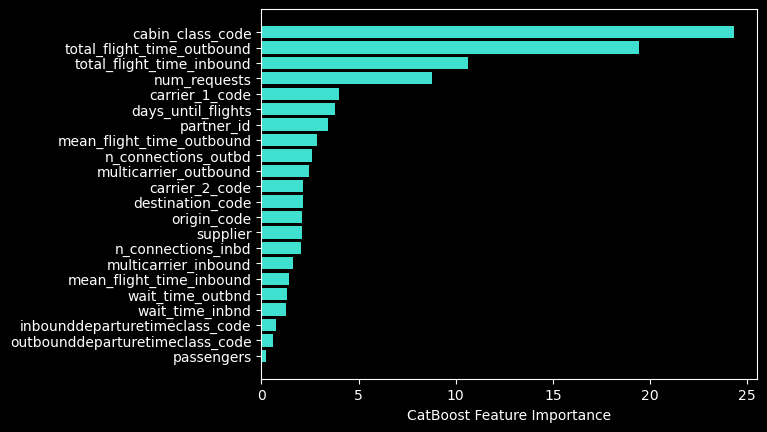

In [75]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")
plt.show()

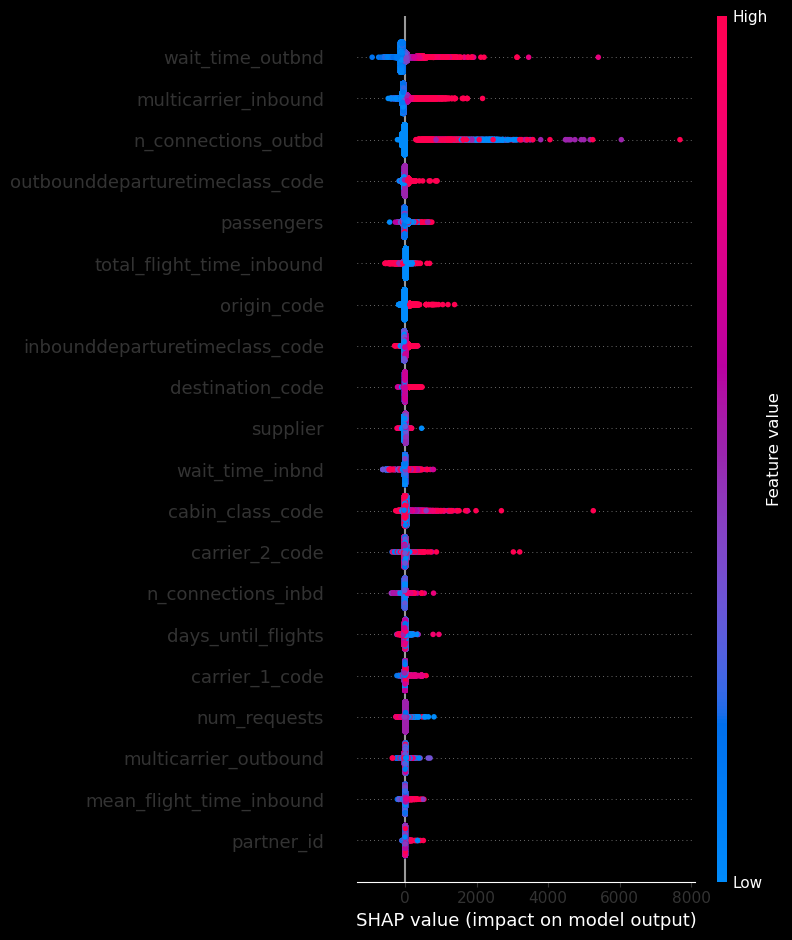

In [77]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = X_train.columns[sorted_feature_importance])

# Next steps

# Use cases